## ThyNet (Thyroid Network for thyroid ultrasound image diagnosis)

### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet34
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, average_precision_score
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from glob import glob
import os
import math
from IPython.display import display
import random
import copy
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Inspect images

In [3]:
root_dir = "/mnt/usb/ultrasound_data/0/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = list(set([x.split("_")[0] for x in patient_images_all]))
print("Num of patient images: ", len(patient_images_all))
print("Num of patients: ", len(patient_names))
del patient_images_all
print(patient_names)
demo_patient = random.choice(patient_names)
demo_patient_im_paths = glob(root_dir + demo_patient + "*")  # one of the patients name.
print(demo_patient_im_paths)  # print all images paths of that patient.

Num of patient images:  770
Num of patients:  93
['黄秀艳', '张文英', '冯华英', '肖尧根', '刘珈伊', '倪永青', '涂婷婷', '吴秀珠', '杨爱娥', '陆妹妹', '张志宝', '汪培忠', '曾令群', '胡士颖', '芦金祥', '陈海全', '陈钢', '左金梅', '沈美金', '沈惠芬', '朱彩云', '阮彩芳', '严木英', '屠雪林', '徐加芳', '马建林', '张凤英', '俞金英', '吴其芳', '王新菊', '叶春爱', '董茶英', '浦金华', '朱平康', '蒋利群', '沈利平', '姚新明', '陈嘉怡', '沈甫祥', '吴建', '马艳', '许见宝', '陈建英', '单思营', '朱燕', '胡先华', '贾必英', '高林华', '俞培华', '孙秋萍', '张玉梅', '张杏珍', '叶赛芸', '戴宇嫣', '郑爱女', '顾金珍', '陈建平', '冯水英', '张红萍', '周向芬', '杨国容', '俞建勤', '陆留生', '张佩娟', '苏明英', '汪薇', '庄杰', '王秀美', '沈美玉', '王栋武', '殳永明', '邱永新', '邵利英', '张英', '许光珍', '苏应彬', '邱美娥', '张牡丹', '许忠', '董雨强', '俞斌瑶', '张秀英', '孙静', '柯美芳', '陈明强', '金永明', '陈雨婷', '姜秀芳', '许金宝', '叶艳', '张秀忠', '金卫珍', '吴义兰']
['/mnt/usb/ultrasound_data/0/郑爱女_004.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_005.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_006.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_007.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_008.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_009.Jpg', '/mnt/usb/ultrasound_data/0/郑爱女_010.Jpg', '/mnt/usb/ultr

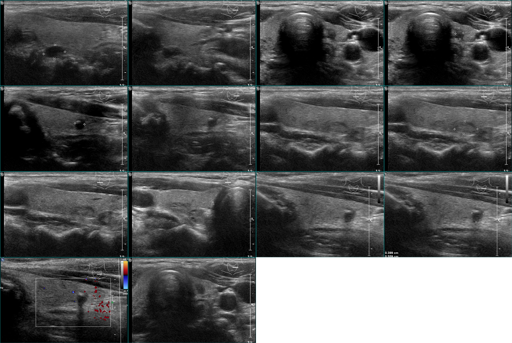

In [4]:
# show images below
def image_concat(image_names):
    """ image_names: list of image paths """
    # 1.creating a background
    image = Image.open(image_names[0])
    image_num = len(image_names)
    background_size = math.ceil(np.sqrt(image_num))
    width, height = image.size
    target_shape = (background_size*width, background_size*height)
    background = Image.new('RGBA', target_shape, (0,0,0,0,))

    # 2.put images into the background
    for ind, image_name in enumerate(image_names):
        img = Image.open(image_name)
        img = img.resize((width, height))  # resize
        if img.mode != "RGBA":             # mode adjusting
            img = img.convert("RGBA")
        row, col = ind//background_size, ind%background_size
        location = (col*width, row*height) # image location in the background
        background.paste(img, location)
    background.thumbnail((512, 512))
    #background.save("./mosaic.png")
    display(background)

image_concat(demo_patient_im_paths)

### Image statistics

In [5]:
root_dir = "/mnt/usb/ultrasound_data/0/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_0 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_0.columns = ["patient", "image_nums"]
folder_0["patient_index"] = list(range(len(folder_0)))

root_dir = "/mnt/usb/ultrasound_data/1/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_1 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_1.columns = ["patient", "image_nums"]
folder_1["patient_index"] = list(range(len(folder_1)))

root_dir = "/mnt/usb/ultrasound_data/2/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_2 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_2.columns = ["patient", "image_nums"]
folder_2["patient_index"] = list(range(len(folder_2)))

root_dir = "/mnt/usb/ultrasound_data/3/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_3 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_3.columns = ["patient", "image_nums"]
folder_3["patient_index"] = list(range(len(folder_3)))

root_dir = "/mnt/usb/ultrasound_data/4/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_4 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_4.columns = ["patient", "image_nums"]
folder_4["patient_index"] = list(range(len(folder_4)))

root_dir = "/mnt/usb/ultrasound_data/5/"  # 69 work station 10T hard drive, containing 0,1,2,3,4,5, five folders.
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_5 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_5.columns = ["patient", "image_nums"]
folder_5["patient_index"] = list(range(len(folder_5)))

root_dir = "/mnt/usb/ultrasound_data/miss_data/"
patient_images_all = [x.split("/")[-1] for x in glob(root_dir + "*.Jpg")]
patient_names = [x.split("_")[0] for x in patient_images_all]
folder_6 = pd.DataFrame(pd.value_counts(patient_names)).reset_index()
folder_6.columns = ["patient", "image_nums"]
folder_6["patient_index"] = list(range(len(folder_6)))

folder_6

,patient,image_nums,patient_index
0,顾卫琴,19,0
1,侯其英,14,1
2,莫晓玲,14,2
3,陈爱英,12,3
4,何文琴,11,4
5,陈福根,10,5
6,胡晓宇,8,6
7,龚秀知,8,7
8,沈兴海,5,8
9,郭詠霓,5,9


In [6]:
merged_df = pd.concat([folder_0, folder_1, folder_2, folder_3, folder_4, folder_5, folder_6])
merged_df

,patient,image_nums,patient_index
0,戴宇嫣,20,0
1,邵利英,19,1
2,陈建平,18,2
3,张杏珍,17,3
4,蒋利群,16,4
...,...,...,...
5,陈福根,10,5
6,胡晓宇,8,6
7,龚秀知,8,7
8,沈兴海,5,8


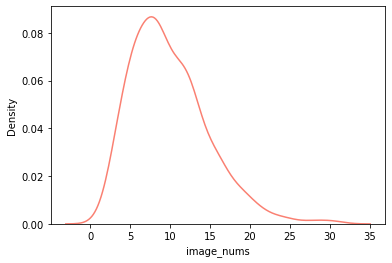

In [7]:
sns.kdeplot(x="image_nums", data=merged_df, color="salmon")
plt.savefig("image_num_stats.svg", format="svg")

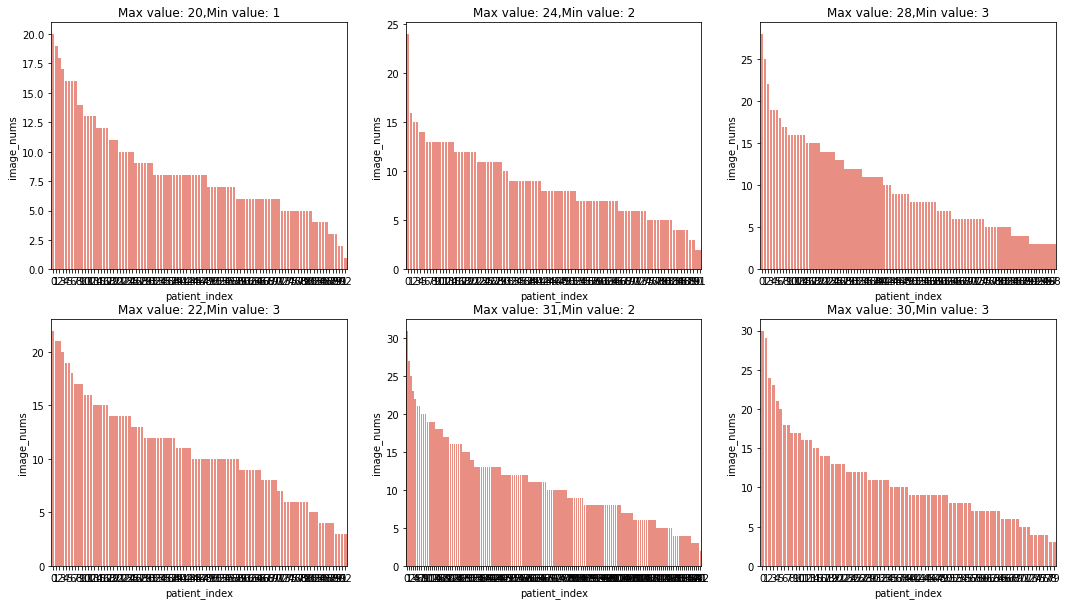

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.barplot(ax=axes[0, 0], x="patient_index", y="image_nums", data=folder_0, color="salmon")
axes[0, 0].set_title("Max value: " + str(folder_0.max().image_nums) + "," + "Min value: " + str(folder_0.min().image_nums))
sns.barplot(ax=axes[0, 1], x="patient_index", y="image_nums", data=folder_1, color="salmon")
axes[0, 1].set_title("Max value: " + str(folder_1.max().image_nums) + "," + "Min value: " + str(folder_1.min().image_nums))
sns.barplot(ax=axes[0, 2], x="patient_index", y="image_nums", data=folder_2, color="salmon")
axes[0, 2].set_title("Max value: " + str(folder_2.max().image_nums) + "," + "Min value: " + str(folder_2.min().image_nums))
sns.barplot(ax=axes[1, 0], x="patient_index", y="image_nums", data=folder_3, color="salmon")
axes[1, 0].set_title("Max value: " + str(folder_3.max().image_nums) + "," + "Min value: " + str(folder_3.min().image_nums))
sns.barplot(ax=axes[1, 1], x="patient_index", y="image_nums", data=folder_4, color="salmon")
axes[1, 1].set_title("Max value: " + str(folder_4.max().image_nums) + "," + "Min value: " + str(folder_4.min().image_nums))
sns.barplot(ax=axes[1, 2], x="patient_index", y="image_nums", data=folder_5, color="salmon")
axes[1, 2].set_title("Max value: " + str(folder_5.max().image_nums) + "," + "Min value: " + str(folder_5.min().image_nums))
plt.show()

### Create Dataset

#### Generate image path csv file from folder 0, 1, 2, 3, 4, 5, miss_data

In [18]:
#def generate_csv(root_dir, csv_path):
    #os.makedirs(csv_path, exist_ok=True)
    #images_paths = glob(root_dir + "*/*.Jpg")
    #df = pd.DataFrame(images_paths)
    #df.columns = ["path"]
    #df["patient_name"] = df["path"].map(lambda x: x.split("/")[-1].split("_")[0])
    #print(df)
    #df.to_csv(os.path.join(csv_path, "image_paths.csv"), index=False, encoding="utf_8_sig")  # encoding=utf-8 in case that Chinsese
    #print("===Saved %s to %s====" % ("image_paths.csv", csv_path))
    #return df

In [19]:
#root_dir = "/mnt/usb/ultrasound_data/"
#csv_path = "./tmp/"
#df = generate_csv(root_dir, csv_path)

                                                path patient_name
0             /mnt/usb/ultrasound_data/0/殳永明_005.Jpg          殳永明
1             /mnt/usb/ultrasound_data/0/严木英_001.Jpg          严木英
2             /mnt/usb/ultrasound_data/0/严木英_002.Jpg          严木英
3             /mnt/usb/ultrasound_data/0/严木英_003.Jpg          严木英
4             /mnt/usb/ultrasound_data/0/严木英_004.Jpg          严木英
...                                              ...          ...
6057  /mnt/usb/ultrasound_data/miss_data/龚秀知_021.Jpg          龚秀知
6058  /mnt/usb/ultrasound_data/miss_data/侯其英_010.Jpg          侯其英
6059  /mnt/usb/ultrasound_data/miss_data/莫晓玲_004.Jpg          莫晓玲
6060  /mnt/usb/ultrasound_data/miss_data/陈爱英_006.Jpg          陈爱英
6061  /mnt/usb/ultrasound_data/miss_data/顾卫琴_019.Jpg          顾卫琴

[6062 rows x 2 columns]
===Saved image_paths.csv to ./tmp/====


#### Load patient information csv
- Load case_info.csv from ./data folder
- Load patient_index_name.csv from ./data folder

In [8]:
# load case_info.csv from ./data folder
case_info_csv = "./data/case_info.csv"
case_info_df = pd.read_csv(case_info_csv)
case_info_df.rename(columns={"患者编号": "patient_index", "患者是否诊断为甲状腺癌": "histo_label"}, inplace=True)
case_info_df["histo_label"] = case_info_df["histo_label"].map(lambda x: 0 if x=="否" else 1)
case_info_part = case_info_df[["patient_index", "histo_label"]]
case_info_part

,patient_index,histo_label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1
...,...,...
606,607,1
607,608,1
608,609,1
609,610,0


In [9]:
# load patient_index_name.csv from ./data folder
patient_index_name_csv = "./data/patient_index_name.csv"
patient_index_name_df = pd.read_csv(patient_index_name_csv)
patient_index_name_df.sort_values("patient_index", inplace=True)
patient_index_name_df

,patient_index,patient_name
38,1,曾令群
90,2,沈甫祥
80,3,沈惠芬
78,4,沈利平
92,5,沈美金
...,...,...
593,607,周海根
589,608,周雪华
594,609,周雪明
551,610,周长根


In [10]:
# merge case_info_part and patient_index_name to obtain the relationship between patient name and histo label
merged_df = pd.merge(patient_index_name_df, case_info_part, on="patient_index")
# save merged_df to ./tmp/patient_name_label.csv
merged_df.to_csv("./tmp/patient_name_label.csv", index=False, encoding="utf_8_sig")
merged_df

,patient_index,patient_name,histo_label
0,1,曾令群,0
1,2,沈甫祥,1
2,3,沈惠芬,0
3,4,沈利平,0
4,5,沈美金,1
...,...,...,...
606,607,周海根,1
607,608,周雪华,1
608,609,周雪明,1
609,610,周长根,0


In [11]:
merged_df.histo_label.value_counts()

1    390
0    221
Name: histo_label, dtype: int64

In [12]:
merged_df.patient_name.value_counts()

毛袁伟    2
庄杰     2
张英     2
莫美娟    2
许光珍    2
      ..
张海宝    1
朱彩霞    1
徐霞     1
叶春爱    1
黄秀艳    1
Name: patient_name, Length: 605, dtype: int64

#### Rename patients with duplicated name
- Because there may be some duplicated patient names, we need to rename these patients in both ./tmp/image_paths.csv and ./tmp/patient_name_label.csv
- Upload the modified image_paths.csv and patient_name_label.csv to ./tmp folder again
- We also copy a backup of image_paths.csv and patient_name_label.csv in ./tmp/backup folder in case these csv files are deleted or overwrited accidently.

#### Build dataset

In [13]:
class ThyDataset(Dataset):
    
    def __init__(self, csv1_path, csv2_path, transform=None):
        """
        csv1_path: image_paths.csv in ./tmp folder
        csv2_path: patient_name_label.csv in ./tmp folder
        """
        self.df = pd.read_csv(csv1_path)
        self.unique_patients = list(set(self.df.patient_name))
        self.unique_patients.sort(key=list(self.df.patient_name).index)
        self.ref_df = pd.read_csv(csv2_path)
        self.transform = transform
        self.patient = None
        
    def __len__(self):
        return len(self.unique_patients)
    
    def __getitem__(self, index):
        images = []
        self.patient = self.unique_patients[index]
        label = self.ref_df[self.ref_df['patient_name']== self.patient].histo_label.item()
        image_paths_of_this_patient = list(self.df.path[self.df.patient_name == self.patient])
        for image_path in image_paths_of_this_patient:
            image = Image.open(image_path)
            if self.transform is not None:
                image = self.transform(image)
            images.append(image)
        images = torch.stack(images, dim=0)
        return images, label, self.patient

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
csv1_path = "./tmp/backup/image_paths.csv"
csv2_path = "./tmp/backup/patient_name_label.csv"
dataset = ThyDataset(csv1_path=csv1_path, csv2_path=csv2_path, transform=transform)

In [15]:
dataset.df

,path,patient_name
0,/mnt/usb/ultrasound_data/0/殳永明_005.Jpg,殳永明
1,/mnt/usb/ultrasound_data/0/严木英_001.Jpg,严木英
2,/mnt/usb/ultrasound_data/0/严木英_002.Jpg,严木英
3,/mnt/usb/ultrasound_data/0/严木英_003.Jpg,严木英
4,/mnt/usb/ultrasound_data/0/严木英_004.Jpg,严木英
...,...,...
6009,/mnt/usb/ultrasound_data/miss_data/龚秀知_021.Jpg,龚秀知
6010,/mnt/usb/ultrasound_data/miss_data/侯其英_010.Jpg,侯其英
6011,/mnt/usb/ultrasound_data/miss_data/莫晓玲_004.Jpg,莫晓玲
6012,/mnt/usb/ultrasound_data/miss_data/陈爱英_006.Jpg,陈爱英


In [16]:
# check the dataset loading
all_labels = []
for tensor, label, patient in tqdm(dataset):
    all_labels.append(label)
    print(patient)

  0%|          | 0/603 [00:00<?, ?it/s]

殳永明
严木英
俞培华
俞建勤
俞斌瑶
俞金英
倪永青
冯华英
冯水英
刘珈伊
单思营
叶春爱
叶艳
叶赛芸
吴义兰
周向芬
孙秋萍
屠雪林
张佩娟
张志宝
张杏珍
张秀忠
张英_0
戴宇嫣
朱平康
朱燕
杨国容
吴其芳
吴建
吴秀珠
姚新明
姜秀芳
孙静
左金梅
庄杰_0
张凤英
张文英
张牡丹
张玉梅
张红萍
徐加芳
曾令群
朱彩云
杨爱娥
柯美芳
汪培忠
汪薇
沈利平
沈惠芬
沈甫祥
沈美玉
沈美金
浦金华
涂婷婷
王新菊
王栋武
王秀美
肖尧根
胡先华
胡士颖
芦金祥
苏应彬
苏明英
董茶英
董雨强
蒋利群
许忠
许见宝
许金宝
贾必英
邱永新
邱美娥
邵利英
郑爱女
金卫珍
金永明
阮彩芳
陆妹妹
陆留生
陈嘉怡
陈建平
陈建英
陈明强
陈海全
陈钢
陈雨婷
顾金珍
马建林
马艳
高林华
黄秀艳
朱灵云
丁小娟
于扣英
于洪艳
代绍美
任小珍
余正树
俞娟宝
俞小宝
傅海庆
凌丹琴
刘雯
包一薇
史小妹
吕碧寒
吴惠刚
吴细秀
姚月仙
屠晴伟
崔光碧
张娟英
张海宝
张英_1
成金花
朱含修
包从仙
叶沈涛
吴佳丽
吴玲丽
唐建祥
姚佳萍
孙海燕
宋永怡
庄玉和
张佳斌
张佳辉
张巧金
彭平
徐涛
徐雨
方学东
朱引华
朱江华
朱美宝
朱美林
朱金山
李振华
李景珍
李英
杜炽凤
林莉
殳平
沈贤甫
浦秀华
潘桂娣
王彩英
王文婷
祝文珍
禹航
胡彦非
蒋梓炀
袁玉如
计惠平
许月萍
谢明忠
谢杰
谢银龙
费大平
费明芬
赵根娣
邓淑兰
邱引珠
邱连忠
邵亚环
郑佳丽
郑勤燕
郭蓉焱
陆利琴
陆叶飞
陆小凤
陆树英
陆风杰
陈建军
陈雅娟
陶丽珍
顾连兴
高惠芳
高振侠
黄金兰
高银兰
汤梦菲
丁思成
任桂英
何志芬
侯丽校
侯标
倪龙英
冯明华
冯菊英
刘三妹
刘云清
刘秀芬
刘西安
厉云香
孙元
孙发忠
孙彩英
孟丽娟
平芳英
曹丽
李琦航
李群
梅颖
刘家蟾
刘桂兰
卜会珍
唐明路
孙利生
孙璐华
宋秀芳
戈建英
戴菊英
李兰
李君
李微
李蓉
梁小平
檀亚玲
汤茶谷
沈丹萍
沈凤英
沈培芬
沈建琴
沈桂凤
沈英
潘自力
瞿玉梅
石子芹
简晓燕
罗有碧
罗清泉
胡全英
胡文祥
胡玉苔
胡贵君
范香桂
莫士姣
莫金观
董加悦
蒋水佳
蔡忠勤
蔡海英
费育芳
贺利英
路爱朵
边华英
连水兴
金巧英
金星
金素珍
金红柳
金羽
陆根生
陆红霞
陈小妹
陈海

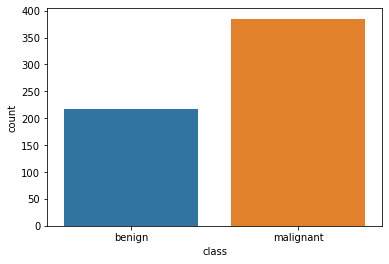

,count,class
0,218,benign
1,385,malignant


In [17]:
# inspect the labels
plt.cla()
labels_df = pd.DataFrame([all_labels.count(0), all_labels.count(1)],
                         columns=["count"])
labels_df["class"] = ["benign", "malignant"]
sns.barplot(x="class", y="count", data=labels_df)
plt.savefig("bar.svg", format="svg")
plt.show()
labels_df

In [25]:
# visualize a few images
def imshow(inp, title=None, savename=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if savename is not None:
        plt.savefig(savename, format="svg")
    plt.show()
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

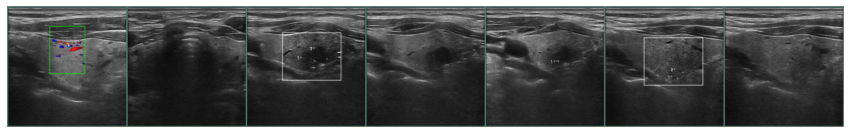

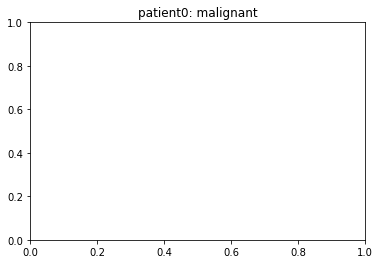

In [26]:
class_names = {0: "benign", 1: "malignant"}
image0, label0, patient0 = dataset[0]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image0)
imshow(out, title="patient0" + ": " + class_names[label0], savename="magdemo.svg")

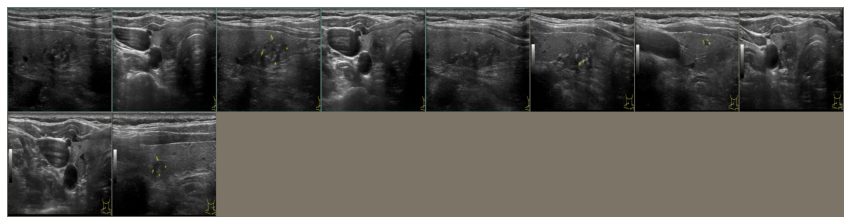

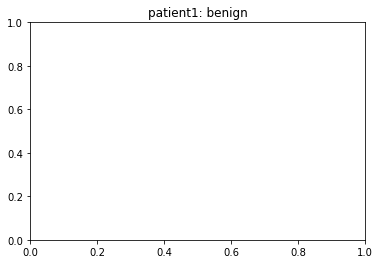

In [27]:
image1, label1, patient1 = dataset[1]  # select images from patient1
# Make a grid from patient1
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image1)
imshow(out, title="patient1" + ": " + class_names[label1], savename="bedemo.svg")

#### Build dataloader
Because each patient has various images, each item generated by the dataset is various in length.
In order to wrap it into dataloader, we need to pad each tensor in dataset to a fixed length.
We know that the max length is 31 in our data, thus we need to pad the length to 31

In [40]:
# build our own collate_fn
def pad_tensor(tensor, pad, dim):
    """
    tensor: tensor to pad
    pad: the size to pad to
    dim: dimension to pad
    """
    pad_size = list(tensor.shape)
    pad_size[dim] = pad - tensor.size(dim)
    return torch.cat([tensor, torch.zeros(pad_size)], dim=dim)


class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        # pad according to max_len
        images = [x[0] for x in batch]
        labels = [x[1] for x in batch]
        patients = [x[2] for x in batch]
        batch = map(lambda x, y, z: [pad_tensor(x, pad=max_len, dim=self.dim), y, z], images, labels, patients)
        # stack all
        batch = list(batch)
        xs = torch.stack(list(map(lambda x: x[0], batch)), dim=0)
        ys = torch.LongTensor(list(map(lambda x: x[1], batch)))
        zs = list(map(lambda x: x[2], batch))
        return xs, ys, zs

    def __call__(self, batch):
        return self.pad_collate(batch)

In [41]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=PadCollate(dim=0), num_workers=6)

In [42]:
x, y, z=iter(dataloader).__next__()  # check one batch of data

### Build model

ThyNet building, a dual attention and end-to-end model for thyroid diagnosis

#### Instance Relationship Attention Module (IRAM)
We propose IRAM to explore relationship across different images in a patient for instance feature enhancement.

$F=[F_1, F_2, ..., F_c], F\in\mathbb{R}^{(N\times K) \times C \times H \times W}$

$F_{ds}=f_{downsample}(F)$

$M_{IRAM}=$

In [43]:
"""
IRAM
args:
    C1: channel of feature extracted by feature extractor, equals to C
    C2: channel C'
    dropout: whether to use dropout (p=0.25)
    tau: scaling factor for psi12
"""
class IRAM(nn.Module):
    
    def __init__(self, C1, C2=128, dropout=True, tau=128):
        super(IRAM, self).__init__()
        self.C1 = C1
        self.C2 = C2
        self.psi1 = [
            nn.Conv2d(C1, C2, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        ]
        self.psi2 = [
            nn.Conv2d(C1, C2, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        ]
        self.psi3 = [
            nn.Conv2d(C1, C2, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        ]
        self.psi4 = [
            nn.Linear(C2, C1),
            nn.ReLU()
        ]
        if dropout:
            self.psi1.append(nn.Dropout(0.25))
            self.psi2.append(nn.Dropout(0.25))
            self.psi3.append(nn.Dropout(0.25))
            self.psi4.append(nn.Dropout(0.25))
        self.tau = tau
        self.psi1 = nn.Sequential(*self.psi1)
        self.psi2 = nn.Sequential(*self.psi2)
        self.psi3 = nn.Sequential(*self.psi3)
        self.psi4 = nn.Sequential(*self.psi4)
        
    def forward(self, x):
        x_psi1 = self.psi1(x)
        x_psi1 = x_psi1.view(-1, self.C2)
        x_ds = F.interpolate(x, scale_factor=0.5)
        x_psi2 = self.psi2(x_ds)
        x_psi2 = x_psi2.view(self.C2, -1)
        x_psi3 = self.psi3(x_ds)
        x_psi3 = x_psi3.view(-1, self.C2)
        psi12 = F.softmax(torch.mm(x_psi1, x_psi2) / self.tau)
        psi123 = torch.mm(psi12, x_psi3)
        psi1234 = self.psi4(psi123)
        M = psi1234.view(x.shape) + x
        return M, x

In [44]:
# check IRAM
x=torch.randn(16, 20, 256, 8, 8)
iram = IRAM(C1=256)
x_viewed = x.view(-1, 256, 8, 8)
M, x_out = iram(x_viewed)
print(M.shape)
print(x_out.shape)

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([320, 256, 8, 8])
torch.Size([320, 256, 8, 8])


/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#### Instance Score Attention Module (ISAM)
We propose ISAM to give importance score to different images in a patient for instance feature filtering.

In [45]:
"""
ISAM
args:
    batch_size: batch size
    L: input feature dimension of M, equals to C1 in IRAM module
    D: hidden layer dimension
    dropout: whether to use dropout (p=0.25)
    n_classes: number of classes
"""
class ISAM(nn.Module):
    
    def __init__(self, batch_size, L, D=256, n_classes=1, dropout=True):
        super(ISAM, self).__init__()
        self.L = L
        self.D = D
        self.batch_size = batch_size
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()
        ]
        self.attention_b = [
            nn.Linear(L, D),
            nn.Sigmoid()
        ]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))
            
        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        self.attention_c = nn.Linear(D, n_classes)
        
    def forward(self, x):
        x_pooled = self.pool(x).view(x.shape[0], self.L)
        a = self.attention_a(x_pooled)
        b = self.attention_b(x_pooled)
        A = a.mul(b)
        A = self.attention_c(A)
        if not self.training:
            A = A.view(1, 1, -1)
        else:
            A = A.view(self.batch_size, 1, -1)
        return A, x_pooled, x

In [46]:
# check ISAM
isam = ISAM(batch_size=16, L=M.shape[1])
A, x_pooled, x_out_isam = isam(M)

In [47]:
print(A.shape)
print(x_pooled.shape)
print(x_out_isam.shape)

torch.Size([16, 1, 20])
torch.Size([320, 256])
torch.Size([320, 256, 8, 8])


In [48]:
torch.equal(x_out_isam, M)

True

#### ThyNet model
Put all the modules together and build the final ThyNet model.

In [49]:
"""
Args:
    C2: channel C', default 128
    D: hidden layer dimension, default 256
    batch_size: batch_size
    num_cls: number of classes, default 2
    n_channels: image channel, 3 in this study
    dropout: whether to use dropout (p=0.25)
"""
class ThyNet(nn.Module):
    
    def __init__(self, C2, D, batch_size, dropout=True, num_cls=2, n_channels=3):
        super(ThyNet, self).__init__()
        feature_extractor = resnet34(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
        #for p in self.feature_extractor.parameters():
            #p.requires_grad = False
        self.C1 = self.feature_extractor[-1][-1].conv2.out_channels
        self.L = self.C1
        self.iram = IRAM(C1=self.C1, C2=C2, dropout=dropout, tau=C2)
        self.isam = ISAM(batch_size=batch_size, L=self.L, D=D, dropout=dropout)
        self.classifier = nn.Linear(self.C1, num_cls)
        
        self.n_channels = n_channels
        self.batch_size = batch_size
        
    def forward(self, x):
        x = x.view(-1, self.n_channels, x.shape[-2], x.shape[-1])
        feat = self.feature_extractor(x)
        M, _ = self.iram(feat)
        A, x_pooled, _ = self.isam(M)
        A = F.softmax(A, dim=2)  # softmax over instances
        if not self.training:
            x_pooled = x_pooled.view(1, -1, self.C1)
            h = torch.bmm(A, x_pooled).view(1, self.C1)
        else:
            x_pooled = x_pooled.view(self.batch_size, -1, self.C1)
            h = torch.bmm(A, x_pooled).view(self.batch_size, self.C1)
        logits = self.classifier(h)
        return logits

Insert model picture here
xxxxxxxxx

In [51]:
# Check ThyNet
demo_xs, demo_labels, demo_patients = iter(dataloader).__next__()
thynet = ThyNet(C2=128, D=256, batch_size=16)
thynet

ThyNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [52]:
demo_preds = thynet(demo_xs)
print("demo_patients: ", demo_patients)
print("demo_labels: ", demo_labels.shape)
print(demo_labels)
print("===========\n")
print("demo_preds: ", demo_preds.shape)
print(demo_preds)

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


demo_patients:  ['沈凤英', '张妮', '朱金山', '梁小平', '钟文娟', '单冬春', '郑日炎', '李兰', '朱灵云', '瞿玉梅', '刘西安', '李芳', '俞斌瑶', '朱佳丽', '江连彩', '彭林珍']
demo_labels:  torch.Size([16])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

demo_preds:  torch.Size([16, 2])
tensor([[-0.7295, -0.3156],
        [-1.3484, -0.1294],
        [-0.6117, -0.2922],
        [-0.5660, -0.2891],
        [-1.2400, -0.0945],
        [-1.3179, -0.3336],
        [-0.7476, -0.1467],
        [-0.6954, -0.1228],
        [-0.5630, -0.3441],
        [-0.8284,  0.0185],
        [-0.6331, -0.0204],
        [-0.6503, -0.1255],
        [-1.2524,  0.0398],
        [-0.9942,  0.0979],
        [-0.7986,  0.0917],
        [-0.8395, -0.1919]], grad_fn=<AddmmBackward>)


### Training procedure

#### Create 5-fold cross validation set
First, split all patients into trainval and test, then split trainval patients into 5 fold. Save all the csv files in ./split folder.

In [53]:
"""
Args:
    csv1_path: image_paths.csv in ./tmp folder
    csv2_path: patient_name_label.csv in ./tmp folder
    test_size: size of test set for external testing
    seed: random seed
    k: number of folds
    split_dir: dir to save splitted csv files, default ./split folder
"""
def split(csv1_path, csv2_path, test_size=0.1, seed=202203, k=5, split_dir="./split"):
    print("Splitting %d fold csv files..." % k)
    os.makedirs(split_dir, exist_ok=True)
    all_image_paths_df = pd.read_csv(csv1_path)
    all_patient_and_labels_df = pd.read_csv(csv2_path)
    train_val_patient_df, test_patient_df = train_test_split(all_patient_and_labels_df,
                                                             test_size=test_size,
                                                             random_state=seed)
    print("Saving patient level test df")
    test_patient_df.to_csv(os.path.join(split_dir, "test_case.csv"), index=False)
    test_images_paths_df = all_image_paths_df[
        all_image_paths_df["patient_name"].isin(test_patient_df["patient_name"])
    ]
    print("Saving image level test df")
    test_images_paths_df.to_csv(os.path.join(split_dir, "test_image.csv"), index=False)
    kf = KFold(n_splits=k, random_state=seed, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(train_val_patient_df)):
        train_patient_df, val_patient_df = train_val_patient_df.iloc[train_index], train_val_patient_df.iloc[test_index]
        print("Saving patient level df fold %d" % i)
        train_patient_df.to_csv(os.path.join(split_dir, "train_case_split_" + str(i) + ".csv"), index=False)
        val_patient_df.to_csv(os.path.join(split_dir, "val_case_split_" + str(i) + ".csv"), index=False)
        train_image_paths_df = all_image_paths_df[
            all_image_paths_df["patient_name"].isin(train_patient_df["patient_name"])
        ]
        val_image_paths_df = all_image_paths_df[
            all_image_paths_df["patient_name"].isin(val_patient_df["patient_name"])
        ]
        print("Saving image level df fold %d" % i)
        train_image_paths_df.to_csv(os.path.join(split_dir, "train_image_split_" + str(i) + ".csv"), index=False)
        val_image_paths_df.to_csv(os.path.join(split_dir, "val_image_split_" + str(i) + ".csv"), index=False)

In [54]:
csv1_path = "./tmp/image_paths.csv"
csv2_path = "./tmp/patient_name_label.csv"
split(csv1_path, csv2_path)

Splitting 5 fold csv files...
Saving patient level test df
Saving image level test df
Saving patient level df fold 0
Saving image level df fold 0
Saving patient level df fold 1
Saving image level df fold 1
Saving patient level df fold 2
Saving image level df fold 2
Saving patient level df fold 3
Saving image level df fold 3
Saving patient level df fold 4
Saving image level df fold 4


#### Some tools for training

In [55]:
"""
Learning rate warming up
"""
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    """learning rate warmup"""

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [56]:
@torch.no_grad()
def eval_process(epoch, model, criterion, dataloader, device):
    print("Epoch %d Validation......" % epoch)
    cpu_device = torch.device("cpu")
    model.eval()
    labels = []
    preds = []
    running_loss = 0.
    for images, targets, _ in tqdm(dataloader):
        images = images.to(device)
        labels.extend(targets.tolist())
        targets = targets.to(device)
        logits = model(images)
        preds.extend(logits.cpu().numpy()[:, -1].tolist())
        loss = criterion(logits, targets)
        running_loss += loss.item() * images.size(0)

    eval_loss = running_loss / len(dataloader.dataset)
    print("Eval val loss: %.4f" % eval_loss)
    
    auc_score = roc_auc_score(labels, preds)
    print("Val AUC: %.4f" % auc_score)
    return auc_score, eval_loss

In [57]:
@torch.no_grad()
def test_process(model, criterion, dataloader, device):
    cpu_device = torch.device("cpu")
    model.eval()
    labels = []
    preds_logits = []
    preds_probs = []
    running_loss = 0.
    all_patient_names = []
    for ind, (images, targets, patient_names) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        labels.extend(targets.tolist())
        targets = targets.to(device)
        logits = model(images)
        pred_probs = torch.softmax(logits, 1)
        preds_probs.extend(pred_probs.cpu().numpy()[:, -1].tolist())
        loss = criterion(logits, targets)
        running_loss += loss.item() * images.size(0)
        all_patient_names.extend(patient_names)
        preds_logits.extend(logits.cpu().numpy()[:, -1].tolist())

    test_loss = running_loss / len(dataloader.dataset)
    print("Test loss: %.4f" % test_loss)
    
    auc_score = roc_auc_score(labels, preds_logits)
    average_precision = average_precision_score(labels, preds_logits)
    print("Test AUC: %.4f" % auc_score)
    print("Test AP: %.4f" % average_precision)
    # plot_roc_curve(labels, final_logits)
    # plot_pr_curve(labels, final_logits)
    df = pd.DataFrame({"patient_name": all_patient_names,
                       "prob": preds_probs,
                       "logit": preds_logits,
                       "label": labels})

    return auc_score, test_loss, df

In [58]:
def train_process(model, criterion, optimizer, lr_sche, dataloaders,
                  num_epochs, use_tensorboard, device,
                  save_model_path, record_iter, writer=None):
    model.train()

    best_score = 0.0
    best_state_dict = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        lr_scheduler = None
        running_loss = 0.0
        print("====Epoch{0}====".format(epoch))
        if epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, len(dataloaders["train"]) - 1)
            lr_scheduler = warmup_lr_scheduler(
                optimizer, warmup_iters, warmup_factor
            )

        for i, (images, targets, _) in enumerate(tqdm(dataloaders["train"])):
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, targets)

            if not math.isfinite(loss.item()):
                print("Loss is {}, stopping training".format(loss.item()))
                sys.exit(1)

            loss.backward()
            optimizer.step()
            if lr_scheduler is not None:
                lr_scheduler.step()

            running_loss += loss.item() * images.size(0)

            lr = optimizer.param_groups[0]["lr"]

            if (i + 1) % record_iter == 0:
                to_date_cases = (i + 1) * images.size(0)
                tmp_loss = running_loss / to_date_cases
                print("Epoch{0} loss:{1:.4f}".format(epoch, tmp_loss))
                
                if use_tensorboard:
                    writer.add_scalar("Train loss",
                                      tmp_loss,
                                      epoch * len(dataloaders["train"]) + i)
                    writer.add_scalar("lr", lr,
                                      epoch * len(dataloaders["train"]) + i)

        val_auc, val_loss = eval_process(
            epoch, model, criterion, dataloaders["val"], device
        )
        if lr_sche is not None:
            lr_sche.step()

        if val_auc > best_score:
            best_score = val_auc
            best_state_dict = copy.deepcopy(model.state_dict())

        if use_tensorboard:
            writer.add_scalar(
                "validataion AUC", val_auc, global_step=epoch
            )
            writer.add_scalar(
                "validation loss", val_loss, global_step=epoch
            )

        model.train()

    print("Training Done!")
    print("Best Valid AUC: %.4f" % best_score)
    torch.save(best_state_dict, save_model_path)

    print("========Start Testing========")
    model.load_state_dict(best_state_dict)
    test_auc, test_loss, df = test_process(
        model, criterion, dataloaders["test"], device
    )
    if use_tensorboard:
        writer.add_scalar("Test AUC", test_auc, global_step=0)
        writer.close()

#### Training

##### Data augmentation

In [59]:
"""
Cutout: Randomly mask out one or more patches from an image
        ref paper: Improved Regularization of Convolutional Neural Networks with Cutout.
"""
class Cutout(object):
    """Randomly mask out one or more patches from an image"""
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (tensor): Tensor image of size (C, H, W)
        Returns:
            Image with n_holes of dimension lengthxlength cut out of it
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

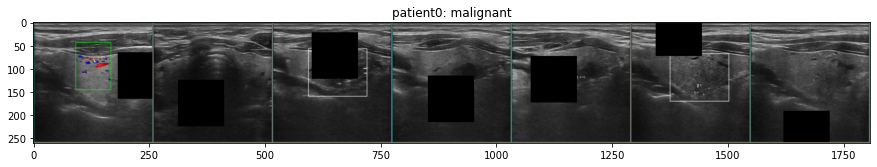

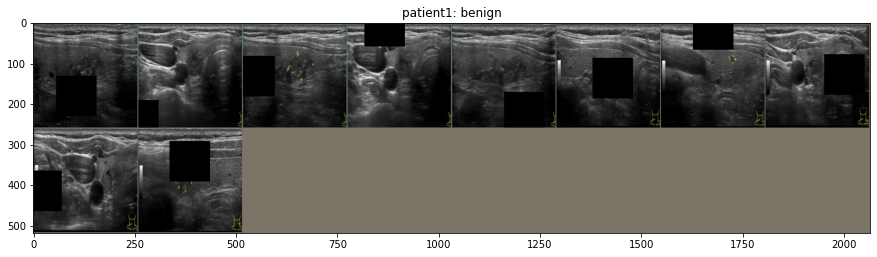

In [60]:
# Check Cutout
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        Cutout(1, 100),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

csv1_path = "./tmp/image_paths.csv"
csv2_path = "./tmp/patient_name_label.csv"
dataset = ThyDataset(csv1_path=csv1_path, csv2_path=csv2_path, transform=transform)

class_names = {0: "benign", 1: "malignant"}
image0, label0, patient0 = dataset[0]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image0)
imshow(out, title="patient0" + ": " + class_names[label0])

image1, label1, patient1 = dataset[1]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image1)
imshow(out, title="patient1" + ": " + class_names[label1])

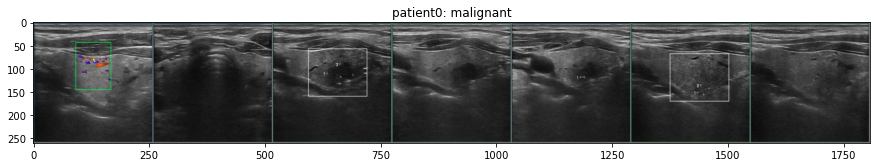

In [61]:
# Check Colorjitter
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ColorJitter(brightness=0.075, saturation=0.075, hue=0.075),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

csv1_path = "./tmp/image_paths.csv"
csv2_path = "./tmp/patient_name_label.csv"
dataset = ThyDataset(csv1_path=csv1_path, csv2_path=csv2_path, transform=transform)

class_names = {0: "benign", 1: "malignant"}
image0, label0, patient0 = dataset[0]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image0)
imshow(out, title="patient0" + ": " + class_names[label0])

In [62]:
"""
RandomRotation
"""
class MyRotationTrans:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return torchvision.transforms.functional.rotate(x, angle)

In [63]:
# Build the final transform
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        MyRotationTrans([0, 90, 180, 270]),
        transforms.ColorJitter(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        Cutout(1, 100),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

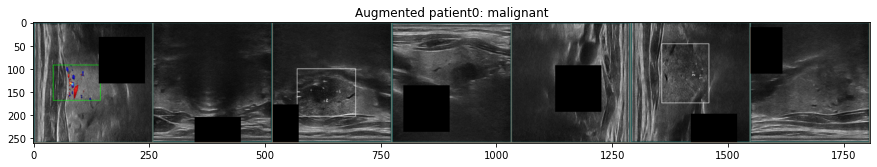

In [64]:
# Check train transform
csv1_path = "./tmp/image_paths.csv"
csv2_path = "./tmp/patient_name_label.csv"
dataset = ThyDataset(csv1_path=csv1_path, csv2_path=csv2_path, transform=transform)

class_names = {0: "benign", 1: "malignant"}
image0, label0, patient0 = dataset[0]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image0)
imshow(out, title="Augmented patient0" + ": " + class_names[label0])

##### Training function

In [65]:
# function for k-fold cross validation training procedure
def train_thynet(k, split_dir, save_model_dir,
                 train_trans, val_trans, batch_size,
                 num_workers, C2, D, device, lr,
                 momentum, weight_decay, gamma,
                 logdir, num_epochs, use_tensorboard,
                 record_iter):
    test_csv1_path = os.path.join(split_dir, "test_image.csv")
    test_csv2_path = os.path.join(split_dir, "test_case.csv")
    print("Building test dataset...")
    test_dataset = ThyDataset(csv1_path=test_csv1_path, csv2_path=test_csv2_path,
                              transform=val_trans)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=num_workers)
    for i in range(k):
        print("====Starting Fold %d====" % (i + 1))
        print("Building fold %d train dataset..." % (i + 1))
        train_csv1_path = os.path.join(split_dir, "train_image_split_" + str(i) + ".csv")
        train_csv2_path = os.path.join(split_dir, "train_case_split_" + str(i) + ".csv")
        train_dataset = ThyDataset(csv1_path=train_csv1_path, csv2_path=train_csv2_path,
                                   transform=train_trans)
        print("Building fold %d val dataset..." % (i + 1))
        val_csv1_path = os.path.join(split_dir, "val_image_split_" + str(i) + ".csv")
        val_csv2_path = os.path.join(split_dir, "val_case_split_" + str(i) + ".csv")
        val_dataset = ThyDataset(csv1_path=val_csv1_path, csv2_path=val_csv2_path,
                                 transform=val_trans)
        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, collate_fn=PadCollate(dim=0),
                                  num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                                num_workers=num_workers)
        dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}
        print("Dataset Done...")
        
        print("Preparing Model...")
        thynet = ThyNet(C2=C2, D=D, batch_size=batch_size)
        thynet = thynet.to(device)
        #if torch.cuda.device_count() > 1:
            #thynet = nn.DataParallel(thynet)
        print("Model Done...")
        
        #params = filter(lambda p: p.requires_grad, thynet.parameters())
        params = [p for p in thynet.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr,
                                   momentum=momentum,
                                   weight_decay=weight_decay)
        #optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75],
                                                            gamma=gamma)
        criterion = nn.CrossEntropyLoss()
        print("Start Training...")
        os.makedirs(logdir, exist_ok=True)
        writer = SummaryWriter(logdir)
        os.makedirs(save_model_dir, exist_ok=True)
        save_model_path = os.path.join(save_model_dir, "thynet_fold_%d.pth" % (i + 1))
        train_process(model=thynet, criterion=criterion, optimizer=optimizer,
                      lr_sche=lr_scheduler, dataloaders=dataloaders, writer=writer,
                      num_epochs=num_epochs, use_tensorboard=use_tensorboard,
                      device=device, save_model_path=save_model_path,
                      record_iter=record_iter)
        
    print("====Training Done====")

##### Training

In [66]:
# settings
k = 5
split_dir = "./split/"
save_model_dir = "./result/"
train_trans = transform
val_trans = val_transform
batch_size = 10
num_workers = 12
C2 = 128
D = 256
device = device
lr = 0.001
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
logdir = "./logs/"
num_epochs = 100
use_tensorboard = True
record_iter = 10

In [67]:
train_thynet(k, split_dir, save_model_dir,
             train_trans, val_trans, batch_size,
             num_workers, C2, D, device, lr,
             momentum, weight_decay, gamma,
             logdir, num_epochs, use_tensorboard,
             record_iter)

Building test dataset...
====Starting Fold 1====
Building fold 1 train dataset...
Building fold 1 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/43 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch0 loss:0.6341
Epoch0 loss:0.6386
Epoch0 loss:0.6642
Epoch0 loss:0.6782
Epoch 0 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6927
Val AUC: 0.5298
====Epoch1====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch1 loss:0.6681
Epoch1 loss:0.6453
Epoch1 loss:0.6437
Epoch1 loss:0.6586
Epoch 1 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6809
Val AUC: 0.5769
====Epoch2====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch2 loss:0.6658
Epoch2 loss:0.6476
Epoch2 loss:0.6377
Epoch2 loss:0.6463
Epoch 2 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6744
Val AUC: 0.5804
====Epoch3====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch3 loss:0.6839
Epoch3 loss:0.6489
Epoch3 loss:0.6469
Epoch3 loss:0.6531
Epoch 3 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.9160
Val AUC: 0.6059
====Epoch4====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch4 loss:0.6760
Epoch4 loss:0.6335
Epoch4 loss:0.6082
Epoch4 loss:0.6210
Epoch 4 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7955
Val AUC: 0.6184
====Epoch5====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch5 loss:0.7633
Epoch5 loss:0.7424
Epoch5 loss:0.7147
Epoch5 loss:0.6971
Epoch 5 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7860
Val AUC: 0.6857
====Epoch6====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch6 loss:0.6544
Epoch6 loss:0.6111
Epoch6 loss:0.6062
Epoch6 loss:0.6030
Epoch 6 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1061
Val AUC: 0.6561
====Epoch7====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch7 loss:0.6252
Epoch7 loss:0.6826
Epoch7 loss:0.6906
Epoch7 loss:0.6664
Epoch 7 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7890
Val AUC: 0.6292
====Epoch8====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch8 loss:0.6231
Epoch8 loss:0.5898
Epoch8 loss:0.5670
Epoch8 loss:0.5638
Epoch 8 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6899
Val AUC: 0.6899
====Epoch9====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch9 loss:0.5664
Epoch9 loss:0.6000
Epoch9 loss:0.5933
Epoch9 loss:0.5954
Epoch 9 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7749
Val AUC: 0.6882
====Epoch10====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch10 loss:0.5526
Epoch10 loss:0.5293
Epoch10 loss:0.5361
Epoch10 loss:0.5224
Epoch 10 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.0458
Val AUC: 0.6575
====Epoch11====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch11 loss:0.4885
Epoch11 loss:0.5461
Epoch11 loss:0.5314
Epoch11 loss:0.5596
Epoch 11 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6721
Val AUC: 0.6128
====Epoch12====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch12 loss:0.6868
Epoch12 loss:0.6131
Epoch12 loss:0.6203
Epoch12 loss:0.6115
Epoch 12 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1271
Val AUC: 0.6871
====Epoch13====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch13 loss:0.5196
Epoch13 loss:0.6398
Epoch13 loss:0.6404
Epoch13 loss:0.5966
Epoch 13 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6653
Val AUC: 0.7227
====Epoch14====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch14 loss:0.5888
Epoch14 loss:0.5247
Epoch14 loss:0.4974
Epoch14 loss:0.4750
Epoch 14 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1931
Val AUC: 0.6972
====Epoch15====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch15 loss:0.4703
Epoch15 loss:0.4763
Epoch15 loss:0.4829
Epoch15 loss:0.4991
Epoch 15 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1819
Val AUC: 0.7119
====Epoch16====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch16 loss:0.4879
Epoch16 loss:0.4548
Epoch16 loss:0.5074
Epoch16 loss:0.5158
Epoch 16 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.3263
Val AUC: 0.7032
====Epoch17====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch17 loss:0.4449
Epoch17 loss:0.4021
Epoch17 loss:0.4872
Epoch17 loss:0.5022
Epoch 17 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.3340
Val AUC: 0.6979
====Epoch18====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch18 loss:0.4751
Epoch18 loss:0.4772
Epoch18 loss:0.4952
Epoch18 loss:0.5019
Epoch 18 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8399
Val AUC: 0.7447
====Epoch19====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch19 loss:0.3359
Epoch19 loss:0.3829
Epoch19 loss:0.4156
Epoch19 loss:0.4267
Epoch 19 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8967
Val AUC: 0.7238
====Epoch20====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch20 loss:0.5151
Epoch20 loss:0.4265
Epoch20 loss:0.4534
Epoch20 loss:0.4550
Epoch 20 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1022
Val AUC: 0.7105
====Epoch21====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch21 loss:0.4575
Epoch21 loss:0.4307
Epoch21 loss:0.4595
Epoch21 loss:0.4341
Epoch 21 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6601
Val AUC: 0.6836
====Epoch22====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch22 loss:0.3884
Epoch22 loss:0.4413
Epoch22 loss:0.4382
Epoch22 loss:0.4671
Epoch 22 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5873
Val AUC: 0.6564
====Epoch23====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch23 loss:0.3937
Epoch23 loss:0.4319
Epoch23 loss:0.4306
Epoch23 loss:0.4173
Epoch 23 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.8406
Val AUC: 0.7290
====Epoch24====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch24 loss:0.3579
Epoch24 loss:0.3511
Epoch24 loss:0.3836
Epoch24 loss:0.3667
Epoch 24 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8406
Val AUC: 0.7443
====Epoch25====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch25 loss:0.3306
Epoch25 loss:0.3260
Epoch25 loss:0.3658
Epoch25 loss:0.3901
Epoch 25 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.1205
Val AUC: 0.7133
====Epoch26====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch26 loss:0.4124
Epoch26 loss:0.4058
Epoch26 loss:0.4077
Epoch26 loss:0.3925
Epoch 26 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1082
Val AUC: 0.7297
====Epoch27====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch27 loss:0.3465
Epoch27 loss:0.3403
Epoch27 loss:0.3739
Epoch27 loss:0.3814
Epoch 27 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.4158
Val AUC: 0.7018
====Epoch28====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch28 loss:0.3230
Epoch28 loss:0.3325
Epoch28 loss:0.3334
Epoch28 loss:0.3269
Epoch 28 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5160
Val AUC: 0.7098
====Epoch29====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch29 loss:0.2283
Epoch29 loss:0.3451
Epoch29 loss:0.4079
Epoch29 loss:0.4064
Epoch 29 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1838
Val AUC: 0.7077
====Epoch30====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch30 loss:0.3424
Epoch30 loss:0.3344
Epoch30 loss:0.3364
Epoch30 loss:0.3522
Epoch 30 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.5099
Val AUC: 0.7147
====Epoch31====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch31 loss:0.3968
Epoch31 loss:0.3645
Epoch31 loss:0.4563
Epoch31 loss:0.4269
Epoch 31 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.9685
Val AUC: 0.6652
====Epoch32====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch32 loss:0.2306
Epoch32 loss:0.2392
Epoch32 loss:0.2885
Epoch32 loss:0.2978
Epoch 32 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 3.0726
Val AUC: 0.7339
====Epoch33====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch33 loss:0.3326
Epoch33 loss:0.3269
Epoch33 loss:0.3238
Epoch33 loss:0.3424
Epoch 33 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5897
Val AUC: 0.7963
====Epoch34====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch34 loss:0.2346
Epoch34 loss:0.3001
Epoch34 loss:0.3152
Epoch34 loss:0.2844
Epoch 34 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 3.1339
Val AUC: 0.7014
====Epoch35====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch35 loss:0.2363
Epoch35 loss:0.2294
Epoch35 loss:0.2748
Epoch35 loss:0.2752
Epoch 35 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.4369
Val AUC: 0.7349
====Epoch36====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch36 loss:0.4046
Epoch36 loss:0.3117
Epoch36 loss:0.2829
Epoch36 loss:0.2425
Epoch 36 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7720
Val AUC: 0.6941
====Epoch37====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch37 loss:0.2510
Epoch37 loss:0.2336
Epoch37 loss:0.2154
Epoch37 loss:0.2155
Epoch 37 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5448
Val AUC: 0.7042
====Epoch38====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch38 loss:0.1743
Epoch38 loss:0.2494
Epoch38 loss:0.2553
Epoch38 loss:0.2558
Epoch 38 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.3291
Val AUC: 0.7485
====Epoch39====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch39 loss:0.3000
Epoch39 loss:0.3067
Epoch39 loss:0.2981
Epoch39 loss:0.3315
Epoch 39 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1418
Val AUC: 0.7384
====Epoch40====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch40 loss:0.2215
Epoch40 loss:0.1930
Epoch40 loss:0.2317
Epoch40 loss:0.2311
Epoch 40 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5292
Val AUC: 0.7067
====Epoch41====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch41 loss:0.2154
Epoch41 loss:0.2643
Epoch41 loss:0.2020
Epoch41 loss:0.1904
Epoch 41 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.0451
Val AUC: 0.7108
====Epoch42====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch42 loss:0.1237
Epoch42 loss:0.1727
Epoch42 loss:0.2230
Epoch42 loss:0.3357
Epoch 42 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7355
Val AUC: 0.6875
====Epoch43====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch43 loss:0.1746
Epoch43 loss:0.2067
Epoch43 loss:0.2413
Epoch43 loss:0.2277
Epoch 43 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.0426
Val AUC: 0.6882
====Epoch44====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch44 loss:0.1353
Epoch44 loss:0.1489
Epoch44 loss:0.1559
Epoch44 loss:0.1750
Epoch 44 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.9777
Val AUC: 0.7227
====Epoch45====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch45 loss:0.2159
Epoch45 loss:0.2458
Epoch45 loss:0.2484
Epoch45 loss:0.2450
Epoch 45 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6600
Val AUC: 0.7164
====Epoch46====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch46 loss:0.3251
Epoch46 loss:0.2229
Epoch46 loss:0.2348
Epoch46 loss:0.2460
Epoch 46 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.4038
Val AUC: 0.7122
====Epoch47====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch47 loss:0.2586
Epoch47 loss:0.2119
Epoch47 loss:0.2106
Epoch47 loss:0.2071
Epoch 47 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.5184
Val AUC: 0.7067
====Epoch48====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch48 loss:0.3348
Epoch48 loss:0.2715
Epoch48 loss:0.2581
Epoch48 loss:0.2325
Epoch 48 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.9838
Val AUC: 0.7070
====Epoch49====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch49 loss:0.2382
Epoch49 loss:0.1562
Epoch49 loss:0.1608
Epoch49 loss:0.2100
Epoch 49 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.1489
Val AUC: 0.7342
====Epoch50====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch50 loss:0.1890
Epoch50 loss:0.2126
Epoch50 loss:0.1735
Epoch50 loss:0.1513
Epoch 50 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7060
Val AUC: 0.7279
====Epoch51====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch51 loss:0.1111
Epoch51 loss:0.0843
Epoch51 loss:0.1132
Epoch51 loss:0.1096
Epoch 51 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6901
Val AUC: 0.7297
====Epoch52====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch52 loss:0.0879
Epoch52 loss:0.0847
Epoch52 loss:0.0881
Epoch52 loss:0.0849
Epoch 52 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7837
Val AUC: 0.7276
====Epoch53====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch53 loss:0.1114
Epoch53 loss:0.1181
Epoch53 loss:0.0998
Epoch53 loss:0.1056
Epoch 53 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8413
Val AUC: 0.7286
====Epoch54====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch54 loss:0.0625
Epoch54 loss:0.0964
Epoch54 loss:0.1013
Epoch54 loss:0.0931
Epoch 54 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7177
Val AUC: 0.7220
====Epoch55====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch55 loss:0.1306
Epoch55 loss:0.0983
Epoch55 loss:0.0856
Epoch55 loss:0.0722
Epoch 55 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7840
Val AUC: 0.7245
====Epoch56====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch56 loss:0.0850
Epoch56 loss:0.0920
Epoch56 loss:0.0821
Epoch56 loss:0.1080
Epoch 56 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5765
Val AUC: 0.7293
====Epoch57====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch57 loss:0.1048
Epoch57 loss:0.1105
Epoch57 loss:0.0956
Epoch57 loss:0.0861
Epoch 57 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7242
Val AUC: 0.7286
====Epoch58====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch58 loss:0.1439
Epoch58 loss:0.0992
Epoch58 loss:0.0816
Epoch58 loss:0.0820
Epoch 58 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5296
Val AUC: 0.7353
====Epoch59====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch59 loss:0.0667
Epoch59 loss:0.0564
Epoch59 loss:0.0512
Epoch59 loss:0.0579
Epoch 59 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.5620
Val AUC: 0.7384
====Epoch60====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch60 loss:0.0154
Epoch60 loss:0.0485
Epoch60 loss:0.0448
Epoch60 loss:0.0462
Epoch 60 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6631
Val AUC: 0.7398
====Epoch61====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch61 loss:0.1026
Epoch61 loss:0.0751
Epoch61 loss:0.0629
Epoch61 loss:0.0668
Epoch 61 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7644
Val AUC: 0.7339
====Epoch62====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch62 loss:0.0593
Epoch62 loss:0.0598
Epoch62 loss:0.0526
Epoch62 loss:0.0619
Epoch 62 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7459
Val AUC: 0.7356
====Epoch63====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch63 loss:0.0600
Epoch63 loss:0.0850
Epoch63 loss:0.0666
Epoch63 loss:0.0627
Epoch 63 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6585
Val AUC: 0.7353
====Epoch64====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch64 loss:0.0440
Epoch64 loss:0.0487
Epoch64 loss:0.0506
Epoch64 loss:0.0478
Epoch 64 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6858
Val AUC: 0.7283
====Epoch65====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch65 loss:0.0841
Epoch65 loss:0.0668
Epoch65 loss:0.0513
Epoch65 loss:0.0566
Epoch 65 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7080
Val AUC: 0.7307
====Epoch66====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch66 loss:0.0313
Epoch66 loss:0.0424
Epoch66 loss:0.0426
Epoch66 loss:0.0546
Epoch 66 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7296
Val AUC: 0.7335
====Epoch67====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch67 loss:0.0211
Epoch67 loss:0.0254
Epoch67 loss:0.0250
Epoch67 loss:0.0334
Epoch 67 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8089
Val AUC: 0.7332
====Epoch68====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch68 loss:0.0322
Epoch68 loss:0.0326
Epoch68 loss:0.0415
Epoch68 loss:0.0470
Epoch 68 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.9179
Val AUC: 0.7363
====Epoch69====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch69 loss:0.0410
Epoch69 loss:0.0591
Epoch69 loss:0.0481
Epoch69 loss:0.0493
Epoch 69 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8472
Val AUC: 0.7314
====Epoch70====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch70 loss:0.0564
Epoch70 loss:0.0477
Epoch70 loss:0.0804
Epoch70 loss:0.0732
Epoch 70 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7589
Val AUC: 0.7447
====Epoch71====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch71 loss:0.1194
Epoch71 loss:0.0824
Epoch71 loss:0.0628
Epoch71 loss:0.0533
Epoch 71 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8162
Val AUC: 0.7356
====Epoch72====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch72 loss:0.0722
Epoch72 loss:0.0534
Epoch72 loss:0.0602
Epoch72 loss:0.0617
Epoch 72 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8377
Val AUC: 0.7450
====Epoch73====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch73 loss:0.0200
Epoch73 loss:0.0243
Epoch73 loss:0.0520
Epoch73 loss:0.0436
Epoch 73 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8876
Val AUC: 0.7464
====Epoch74====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch74 loss:0.0239
Epoch74 loss:0.0303
Epoch74 loss:0.0374
Epoch74 loss:0.0384
Epoch 74 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6351
Val AUC: 0.7328
====Epoch75====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch75 loss:0.0181
Epoch75 loss:0.0228
Epoch75 loss:0.0572
Epoch75 loss:0.0678
Epoch 75 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6412
Val AUC: 0.7353
====Epoch76====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch76 loss:0.0506
Epoch76 loss:0.0933
Epoch76 loss:0.0749
Epoch76 loss:0.0782
Epoch 76 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7208
Val AUC: 0.7363
====Epoch77====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch77 loss:0.0337
Epoch77 loss:0.0421
Epoch77 loss:0.0346
Epoch77 loss:0.0373
Epoch 77 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8298
Val AUC: 0.7381
====Epoch78====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch78 loss:0.0352
Epoch78 loss:0.0800
Epoch78 loss:0.0674
Epoch78 loss:0.0681
Epoch 78 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8038
Val AUC: 0.7419
====Epoch79====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch79 loss:0.0240
Epoch79 loss:0.0342
Epoch79 loss:0.0397
Epoch79 loss:0.0350
Epoch 79 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6182
Val AUC: 0.7388
====Epoch80====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch80 loss:0.0477
Epoch80 loss:0.0352
Epoch80 loss:0.0382
Epoch80 loss:0.0394
Epoch 80 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7093
Val AUC: 0.7377
====Epoch81====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch81 loss:0.0806
Epoch81 loss:0.0491
Epoch81 loss:0.0474
Epoch81 loss:0.0564
Epoch 81 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6685
Val AUC: 0.7388
====Epoch82====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch82 loss:0.0291
Epoch82 loss:0.0400
Epoch82 loss:0.0353
Epoch82 loss:0.0306
Epoch 82 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7152
Val AUC: 0.7419
====Epoch83====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch83 loss:0.1019
Epoch83 loss:0.0579
Epoch83 loss:0.0470
Epoch83 loss:0.0538
Epoch 83 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7148
Val AUC: 0.7394
====Epoch84====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch84 loss:0.0535
Epoch84 loss:0.0676
Epoch84 loss:0.0589
Epoch84 loss:0.0569
Epoch 84 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7338
Val AUC: 0.7419
====Epoch85====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch85 loss:0.0210
Epoch85 loss:0.0349
Epoch85 loss:0.0320
Epoch85 loss:0.0314
Epoch 85 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7407
Val AUC: 0.7388
====Epoch86====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch86 loss:0.0884
Epoch86 loss:0.0636
Epoch86 loss:0.0516
Epoch86 loss:0.0487
Epoch 86 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7033
Val AUC: 0.7374
====Epoch87====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch87 loss:0.0648
Epoch87 loss:0.0558
Epoch87 loss:0.0527
Epoch87 loss:0.0531
Epoch 87 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6739
Val AUC: 0.7370
====Epoch88====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch88 loss:0.0536
Epoch88 loss:0.0418
Epoch88 loss:0.0422
Epoch88 loss:0.0445
Epoch 88 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7341
Val AUC: 0.7391
====Epoch89====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch89 loss:0.0831
Epoch89 loss:0.0795
Epoch89 loss:0.0677
Epoch89 loss:0.0742
Epoch 89 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6881
Val AUC: 0.7342
====Epoch90====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch90 loss:0.0562
Epoch90 loss:0.0498
Epoch90 loss:0.0402
Epoch90 loss:0.0348
Epoch 90 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6594
Val AUC: 0.7388
====Epoch91====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch91 loss:0.0532
Epoch91 loss:0.0487
Epoch91 loss:0.0432
Epoch91 loss:0.0359
Epoch 91 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7128
Val AUC: 0.7388
====Epoch92====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch92 loss:0.0648
Epoch92 loss:0.0458
Epoch92 loss:0.0473
Epoch92 loss:0.0563
Epoch 92 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7285
Val AUC: 0.7422
====Epoch93====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch93 loss:0.1083
Epoch93 loss:0.0745
Epoch93 loss:0.0608
Epoch93 loss:0.0525
Epoch 93 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7604
Val AUC: 0.7314
====Epoch94====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch94 loss:0.0245
Epoch94 loss:0.0350
Epoch94 loss:0.0548
Epoch94 loss:0.0514
Epoch 94 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.8095
Val AUC: 0.7398
====Epoch95====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch95 loss:0.0605
Epoch95 loss:0.0495
Epoch95 loss:0.0386
Epoch95 loss:0.0368
Epoch 95 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7517
Val AUC: 0.7405
====Epoch96====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch96 loss:0.0245
Epoch96 loss:0.0333
Epoch96 loss:0.0273
Epoch96 loss:0.0241
Epoch 96 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6033
Val AUC: 0.7381
====Epoch97====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch97 loss:0.0179
Epoch97 loss:0.0262
Epoch97 loss:0.0368
Epoch97 loss:0.0387
Epoch 97 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7669
Val AUC: 0.7388
====Epoch98====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch98 loss:0.0280
Epoch98 loss:0.0329
Epoch98 loss:0.0298
Epoch98 loss:0.0291
Epoch 98 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.6898
Val AUC: 0.7374
====Epoch99====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch99 loss:0.0383
Epoch99 loss:0.0265
Epoch99 loss:0.0299
Epoch99 loss:0.0304
Epoch 99 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.7610
Val AUC: 0.7391
Training Done!
Best Valid AUC: 0.7963
========Start Testing========


  0%|          | 0/61 [00:00<?, ?it/s]

Test loss: 1.8364
Test AUC: 0.7838
Test AP: 0.8673
====Starting Fold 2====
Building fold 2 train dataset...
Building fold 2 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch0 loss:0.9166
Epoch0 loss:0.8475
Epoch0 loss:0.8006
Epoch0 loss:0.7979
Epoch 0 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.5081
Val AUC: 0.4968
====Epoch1====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch1 loss:0.9534
Epoch1 loss:0.8060
Epoch1 loss:0.7833
Epoch1 loss:0.7699
Epoch 1 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7134
Val AUC: 0.5538
====Epoch2====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch2 loss:0.7253
Epoch2 loss:0.6909
Epoch2 loss:0.6800
Epoch2 loss:0.6862
Epoch 2 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7773
Val AUC: 0.5961
====Epoch3====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch3 loss:0.6990
Epoch3 loss:0.6454
Epoch3 loss:0.6873
Epoch3 loss:0.6857
Epoch 3 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7435
Val AUC: 0.6467
====Epoch4====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch4 loss:0.6150
Epoch4 loss:0.6501
Epoch4 loss:0.6652
Epoch4 loss:0.7007
Epoch 4 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7159
Val AUC: 0.6356
====Epoch5====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch5 loss:0.6714
Epoch5 loss:0.6730
Epoch5 loss:0.6545
Epoch5 loss:0.6475
Epoch 5 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.0634
Val AUC: 0.6575
====Epoch6====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch6 loss:0.6412
Epoch6 loss:0.6660
Epoch6 loss:0.6801
Epoch6 loss:0.6621
Epoch 6 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7697
Val AUC: 0.6811
====Epoch7====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch7 loss:0.5945
Epoch7 loss:0.6094
Epoch7 loss:0.6234
Epoch7 loss:0.6147
Epoch 7 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.6693
Val AUC: 0.6539
====Epoch8====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch8 loss:0.6547
Epoch8 loss:0.6122
Epoch8 loss:0.6103
Epoch8 loss:0.6088
Epoch 8 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.0057
Val AUC: 0.6349
====Epoch9====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch9 loss:0.5875
Epoch9 loss:0.5845
Epoch9 loss:0.5620
Epoch9 loss:0.5978
Epoch 9 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.0772
Val AUC: 0.7403
====Epoch10====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch10 loss:0.5813
Epoch10 loss:0.5416
Epoch10 loss:0.5820
Epoch10 loss:0.5869
Epoch 10 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3186
Val AUC: 0.5427
====Epoch11====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch11 loss:0.5216
Epoch11 loss:0.5208
Epoch11 loss:0.5720
Epoch11 loss:0.5769
Epoch 11 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7230
Val AUC: 0.7475
====Epoch12====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch12 loss:0.5424
Epoch12 loss:0.5475
Epoch12 loss:0.5602
Epoch12 loss:0.5639
Epoch 12 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4193
Val AUC: 0.6682
====Epoch13====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch13 loss:0.5766
Epoch13 loss:0.6007
Epoch13 loss:0.5934
Epoch13 loss:0.5724
Epoch 13 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.9247
Val AUC: 0.7041
====Epoch14====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch14 loss:0.5632
Epoch14 loss:0.5497
Epoch14 loss:0.5593
Epoch14 loss:0.5375
Epoch 14 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2477
Val AUC: 0.7669
====Epoch15====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch15 loss:0.5615
Epoch15 loss:0.5654
Epoch15 loss:0.5648
Epoch15 loss:0.5825
Epoch 15 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7856
Val AUC: 0.7281
====Epoch16====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch16 loss:0.4811
Epoch16 loss:0.5290
Epoch16 loss:0.5181
Epoch16 loss:0.5093
Epoch 16 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2099
Val AUC: 0.7909
====Epoch17====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch17 loss:0.5775
Epoch17 loss:0.5921
Epoch17 loss:0.5452
Epoch17 loss:0.5120
Epoch 17 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7737
Val AUC: 0.7403
====Epoch18====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch18 loss:0.3328
Epoch18 loss:0.4245
Epoch18 loss:0.4553
Epoch18 loss:0.4569
Epoch 18 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.8183
Val AUC: 0.7195
====Epoch19====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch19 loss:0.4454
Epoch19 loss:0.4261
Epoch19 loss:0.4417
Epoch19 loss:0.5045
Epoch 19 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.2434
Val AUC: 0.6693
====Epoch20====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch20 loss:0.4338
Epoch20 loss:0.4781
Epoch20 loss:0.4677
Epoch20 loss:0.4961
Epoch 20 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.1399
Val AUC: 0.6962
====Epoch21====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch21 loss:0.4292
Epoch21 loss:0.4554
Epoch21 loss:0.4418
Epoch21 loss:0.4323
Epoch 21 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.0439
Val AUC: 0.6345
====Epoch22====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch22 loss:0.3829
Epoch22 loss:0.4250
Epoch22 loss:0.5001
Epoch22 loss:0.4756
Epoch 22 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.5235
Val AUC: 0.6535
====Epoch23====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch23 loss:0.4431
Epoch23 loss:0.4376
Epoch23 loss:0.4102
Epoch23 loss:0.4153
Epoch 23 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.8750
Val AUC: 0.7245
====Epoch24====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch24 loss:0.4144
Epoch24 loss:0.3783
Epoch24 loss:0.3712
Epoch24 loss:0.4559
Epoch 24 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1551
Val AUC: 0.6930
====Epoch25====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch25 loss:0.4249
Epoch25 loss:0.3861
Epoch25 loss:0.3867
Epoch25 loss:0.3801
Epoch 25 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.0919
Val AUC: 0.7235
====Epoch26====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch26 loss:0.3713
Epoch26 loss:0.3749
Epoch26 loss:0.3921
Epoch26 loss:0.3977
Epoch 26 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3064
Val AUC: 0.7808
====Epoch27====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch27 loss:0.4693
Epoch27 loss:0.4618
Epoch27 loss:0.4478
Epoch27 loss:0.4288
Epoch 27 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1387
Val AUC: 0.7235
====Epoch28====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch28 loss:0.3933
Epoch28 loss:0.3384
Epoch28 loss:0.3578
Epoch28 loss:0.3729
Epoch 28 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.0364
Val AUC: 0.7414
====Epoch29====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch29 loss:0.3286
Epoch29 loss:0.3254
Epoch29 loss:0.3590
Epoch29 loss:0.3841
Epoch 29 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3248
Val AUC: 0.6811
====Epoch30====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch30 loss:0.3613
Epoch30 loss:0.3638
Epoch30 loss:0.3570
Epoch30 loss:0.3470
Epoch 30 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.5486
Val AUC: 0.6851
====Epoch31====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch31 loss:0.2291
Epoch31 loss:0.2779
Epoch31 loss:0.2803
Epoch31 loss:0.2818
Epoch 31 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2834
Val AUC: 0.6984
====Epoch32====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch32 loss:0.4138
Epoch32 loss:0.4075
Epoch32 loss:0.3736
Epoch32 loss:0.3530
Epoch 32 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.0366
Val AUC: 0.5943
====Epoch33====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch33 loss:0.3110
Epoch33 loss:0.3130
Epoch33 loss:0.3328
Epoch33 loss:0.4093
Epoch 33 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4106
Val AUC: 0.6596
====Epoch34====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch34 loss:0.2785
Epoch34 loss:0.3102
Epoch34 loss:0.3177
Epoch34 loss:0.3170
Epoch 34 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2847
Val AUC: 0.6872
====Epoch35====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch35 loss:0.3159
Epoch35 loss:0.2459
Epoch35 loss:0.2583
Epoch35 loss:0.2608
Epoch 35 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4330
Val AUC: 0.6503
====Epoch36====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch36 loss:0.3698
Epoch36 loss:0.3209
Epoch36 loss:0.3393
Epoch36 loss:0.3661
Epoch 36 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.5371
Val AUC: 0.6991
====Epoch37====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch37 loss:0.3652
Epoch37 loss:0.3329
Epoch37 loss:0.3267
Epoch37 loss:0.3028
Epoch 37 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.0856
Val AUC: 0.6370
====Epoch38====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch38 loss:0.2441
Epoch38 loss:0.2788
Epoch38 loss:0.2618
Epoch38 loss:0.2849
Epoch 38 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 7.8664
Val AUC: 0.7245
====Epoch39====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch39 loss:0.3872
Epoch39 loss:0.3173
Epoch39 loss:0.3402
Epoch39 loss:0.3271
Epoch 39 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3612
Val AUC: 0.7105
====Epoch40====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch40 loss:0.2512
Epoch40 loss:0.2279
Epoch40 loss:0.2309
Epoch40 loss:0.2455
Epoch 40 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8657
Val AUC: 0.6951
====Epoch41====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch41 loss:0.2942
Epoch41 loss:0.2511
Epoch41 loss:0.2517
Epoch41 loss:0.2741
Epoch 41 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 3.4034
Val AUC: 0.6055
====Epoch42====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch42 loss:0.2988
Epoch42 loss:0.2573
Epoch42 loss:0.2490
Epoch42 loss:0.2691
Epoch 42 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8074
Val AUC: 0.6801
====Epoch43====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch43 loss:0.1825
Epoch43 loss:0.1684
Epoch43 loss:0.1861
Epoch43 loss:0.1855
Epoch 43 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6896
Val AUC: 0.6758
====Epoch44====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch44 loss:0.2146
Epoch44 loss:0.2819
Epoch44 loss:0.3125
Epoch44 loss:0.3480
Epoch 44 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 5.3562
Val AUC: 0.7030
====Epoch45====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch45 loss:0.2453
Epoch45 loss:0.2067
Epoch45 loss:0.1919
Epoch45 loss:0.1997
Epoch 45 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8666
Val AUC: 0.6940
====Epoch46====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch46 loss:0.0941
Epoch46 loss:0.1748
Epoch46 loss:0.2096
Epoch46 loss:0.1969
Epoch 46 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 3.9787
Val AUC: 0.6481
====Epoch47====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch47 loss:0.2955
Epoch47 loss:0.2115
Epoch47 loss:0.2635
Epoch47 loss:0.2578
Epoch 47 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7296
Val AUC: 0.6711
====Epoch48====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch48 loss:0.1265
Epoch48 loss:0.1390
Epoch48 loss:0.1555
Epoch48 loss:0.1586
Epoch 48 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.9883
Val AUC: 0.6732
====Epoch49====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch49 loss:0.1567
Epoch49 loss:0.1426
Epoch49 loss:0.1531
Epoch49 loss:0.1441
Epoch 49 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.9807
Val AUC: 0.6614
====Epoch50====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch50 loss:0.1474
Epoch50 loss:0.1310
Epoch50 loss:0.1434
Epoch50 loss:0.1413
Epoch 50 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.1688
Val AUC: 0.6905
====Epoch51====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch51 loss:0.1295
Epoch51 loss:0.1246
Epoch51 loss:0.1163
Epoch51 loss:0.1210
Epoch 51 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.1695
Val AUC: 0.6915
====Epoch52====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch52 loss:0.0952
Epoch52 loss:0.1002
Epoch52 loss:0.0839
Epoch52 loss:0.0811
Epoch 52 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.0722
Val AUC: 0.6937
====Epoch53====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch53 loss:0.0879
Epoch53 loss:0.0892
Epoch53 loss:0.0998
Epoch53 loss:0.0950
Epoch 53 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6069
Val AUC: 0.7070
====Epoch54====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch54 loss:0.0617
Epoch54 loss:0.0658
Epoch54 loss:0.0680
Epoch54 loss:0.0833
Epoch 54 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6848
Val AUC: 0.7009
====Epoch55====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch55 loss:0.0738
Epoch55 loss:0.0741
Epoch55 loss:0.0692
Epoch55 loss:0.0704
Epoch 55 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6883
Val AUC: 0.7016
====Epoch56====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch56 loss:0.0412
Epoch56 loss:0.0864
Epoch56 loss:0.0738
Epoch56 loss:0.0783
Epoch 56 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.9076
Val AUC: 0.6919
====Epoch57====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch57 loss:0.0795
Epoch57 loss:0.0909
Epoch57 loss:0.0734
Epoch57 loss:0.0734
Epoch 57 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8473
Val AUC: 0.6894
====Epoch58====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch58 loss:0.1514
Epoch58 loss:0.1090
Epoch58 loss:0.1289
Epoch58 loss:0.1356
Epoch 58 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7949
Val AUC: 0.6819
====Epoch59====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch59 loss:0.0898
Epoch59 loss:0.0852
Epoch59 loss:0.0917
Epoch59 loss:0.0949
Epoch 59 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7960
Val AUC: 0.6930
====Epoch60====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch60 loss:0.1086
Epoch60 loss:0.0863
Epoch60 loss:0.1069
Epoch60 loss:0.0928
Epoch 60 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7533
Val AUC: 0.6894
====Epoch61====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch61 loss:0.0645
Epoch61 loss:0.0729
Epoch61 loss:0.0678
Epoch61 loss:0.0647
Epoch 61 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6328
Val AUC: 0.7098
====Epoch62====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch62 loss:0.0756
Epoch62 loss:0.0698
Epoch62 loss:0.0602
Epoch62 loss:0.0654
Epoch 62 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8239
Val AUC: 0.7019
====Epoch63====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch63 loss:0.0563
Epoch63 loss:0.0458
Epoch63 loss:0.0521
Epoch63 loss:0.0472
Epoch 63 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8105
Val AUC: 0.6923
====Epoch64====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch64 loss:0.0542
Epoch64 loss:0.0493
Epoch64 loss:0.0547
Epoch64 loss:0.0683
Epoch 64 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6894
Val AUC: 0.6976
====Epoch65====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch65 loss:0.0589
Epoch65 loss:0.0729
Epoch65 loss:0.0657
Epoch65 loss:0.0635
Epoch 65 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8430
Val AUC: 0.7005
====Epoch66====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch66 loss:0.0431
Epoch66 loss:0.0499
Epoch66 loss:0.0489
Epoch66 loss:0.0532
Epoch 66 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.9761
Val AUC: 0.6930
====Epoch67====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch67 loss:0.0390
Epoch67 loss:0.0297
Epoch67 loss:0.0542
Epoch67 loss:0.0511
Epoch 67 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8284
Val AUC: 0.7091
====Epoch68====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch68 loss:0.0653
Epoch68 loss:0.0966
Epoch68 loss:0.0745
Epoch68 loss:0.0635
Epoch 68 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.9281
Val AUC: 0.6926
====Epoch69====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch69 loss:0.0483
Epoch69 loss:0.0507
Epoch69 loss:0.0484
Epoch69 loss:0.0525
Epoch 69 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.9221
Val AUC: 0.6991
====Epoch70====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch70 loss:0.0821
Epoch70 loss:0.0594
Epoch70 loss:0.0591
Epoch70 loss:0.0523
Epoch 70 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8971
Val AUC: 0.6905
====Epoch71====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch71 loss:0.0373
Epoch71 loss:0.0547
Epoch71 loss:0.0560
Epoch71 loss:0.0569
Epoch 71 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8271
Val AUC: 0.6901
====Epoch72====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch72 loss:0.0611
Epoch72 loss:0.0753
Epoch72 loss:0.0698
Epoch72 loss:0.0711
Epoch 72 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8192
Val AUC: 0.6919
====Epoch73====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch73 loss:0.0453
Epoch73 loss:0.0579
Epoch73 loss:0.0723
Epoch73 loss:0.0578
Epoch 73 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7693
Val AUC: 0.7005
====Epoch74====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch74 loss:0.0264
Epoch74 loss:0.0406
Epoch74 loss:0.0448
Epoch74 loss:0.0648
Epoch 74 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8779
Val AUC: 0.6908
====Epoch75====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch75 loss:0.0159
Epoch75 loss:0.0290
Epoch75 loss:0.0335
Epoch75 loss:0.0417
Epoch 75 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7185
Val AUC: 0.6937
====Epoch76====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch76 loss:0.0761
Epoch76 loss:0.0556
Epoch76 loss:0.0519
Epoch76 loss:0.0435
Epoch 76 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7266
Val AUC: 0.6894
====Epoch77====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch77 loss:0.0425
Epoch77 loss:0.0403
Epoch77 loss:0.0459
Epoch77 loss:0.0439
Epoch 77 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7147
Val AUC: 0.6926
====Epoch78====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch78 loss:0.0434
Epoch78 loss:0.0752
Epoch78 loss:0.0579
Epoch78 loss:0.0549
Epoch 78 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7160
Val AUC: 0.6969
====Epoch79====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch81 loss:0.0760
Epoch81 loss:0.0620
Epoch81 loss:0.0738
Epoch 81 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7010
Val AUC: 0.6958
====Epoch82====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch82 loss:0.0375
Epoch82 loss:0.0383
Epoch82 loss:0.0473
Epoch82 loss:0.0478
Epoch 82 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6650
Val AUC: 0.6998
====Epoch83====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch83 loss:0.0210
Epoch83 loss:0.0538
Epoch83 loss:0.0500
Epoch83 loss:0.0608
Epoch 83 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8638
Val AUC: 0.6865
====Epoch84====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch84 loss:0.0582
Epoch84 loss:0.0445
Epoch84 loss:0.0367
Epoch84 loss:0.0495
Epoch 84 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6942
Val AUC: 0.6969
====Epoch85====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch85 loss:0.0213
Epoch85 loss:0.0414
Epoch85 loss:0.0400
Epoch85 loss:0.0377
Epoch 85 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7755
Val AUC: 0.6915
====Epoch86====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch86 loss:0.0559
Epoch86 loss:0.0544
Epoch86 loss:0.0521
Epoch86 loss:0.0476
Epoch 86 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6804
Val AUC: 0.6991
====Epoch87====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch87 loss:0.1049
Epoch87 loss:0.0696
Epoch87 loss:0.0582
Epoch87 loss:0.0704
Epoch 87 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8659
Val AUC: 0.6937
====Epoch88====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch88 loss:0.0348
Epoch88 loss:0.0252
Epoch88 loss:0.0359
Epoch88 loss:0.0381
Epoch 88 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6910
Val AUC: 0.6948
====Epoch89====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch89 loss:0.0408
Epoch89 loss:0.0602
Epoch89 loss:0.0501
Epoch89 loss:0.0414
Epoch 89 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8586
Val AUC: 0.6887
====Epoch90====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch90 loss:0.0619
Epoch90 loss:0.0573
Epoch90 loss:0.0574
Epoch90 loss:0.0620
Epoch 90 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7236
Val AUC: 0.6944
====Epoch91====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch91 loss:0.0241
Epoch91 loss:0.0315
Epoch91 loss:0.0319
Epoch91 loss:0.0328
Epoch 91 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7861
Val AUC: 0.6923
====Epoch92====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch92 loss:0.0659
Epoch92 loss:0.0558
Epoch92 loss:0.0400
Epoch92 loss:0.0344
Epoch 92 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7137
Val AUC: 0.6944
====Epoch93====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch93 loss:0.0383
Epoch93 loss:0.0667
Epoch93 loss:0.0578
Epoch93 loss:0.0497
Epoch 93 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7583
Val AUC: 0.6930
====Epoch94====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch94 loss:0.0379
Epoch94 loss:0.0434
Epoch94 loss:0.0443
Epoch94 loss:0.0454
Epoch 94 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8365
Val AUC: 0.6901
====Epoch95====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch95 loss:0.0595
Epoch95 loss:0.0425
Epoch95 loss:0.0359
Epoch95 loss:0.0320
Epoch 95 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.7078
Val AUC: 0.7009
====Epoch96====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch96 loss:0.0189
Epoch96 loss:0.0553
Epoch96 loss:0.0510
Epoch96 loss:0.0705
Epoch 96 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch4 loss:0.6679
Epoch 4 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7071
Val AUC: 0.6145
====Epoch5====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch5 loss:0.5793
Epoch5 loss:0.6310
Epoch5 loss:0.6492
Epoch5 loss:0.6563
Epoch 5 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7128
Val AUC: 0.6043
====Epoch6====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch7 loss:0.6232
Epoch7 loss:0.6041
Epoch7 loss:0.6186
Epoch7 loss:0.6281
Epoch 7 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7530
Val AUC: 0.6396
====Epoch8====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch8 loss:0.6548
Epoch8 loss:0.6388
Epoch8 loss:0.6397
Epoch8 loss:0.6154
Epoch 8 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7490
Val AUC: 0.6412
====Epoch9====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch9 loss:0.5574
Epoch9 loss:0.6021
Epoch9 loss:0.6734
Epoch9 loss:0.6487
Epoch 9 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7984
Val AUC: 0.6722
====Epoch10====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch10 loss:0.5036
Epoch10 loss:0.5360
Epoch10 loss:0.5768
Epoch10 loss:0.5890
Epoch 10 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.6734
Val AUC: 0.6682
====Epoch11====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch11 loss:0.5292
Epoch11 loss:0.6019
Epoch11 loss:0.6581
Epoch11 loss:0.6652
Epoch 11 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.8337
Val AUC: 0.6525
====Epoch12====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch12 loss:0.5610
Epoch12 loss:0.5452
Epoch12 loss:0.5897
Epoch12 loss:0.5709
Epoch 12 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.8634
Val AUC: 0.6867
====Epoch13====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch13 loss:0.6002
Epoch13 loss:0.5567
Epoch13 loss:0.5461
Epoch13 loss:0.5449
Epoch 13 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.9295
Val AUC: 0.6690
====Epoch14====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch14 loss:0.5363
Epoch14 loss:0.5270
Epoch14 loss:0.5513
Epoch14 loss:0.5789
Epoch 14 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8251
Val AUC: 0.7059
====Epoch15====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch15 loss:0.5371
Epoch15 loss:0.5575
Epoch15 loss:0.5862
Epoch15 loss:0.5643
Epoch 15 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 0.7214
Val AUC: 0.7267
====Epoch16====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch16 loss:0.4656
Epoch16 loss:0.4718
Epoch16 loss:0.4974
Epoch16 loss:0.4868
Epoch 16 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.9215
Val AUC: 0.6733
====Epoch17====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch17 loss:0.3994
Epoch17 loss:0.4169
Epoch17 loss:0.4382
Epoch17 loss:0.4579
Epoch 17 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 6.0691
Val AUC: 0.7122
====Epoch18====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch18 loss:0.6023
Epoch18 loss:0.5476
Epoch18 loss:0.5342
Epoch18 loss:0.5610
Epoch 18 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.4812
Val AUC: 0.6965
====Epoch19====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch19 loss:0.4421
Epoch19 loss:0.4830
Epoch19 loss:0.4536
Epoch19 loss:0.4626
Epoch 19 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1157
Val AUC: 0.7310
====Epoch20====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch20 loss:0.3844
Epoch20 loss:0.4658
Epoch20 loss:0.4533
Epoch20 loss:0.4383
Epoch 20 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1294
Val AUC: 0.7498
====Epoch21====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch21 loss:0.3470
Epoch21 loss:0.3961
Epoch21 loss:0.4576
Epoch21 loss:0.4624
Epoch 21 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1913
Val AUC: 0.6929
====Epoch22====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch22 loss:0.4397
Epoch22 loss:0.5031
Epoch22 loss:0.4679
Epoch22 loss:0.4754
Epoch 22 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3237
Val AUC: 0.7031
====Epoch23====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch23 loss:0.4568
Epoch23 loss:0.4160
Epoch23 loss:0.4228
Epoch25 loss:0.3839
Epoch25 loss:0.4103
Epoch25 loss:0.3998
Epoch25 loss:0.4443
Epoch 25 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4301
Val AUC: 0.7286
====Epoch26====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch26 loss:0.3340
Epoch26 loss:0.3796
Epoch26 loss:0.3795
Epoch26 loss:0.3724
Epoch 26 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3993
Val AUC: 0.6831
====Epoch27====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch27 loss:0.4570
Epoch27 loss:0.4483
Epoch27 loss:0.4599
Epoch27 loss:0.4871
Epoch 27 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3264
Val AUC: 0.6886
====Epoch28====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch28 loss:0.4211
Epoch28 loss:0.3802
Epoch28 loss:0.3365
Epoch28 loss:0.3652
Epoch 28 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.8830
Val AUC: 0.7125
====Epoch29====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch29 loss:0.4479
Epoch29 loss:0.4066
Epoch29 loss:0.3960
Epoch29 loss:0.3743
Epoch 29 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4888
Val AUC: 0.7231
====Epoch30====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch30 loss:0.2992
Epoch30 loss:0.3041
Epoch30 loss:0.3271
Epoch30 loss:0.3452
Epoch 30 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2987
Val AUC: 0.7373
====Epoch31====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch31 loss:0.2996
Epoch31 loss:0.3357
Epoch31 loss:0.3529
Epoch31 loss:0.3334
Epoch 31 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4161
Val AUC: 0.7553
====Epoch32====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch32 loss:0.2618
Epoch32 loss:0.2868
Epoch32 loss:0.2867
Epoch32 loss:0.3024
Epoch 32 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1805
Val AUC: 0.7702
====Epoch33====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch33 loss:0.3159
Epoch33 loss:0.2745
Epoch33 loss:0.3007
Epoch33 loss:0.3346
Epoch 33 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.5579
Val AUC: 0.7133
====Epoch34====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch34 loss:0.4101
Epoch34 loss:0.3082
Epoch34 loss:0.3455
Epoch34 loss:0.3489
Epoch 34 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1867
Val AUC: 0.7302
====Epoch35====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch35 loss:0.3818
Epoch35 loss:0.3308
Epoch35 loss:0.3053
Epoch35 loss:0.2877
Epoch 35 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4583
Val AUC: 0.7216
====Epoch36====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch36 loss:0.2826
Epoch36 loss:0.3134
Epoch36 loss:0.3526
Epoch36 loss:0.4114
Epoch 36 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6497
Val AUC: 0.7835
====Epoch37====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch37 loss:0.2889
Epoch37 loss:0.3979
Epoch37 loss:0.3830
Epoch37 loss:0.4303
Epoch 37 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8215
Val AUC: 0.7725
====Epoch38====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch38 loss:0.4647
Epoch38 loss:0.3849
Epoch38 loss:0.3537
Epoch38 loss:0.3397
Epoch 38 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.4744
Val AUC: 0.7541
====Epoch39====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch39 loss:0.2433
Epoch39 loss:0.2206
Epoch39 loss:0.2422
Epoch39 loss:0.3075
Epoch 39 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.1042
Val AUC: 0.6804
====Epoch40====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch40 loss:0.3482
Epoch40 loss:0.3134
Epoch40 loss:0.3063
Epoch40 loss:0.2953
Epoch 40 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.0151
Val AUC: 0.6667
====Epoch41====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch41 loss:0.3452
Epoch41 loss:0.2993
Epoch43 loss:0.4814
Epoch43 loss:0.3897
Epoch43 loss:0.4015
Epoch43 loss:0.3743
Epoch 43 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 3.6330
Val AUC: 0.6867
====Epoch44====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch44 loss:0.3705
Epoch44 loss:0.3507
Epoch44 loss:0.3484
Epoch44 loss:0.3569
Epoch 44 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.5718
Val AUC: 0.7227
====Epoch45====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch45 loss:0.4056
Epoch45 loss:0.3249
Epoch45 loss:0.3177
Epoch45 loss:0.3177
Epoch 45 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2577
Val AUC: 0.7329
====Epoch46====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch46 loss:0.1466
Epoch46 loss:0.1284
Epoch46 loss:0.1834
Epoch46 loss:0.2095
Epoch 46 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 2.3422
Val AUC: 0.7647
====Epoch47====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch47 loss:0.2624
Epoch47 loss:0.2494
Epoch47 loss:0.2642
Epoch47 loss:0.2676
Epoch 47 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6416
Val AUC: 0.7592
====Epoch48====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch48 loss:0.2301
Epoch48 loss:0.2025
Epoch48 loss:0.1767
Epoch48 loss:0.2110
Epoch 48 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.1599
Val AUC: 0.7514
====Epoch49====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch49 loss:0.1642
Epoch49 loss:0.1761
Epoch49 loss:0.2092
Epoch49 loss:0.2334
Epoch 49 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.8512
Val AUC: 0.7306
====Epoch50====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch50 loss:0.3056
Epoch50 loss:0.2341
Epoch50 loss:0.2593
Epoch50 loss:0.2236
Epoch 50 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.5661
Val AUC: 0.7573
====Epoch51====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch51 loss:0.1113
Epoch51 loss:0.1130
Epoch51 loss:0.1085
Epoch51 loss:0.1142
Epoch 51 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4949
Val AUC: 0.7588
====Epoch52====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch52 loss:0.1175
Epoch52 loss:0.1259
Epoch52 loss:0.1181
Epoch52 loss:0.1235
Epoch 52 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4658
Val AUC: 0.7549
====Epoch53====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch53 loss:0.1086
Epoch53 loss:0.1268
Epoch53 loss:0.1324
Epoch53 loss:0.1178
Epoch 53 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2448
Val AUC: 0.7596
====Epoch54====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch54 loss:0.1394
Epoch54 loss:0.1228
Epoch54 loss:0.1168
Epoch54 loss:0.0999
Epoch 54 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3507
Val AUC: 0.7722
====Epoch55====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch55 loss:0.1043
Epoch55 loss:0.0923
Epoch55 loss:0.0960
Epoch55 loss:0.0920
Epoch 55 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3991
Val AUC: 0.7694
====Epoch56====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch56 loss:0.0559
Epoch56 loss:0.0622
Epoch56 loss:0.0742
Epoch56 loss:0.0852
Epoch 56 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3004
Val AUC: 0.7804
====Epoch57====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch59 loss:0.0906
Epoch59 loss:0.0845
Epoch59 loss:0.0910
Epoch59 loss:0.0886
Epoch 59 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6242
Val AUC: 0.7729
====Epoch60====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch60 loss:0.0888
Epoch60 loss:0.0867
Epoch60 loss:0.0791
Epoch60 loss:0.0735
Epoch 60 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3646
Val AUC: 0.7678
====Epoch61====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch61 loss:0.1107
Epoch61 loss:0.1064
Epoch61 loss:0.0971
Epoch61 loss:0.0910
Epoch 61 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2941
Val AUC: 0.7733
====Epoch62====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch62 loss:0.0441
Epoch62 loss:0.0672
Epoch62 loss:0.0554
Epoch62 loss:0.0759
Epoch 62 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3761
Val AUC: 0.7722
====Epoch63====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch63 loss:0.0657
Epoch63 loss:0.0595
Epoch63 loss:0.0714
Epoch63 loss:0.0709
Epoch 63 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2721
Val AUC: 0.7659
====Epoch64====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch64 loss:0.1318
Epoch64 loss:0.1009
Epoch64 loss:0.0916
Epoch64 loss:0.0790
Epoch 64 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.2912
Val AUC: 0.7714
====Epoch65====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch65 loss:0.0556
Epoch65 loss:0.0520
Epoch65 loss:0.0557
Epoch65 loss:0.0801
Epoch 65 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3870
Val AUC: 0.7675
====Epoch66====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch66 loss:0.0717
Epoch66 loss:0.0534
Epoch66 loss:0.0661
Epoch66 loss:0.0626
Epoch 66 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4059
Val AUC: 0.7737
====Epoch67====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch67 loss:0.0525
Epoch67 loss:0.0474
Epoch67 loss:0.0422
Epoch67 loss:0.0587
Epoch 67 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3307
Val AUC: 0.7757
====Epoch68====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch68 loss:0.0406
Epoch68 loss:0.0772
Epoch68 loss:0.0745
Epoch68 loss:0.0689
Epoch 68 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4082
Val AUC: 0.7843
====Epoch69====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch69 loss:0.0727
Epoch69 loss:0.0676
Epoch69 loss:0.0577
Epoch69 loss:0.0570
Epoch 69 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3495
Val AUC: 0.7733
====Epoch70====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch70 loss:0.0337
Epoch70 loss:0.0324
Epoch70 loss:0.0469
Epoch70 loss:0.0531
Epoch 70 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.3509
Val AUC: 0.7729
====Epoch71====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch71 loss:0.0883
Epoch71 loss:0.0832
Epoch71 loss:0.0680
Epoch71 loss:0.0735
Epoch 71 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4035
Val AUC: 0.7753
====Epoch72====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch72 loss:0.0524
Epoch72 loss:0.0514
Epoch72 loss:0.0629
Epoch72 loss:0.0597
Epoch 72 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.6732
Val AUC: 0.7792
====Epoch73====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch73 loss:0.0615
Epoch73 loss:0.0463
Epoch73 loss:0.0398
Epoch73 loss:0.0459
Epoch 73 Validation......


  0%|          | 0/109 [00:00<?, ?it/s]

Eval val loss: 1.4344
Val AUC: 0.7765
====Epoch74====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch74 loss:0.0406
Epoch74 loss:0.0370


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch7 loss:0.6509
Epoch7 loss:0.6356
Epoch7 loss:0.6219
Epoch 7 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1348
Val AUC: 0.5783
====Epoch8====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch8 loss:0.6425
Epoch8 loss:0.6091
Epoch8 loss:0.6199
Epoch8 loss:0.6479
Epoch 8 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.9098
Val AUC: 0.6281
====Epoch9====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch9 loss:0.5045
Epoch9 loss:0.5063
Epoch9 loss:0.5322
Epoch9 loss:0.5348
Epoch 9 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8460
Val AUC: 0.6181
====Epoch10====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch10 loss:0.5349
Epoch10 loss:0.5768
Epoch10 loss:0.5819
Epoch10 loss:0.5554
Epoch 10 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.9672
Val AUC: 0.6562
====Epoch11====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch11 loss:0.7175
Epoch11 loss:0.6329
Epoch11 loss:0.6211
Epoch11 loss:0.6008
Epoch 11 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8815
Val AUC: 0.6701
====Epoch12====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch12 loss:0.5648
Epoch12 loss:0.5571
Epoch12 loss:0.5303
Epoch12 loss:0.5440
Epoch 12 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.4839
Val AUC: 0.6535
====Epoch13====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch13 loss:0.4553
Epoch13 loss:0.4827
Epoch13 loss:0.5139
Epoch13 loss:0.5029
Epoch 13 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.3554
Val AUC: 0.6678
====Epoch14====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch14 loss:0.4147
Epoch14 loss:0.4109
Epoch14 loss:0.4960
Epoch14 loss:0.5116
Epoch 14 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.3096
Val AUC: 0.6590
====Epoch15====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch15 loss:0.5062
Epoch15 loss:0.4764
Epoch15 loss:0.5254
Epoch15 loss:0.5416
Epoch 15 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.1066
Val AUC: 0.6736
====Epoch16====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch16 loss:0.4611
Epoch16 loss:0.4180
Epoch16 loss:0.4381
Epoch16 loss:0.4460
Epoch 16 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2489
Val AUC: 0.6292
====Epoch17====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch17 loss:0.5701
Epoch17 loss:0.4830
Epoch17 loss:0.4505
Epoch17 loss:0.4335
Epoch 17 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch73 loss:0.1317
Epoch73 loss:0.0795
Epoch73 loss:0.0700
Epoch73 loss:0.0646
Epoch 73 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6090
Val AUC: 0.6763
====Epoch74====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch74 loss:0.0245
Epoch74 loss:0.0602
Epoch74 loss:0.0572
Epoch74 loss:0.0475
Epoch 74 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.8127
Val AUC: 0.6755
====Epoch75====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch75 loss:0.0485
Epoch75 loss:0.0531
Epoch75 loss:0.0636
Epoch75 loss:0.0670
Epoch 75 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.8642
Val AUC: 0.6752
====Epoch76====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch76 loss:0.0681
Epoch76 loss:0.0528
Epoch76 loss:0.0488
Epoch76 loss:0.0473
Epoch 76 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7700
Val AUC: 0.6771
====Epoch77====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch77 loss:0.0710
Epoch77 loss:0.0435
Epoch77 loss:0.0352
Epoch77 loss:0.0459
Epoch 77 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7933
Val AUC: 0.6759
====Epoch78====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch78 loss:0.0417
Epoch78 loss:0.0431
Epoch78 loss:0.0376
Epoch78 loss:0.0459
Epoch 78 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6715
Val AUC: 0.6752
====Epoch79====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch79 loss:0.0170
Epoch79 loss:0.0214
Epoch79 loss:0.0199
Epoch79 loss:0.0341
Epoch 79 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7057
Val AUC: 0.6748
====Epoch80====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch80 loss:0.1049
Epoch80 loss:0.0664
Epoch80 loss:0.0558
Epoch80 loss:0.0482
Epoch 80 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7757
Val AUC: 0.6732
====Epoch81====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch81 loss:0.0351
Epoch81 loss:0.0215
Epoch81 loss:0.0280
Epoch81 loss:0.0283
Epoch 81 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6833
Val AUC: 0.6744
====Epoch82====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch82 loss:0.0371
Epoch82 loss:0.0359
Epoch82 loss:0.0356
Epoch82 loss:0.0426
Epoch 82 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.5917
Val AUC: 0.6736
====Epoch83====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch83 loss:0.0281
Epoch83 loss:0.0233
Epoch83 loss:0.0327
Epoch83 loss:0.0344
Epoch 83 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6936
Val AUC: 0.6728
====Epoch84====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch84 loss:0.0214
Epoch84 loss:0.0217
Epoch84 loss:0.0203
Epoch84 loss:0.0269
Epoch 84 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6971
Val AUC: 0.6736
====Epoch85====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch85 loss:0.0402
Epoch85 loss:0.0510
Epoch85 loss:0.0512
Epoch85 loss:0.0461
Epoch 85 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6045
Val AUC: 0.6732
====Epoch86====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch86 loss:0.0208
Epoch86 loss:0.0193
Epoch86 loss:0.0412
Epoch86 loss:0.0395
Epoch 86 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6814
Val AUC: 0.6748
====Epoch87====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch87 loss:0.0392
Epoch87 loss:0.0428
Epoch87 loss:0.0443
Epoch87 loss:0.0485
Epoch 87 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7052
Val AUC: 0.6736
====Epoch88====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch88 loss:0.0292
Epoch88 loss:0.0237


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Eval val loss: 2.7402
Val AUC: 0.6732
====Epoch96====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch98 loss:0.0318
Epoch98 loss:0.0407
Epoch98 loss:0.0387
Epoch 98 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.6253
Val AUC: 0.6674
====Epoch99====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch99 loss:0.0191
Epoch99 loss:0.0206
Epoch99 loss:0.0225
Epoch99 loss:0.0212
Epoch 99 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 2.7264
Val AUC: 0.6736
Training Done!
Best Valid AUC: 0.7357
========Start Testing========


  0%|          | 0/61 [00:00<?, ?it/s]

Test loss: 1.3960
Test AUC: 0.7471
Test AP: 0.8312
====Starting Fold 5====
Building fold 5 train dataset...
Building fold 5 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch0 loss:0.7052
Epoch0 loss:0.6834
Epoch0 loss:0.6821
Epoch0 loss:0.6778
Epoch 0 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7075
Val AUC: 0.6167
====Epoch1====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch1 loss:0.6390
Epoch1 loss:0.6665
Epoch1 loss:0.6777
Epoch1 loss:0.6931
Epoch 1 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8102
Val AUC: 0.6033
====Epoch2====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch2 loss:0.7041
Epoch2 loss:0.7343
Epoch2 loss:0.7285
Epoch2 loss:0.7122
Epoch 2 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6185
Val AUC: 0.6429
====Epoch3====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch3 loss:0.6562
Epoch3 loss:0.6430
Epoch3 loss:0.6382
Epoch3 loss:0.6885
Epoch 3 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6969
Val AUC: 0.6334
====Epoch4====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch4 loss:0.5877
Epoch4 loss:0.6174
Epoch4 loss:0.6301
Epoch4 loss:0.6369
Epoch 4 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.0250
Val AUC: 0.7050
====Epoch5====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch5 loss:0.6405
Epoch5 loss:0.6425
Epoch5 loss:0.6451
Epoch5 loss:0.6431
Epoch 5 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.5867
Val AUC: 0.7149
====Epoch6====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch6 loss:0.6712
Epoch6 loss:0.6641
Epoch6 loss:0.6775
Epoch6 loss:0.6820
Epoch 6 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6198
Val AUC: 0.6939
====Epoch7====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch7 loss:0.6494
Epoch7 loss:0.6621
Epoch7 loss:0.6366
Epoch7 loss:0.6234
Epoch 7 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6118
Val AUC: 0.7457
====Epoch8====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch8 loss:0.5204
Epoch8 loss:0.5491
Epoch8 loss:0.5721
Epoch8 loss:0.5956
Epoch 8 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8313
Val AUC: 0.7016
====Epoch9====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch9 loss:0.5500
Epoch9 loss:0.5752
Epoch9 loss:0.5784
Epoch9 loss:0.6052
Epoch 9 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.7014
Val AUC: 0.7214
====Epoch10====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch10 loss:0.6086
Epoch10 loss:0.6624
Epoch10 loss:0.6234
Epoch10 loss:0.6294
Epoch 10 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6850
Val AUC: 0.7491
====Epoch11====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch11 loss:0.5837
Epoch11 loss:0.5745
Epoch11 loss:0.5711
Epoch11 loss:0.5632
Epoch 11 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.6219
Val AUC: 0.7541
====Epoch12====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch12 loss:0.5379
Epoch12 loss:0.5630
Epoch12 loss:0.5534
Epoch12 loss:0.5557
Epoch 12 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 0.8232
Val AUC: 0.7077
====Epoch13====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch13 loss:0.5346
Epoch13 loss:0.5488
Epoch13 loss:0.5422


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch56 loss:0.0783
Epoch 56 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.0923
Val AUC: 0.7952
====Epoch57====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch57 loss:0.1897
Epoch57 loss:0.1311
Epoch57 loss:0.1552
Epoch57 loss:0.1515
Epoch 57 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1230
Val AUC: 0.8013
====Epoch58====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch58 loss:0.0822
Epoch58 loss:0.0960
Epoch58 loss:0.0950
Epoch58 loss:0.0851
Epoch 58 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.0615
Val AUC: 0.8040
====Epoch59====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch59 loss:0.0401
Epoch59 loss:0.0600
Epoch59 loss:0.0878
Epoch59 loss:0.0831
Epoch 59 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1360
Val AUC: 0.7914
====Epoch60====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch60 loss:0.0837
Epoch60 loss:0.0755
Epoch60 loss:0.0888
Epoch60 loss:0.0884
Epoch 60 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1253
Val AUC: 0.7895
====Epoch61====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch61 loss:0.0940
Epoch61 loss:0.0903
Epoch61 loss:0.0834
Epoch61 loss:0.0826
Epoch 61 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.0682
Val AUC: 0.7971
====Epoch62====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch62 loss:0.1228
Epoch62 loss:0.0919
Epoch62 loss:0.1015
Epoch62 loss:0.0893
Epoch 62 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1000
Val AUC: 0.7948
====Epoch63====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch63 loss:0.0565
Epoch63 loss:0.0605
Epoch63 loss:0.0632
Epoch63 loss:0.0579
Epoch 63 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1409
Val AUC: 0.7838
====Epoch64====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch64 loss:0.1434
Epoch64 loss:0.1073
Epoch64 loss:0.0973
Epoch64 loss:0.0899
Epoch 64 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2188
Val AUC: 0.7777
====Epoch65====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch65 loss:0.0328
Epoch65 loss:0.0422
Epoch65 loss:0.0483
Epoch65 loss:0.0438
Epoch 65 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2257
Val AUC: 0.7746
====Epoch66====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch66 loss:0.0879
Epoch66 loss:0.0693
Epoch66 loss:0.0569
Epoch66 loss:0.0641
Epoch 66 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1369
Val AUC: 0.7739
====Epoch67====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch67 loss:0.0541
Epoch67 loss:0.0408
Epoch67 loss:0.0639
Epoch67 loss:0.0627
Epoch 67 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2721
Val AUC: 0.7705
====Epoch68====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch68 loss:0.0407
Epoch68 loss:0.0668
Epoch68 loss:0.0658
Epoch68 loss:0.0675
Epoch 68 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2257
Val AUC: 0.7712
====Epoch69====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch69 loss:0.0805
Epoch69 loss:0.0732
Epoch69 loss:0.0689
Epoch69 loss:0.0662
Epoch 69 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.1914
Val AUC: 0.7686
====Epoch70====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch70 loss:0.0776
Epoch70 loss:0.0697
Epoch70 loss:0.0824
Epoch70 loss:0.0812
Epoch 70 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2697
Val AUC: 0.7693
====Epoch71====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch71 loss:0.0426
Epoch71 loss:0.0642
Epoch71 loss:0.0815
Epoch71 loss:0.0755
Epoch 71 Validation......


  0%|          | 0/108 [00:00<?, ?it/s]

Eval val loss: 1.2242
Val AUC: 0.7792
====Epoch72====


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch72 loss:0.0206


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##### Test

In [ ]:
model_path = "./result/thynet_fold_5.pth"
thynet = ThyNet(C2=C2, D=D, batch_size=1)
thynet = thynet.to(device)
thynet.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
test_dataset = ThyDataset(csv1_path="./split/test_image.csv", csv2_path="./split/test_case.csv",
                          transform=val_trans)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                         num_workers=num_workers)
test_auc, test_loss, df = test_process(
    thynet, criterion, test_loader, device
)

In [29]:
df

,patient_name,prob,logit,label
0,叶赛芸,0.001555,-3.497061,0
1,张玉梅,0.813584,0.292252,1
2,王秀美,0.000018,-6.587655,1
3,许见宝,0.001842,-3.611603,0
4,陈雨婷,0.903766,0.519215,1
...,...,...,...,...
56,张妹金,0.008900,-2.937235,0
57,李建平,0.996760,2.051758,1
58,王文君,0.610073,-0.058928,1
59,顾玉英,0.980117,1.393831,0


## Another way: interative sampling instances

### Build dataset

In [6]:
def sample_func(image_paths_list, N=10):
    if len(image_paths_list) >= 10:
        res = list(np.random.choice(image_paths_list, N, replace=False))
    else:
        res = list(np.random.choice(image_paths_list, N, replace=True))
    return res

In [7]:
class ThyDataset2(Dataset):
    
    def __init__(self, csv1_path, csv2_path, transform=None, N=10):
        """
        csv1_path: image_paths.csv in ./tmp folder
        csv2_path: patient_name_label.csv in ./tmp folder
        """
        self.df = pd.read_csv(csv1_path)
        self.unique_patients = list(set(self.df.patient_name))
        self.unique_patients.sort(key=list(self.df.patient_name).index)
        self.ref_df = pd.read_csv(csv2_path)
        self.transform = transform
        self.patient = None
        self.N = N
        
    def __len__(self):
        return len(self.unique_patients)
    
    def __getitem__(self, index):
        images = []
        self.patient = self.unique_patients[index]
        label = self.ref_df[self.ref_df['patient_name']== self.patient].histo_label.item()
        image_paths_of_this_patient = list(self.df.path[self.df.patient_name == self.patient])
        image_paths_of_this_patient = sample_func(image_paths_of_this_patient, self.N)
        for image_path in image_paths_of_this_patient:
            image = Image.open(image_path)
            if self.transform is not None:
                image = self.transform(image)
            images.append(image)
        images = torch.stack(images, dim=0)
        return images, label, self.patient

In [9]:
# Check dataset
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
csv1_path = "./tmp/image_paths.csv"
csv2_path = "./tmp/patient_name_label.csv"
dataset = ThyDataset2(csv1_path=csv1_path, csv2_path=csv2_path, transform=transform, N=10)

In [83]:
image0, label0, patient0 = dataset[0]
print("Patient0 info: %s" % patient0)
print("Patient0 images shape: ", image0.shape)
print("Patient0 label: ", label0)
print("=====================")
image1, label1, patient1 = dataset[1]
print("Patient1 info: %s" % patient1)
print("Patient1 images shape: ", image1.shape)
print("Patient1 label: ", label1)

Patient0 info: 殳永明
Patient0 images shape:  torch.Size([10, 3, 224, 224])
Patient0 label:  1
Patient1 info: 严木英
Patient1 images shape:  torch.Size([10, 3, 224, 224])
Patient1 label:  0


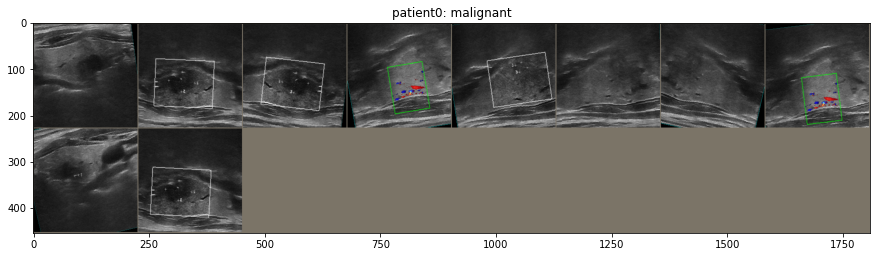

In [84]:
class_names = {0: "benign", 1: "malignant"}
image0, label0, patient0 = dataset[0]  # select images from patient0
# Make a grid from patient0
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image0)
imshow(out, title="patient0" + ": " + class_names[label0])

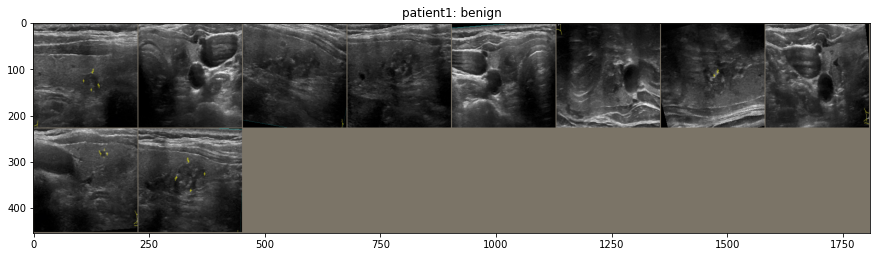

In [85]:
class_names = {0: "benign", 1: "malignant"}
image1, label1, patient1 = dataset[1]  # select images from patient0
# Make a grid from patient1
plt.figure(figsize=[15, 15])
out = torchvision.utils.make_grid(image1)
imshow(out, title="patient1" + ": " + class_names[label1])

In [88]:
# Check dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=6)
x, y, z=iter(dataloader).__next__()  # check one batch of data
print("x shape: ", x.shape)
print("y: ", y)
print("z: ", z)

x shape:  torch.Size([8, 10, 3, 224, 224])
y:  tensor([1, 0, 0, 1, 1, 0, 0, 0])
z:  ('陆红霞', '丁秀娟', '张文英', '王文宝', '冯华英', '梁仁娥', '胡玉珍', '徐丹利')


In [89]:
for i in tqdm(dataloader):
    continue

  0%|          | 0/76 [00:00<?, ?it/s]

In [8]:
@torch.no_grad()
def eval_process(epoch, model, criterion, dataloader, device, num_bags=5,
                 aggregate="max"):
    assert aggregate == "mean" or aggregate == "max", "aggregate must be mean or max"
    print("Epoch %d Validation......" % epoch)
    cpu_device = torch.device("cpu")
    model.eval()
    preds_pool = []
    running_loss_pool = []
    for i in range(num_bags):
        print("sampling the %d bag......" % (i+1))
        preds = []
        labels = []
        running_loss = 0.
        for images, targets, _ in tqdm(dataloader):
            images = images.to(device)
            labels.extend(targets.numpy().tolist())
            targets = targets.to(device)
            logits = model(images)
            preds.extend(logits.cpu().numpy()[:, -1].tolist())
            loss = criterion(logits, targets)
            running_loss += loss.item() * images.size(0)

        preds_pool.append(preds)
        this_bag_loss = running_loss / len(dataloader.dataset)
        running_loss_pool.append(this_bag_loss)
        print("bag val loss: %.4f" % this_bag_loss)
    
    final_loss_mean = np.mean(running_loss_pool)
    print("Val loss: %.4f" % final_loss_mean)
    preds_pool_array = np.stack(preds_pool)
    if aggregate == "mean":
        final_logits = np.mean(preds_pool_array, axis=0)
    elif aggregate == "max":
        final_logits = np.max(preds_pool_array, axis=0)
    auc_score = roc_auc_score(labels, final_logits)
    print("Val AUC: %.4f" % auc_score)
    return auc_score, final_loss_mean

In [9]:
@torch.no_grad()
def test_process(model, criterion, dataloader, device, num_bags=5,
                 aggregate="max"):
    assert aggregate == "mean" or aggregate == "max", "aggregate must be mean or max"
    cpu_device = torch.device("cpu")
    model.eval()
    preds_pool = []
    preds_probs_pool = []
    running_loss_pool = []
    all_slide_names = []
    for i in range(num_bags):
        print("sampling the %d bag......" % (i+1))
        preds = []
        preds_probs = []
        labels = []
        running_loss = 0.
        try:
            for ind, (images, targets, patient_names) in enumerate(tqdm(dataloader)):
                images = images.to(device)
                labels.extend(targets.numpy().tolist())
                targets = targets.to(device)
                logits = model(images)
                pred_probs = torch.softmax(logits, 1)
                preds_probs.extend(pred_probs.cpu().numpy()[:, -1].tolist())
                preds.extend(logits.cpu().numpy()[:, -1].tolist())
                loss = criterion(logits, targets)
                running_loss += loss.item() * images.size(0)
                if i == 0:
                    all_slide_names.extend(patient_names)
        except RuntimeError:
            print("RuntimeError")
            print(slide_names)
            import ipdb;ipdb.set_trace()
            break
        except TypeError:
            print(patient_names)
            print("TypeError")
            import ipdb;ipdb.set_trace()
            break

        preds_pool.append(preds)
        preds_probs_pool.append(preds_probs)
        this_bag_loss = running_loss / len(dataloader.dataset)
        running_loss_pool.append(this_bag_loss)
        print("bag test loss: %.4f" % this_bag_loss)
    
    final_loss_mean = np.mean(running_loss_pool)
    print("Test loss: %.4f" % final_loss_mean)
    preds_pool_array = np.stack(preds_pool)
    preds_probs_pool_array = np.stack(preds_probs_pool)
    if aggregate == "mean":
        final_logits = np.mean(preds_pool_array, axis=0)
        final_probs = np.mean(preds_probs_pool_array, axis=0)
    elif aggregate == "max":
        final_logits = np.max(preds_pool_array, axis=0)
        final_probs = np.max(preds_probs_pool_array, axis=0)
    auc_score = roc_auc_score(labels, final_logits)
    average_precision = average_precision_score(labels, final_logits)
    print("Test AUC: %.4f" % auc_score)
    print("Test AP: %.4f" % average_precision)
    # plot_roc_curve(labels, final_logits)
    # plot_pr_curve(labels, final_logits)
    df = pd.DataFrame({"slide_name": all_slide_names,
                       "prob": final_probs,
                       "logit": final_logits,
                       "label": labels})

    return auc_score, final_loss_mean, df

In [10]:
def train_process(model, criterion, optimizer, lr_sche, dataloaders,
                  num_epochs, use_tensorboard, device,
                  save_model_path, record_iter, writer=None):
    model.train()

    best_score = 0.0
    best_state_dict = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        lr_scheduler = None
        running_loss = 0.0
        print("====Epoch{0}====".format(epoch))
        if epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, len(dataloaders["train"]) - 1)
            lr_scheduler = warmup_lr_scheduler(
                optimizer, warmup_iters, warmup_factor
            )

        for i, (images, targets, _) in enumerate(tqdm(dataloaders["train"])):
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, targets)

            if not math.isfinite(loss.item()):
                print("Loss is {}, stopping training".format(loss.item()))
                sys.exit(1)

            loss.backward()
            optimizer.step()
            if lr_scheduler is not None:
                lr_scheduler.step()

            running_loss += loss.item() * images.size(0)

            lr = optimizer.param_groups[0]["lr"]

            if (i + 1) % record_iter == 0:
                to_date_cases = (i + 1) * images.size(0)
                tmp_loss = running_loss / to_date_cases
                print("Epoch{0} loss:{1:.4f}".format(epoch, tmp_loss))
                
                if use_tensorboard:
                    writer.add_scalar("Train loss",
                                      tmp_loss,
                                      epoch * len(dataloaders["train"]) + i)
                    writer.add_scalar("lr", lr,
                                      epoch * len(dataloaders["train"]) + i)

        val_auc, val_loss = eval_process(
            epoch, model, criterion, dataloaders["val"], device
        )
        if lr_sche is not None:
            lr_sche.step()

        if val_auc > best_score:
            best_score = val_auc
            best_state_dict = copy.deepcopy(model.state_dict())

        if use_tensorboard:
            writer.add_scalar(
                "validataion AUC", val_auc, global_step=epoch
            )
            writer.add_scalar(
                "validation loss", val_loss, global_step=epoch
            )

        model.train()

    print("Training Done!")
    print("Best Valid AUC: %.4f" % best_score)
    torch.save(best_state_dict, save_model_path)

    print("========Start Testing========")
    model.load_state_dict(best_state_dict)
    test_auc, test_loss, df = test_process(
        model, criterion, dataloaders["test"], device
    )
    if use_tensorboard:
        writer.add_scalar("Test AUC", test_auc, global_step=0)
        writer.close()

In [11]:
# function for k-fold cross validation training procedure
def train_thynet(k, split_dir, save_model_dir,
                 train_trans, val_trans, batch_size,
                 num_workers, C2, D, device, lr,
                 momentum, weight_decay, gamma,
                 logdir, num_epochs, use_tensorboard,
                 record_iter, N=10):
    test_csv1_path = os.path.join(split_dir, "test_image.csv")
    test_csv2_path = os.path.join(split_dir, "test_case.csv")
    print("Building test dataset...")
    test_dataset = ThyDataset2(csv1_path=test_csv1_path, csv2_path=test_csv2_path,
                              transform=val_trans, N=N)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=num_workers)
    for i in range(k):
        print("====Starting Fold %d====" % (i + 1))
        print("Building fold %d train dataset..." % (i + 1))
        train_csv1_path = os.path.join(split_dir, "train_image_split_" + str(i) + ".csv")
        train_csv2_path = os.path.join(split_dir, "train_case_split_" + str(i) + ".csv")
        train_dataset = ThyDataset2(csv1_path=train_csv1_path, csv2_path=train_csv2_path,
                                   transform=train_trans, N=N)
        print("Building fold %d val dataset..." % (i + 1))
        val_csv1_path = os.path.join(split_dir, "val_image_split_" + str(i) + ".csv")
        val_csv2_path = os.path.join(split_dir, "val_case_split_" + str(i) + ".csv")
        val_dataset = ThyDataset2(csv1_path=val_csv1_path, csv2_path=val_csv2_path,
                                 transform=val_trans, N=N)
        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=num_workers,
                                  drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                                num_workers=num_workers)
        dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}
        print("Dataset Done...")
        
        print("Preparing Model...")
        thynet = ThyNet(C2=C2, D=D, batch_size=batch_size)
        thynet = thynet.to(device)
        #if torch.cuda.device_count() > 1:
            #thynet = nn.DataParallel(thynet)
        print("Model Done...")
        
        params = [p for p in thynet.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr,
                                   momentum=momentum,
                                   weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75],
                                                            gamma=gamma)
        criterion = nn.CrossEntropyLoss()
        print("Start Training...")
        os.makedirs(logdir, exist_ok=True)
        writer = SummaryWriter(logdir)
        os.makedirs(save_model_dir, exist_ok=True)
        save_model_path = os.path.join(save_model_dir, "thynet_fold_%d.pth" % (i + 1))
        train_process(model=thynet, criterion=criterion, optimizer=optimizer,
                      lr_sche=lr_scheduler, dataloaders=dataloaders, writer=writer,
                      num_epochs=num_epochs, use_tensorboard=use_tensorboard,
                      device=device, save_model_path=save_model_path,
                      record_iter=record_iter)
        
    print("====Training Done====")

In [12]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [13]:
# settings
k = 5
split_dir = "./split/"
save_model_dir = "./result/sampled/"
train_trans = transform
val_trans = val_transform
batch_size = 8
num_workers = 12
C2 = 128
D = 256
device = device
lr = 0.001
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
logdir = "./logs/sampled/"
num_epochs = 100
use_tensorboard = True
record_iter = 10
N = 10

In [16]:
train_thynet(k, split_dir, save_model_dir,
             train_trans, val_trans, batch_size,
             num_workers, C2, D, device, lr,
             momentum, weight_decay, gamma,
             logdir, num_epochs, use_tensorboard,
             record_iter, N)

Building test dataset...
====Starting Fold 1====
Building fold 1 train dataset...
Building fold 1 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch0 loss:0.7217
Epoch0 loss:0.8169
Epoch0 loss:1.0378
Epoch0 loss:1.0366
Epoch0 loss:0.9755
Epoch 0 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1526
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1526
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1526
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1526
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1526
Val loss: 1.1526
Val AUC: 0.5711
====Epoch1====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch1 loss:1.0951
Epoch1 loss:0.8919
Epoch1 loss:0.8166
Epoch1 loss:0.8003
Epoch1 loss:0.7734
Epoch 1 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7659
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7659
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7659
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7659
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7659
Val loss: 0.7659
Val AUC: 0.5116
====Epoch2====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch2 loss:0.6389
Epoch2 loss:0.6158
Epoch2 loss:0.6288
Epoch2 loss:0.6447
Epoch2 loss:0.6492
Epoch 2 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6646
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6646
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6646
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6646
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6646
Val loss: 0.6646
Val AUC: 0.5441
====Epoch3====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch3 loss:0.5979
Epoch3 loss:0.6165
Epoch3 loss:0.6163
Epoch3 loss:0.6312
Epoch3 loss:0.6284
Epoch 3 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6506
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6506
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6506
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6506
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6506
Val loss: 0.6506
Val AUC: 0.6310
====Epoch4====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch4 loss:0.6474
Epoch4 loss:0.5958
Epoch4 loss:0.6184
Epoch4 loss:0.6228
Epoch4 loss:0.6305
Epoch 4 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6385
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6385
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6385
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6385
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6385
Val loss: 0.6385
Val AUC: 0.5910
====Epoch5====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch5 loss:0.5950
Epoch5 loss:0.5858
Epoch5 loss:0.5395
Epoch5 loss:0.5736
Epoch5 loss:0.5977
Epoch 5 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6786
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6786
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6786
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6786
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6786
Val loss: 0.6786
Val AUC: 0.5641
====Epoch6====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch6 loss:0.6616
Epoch6 loss:0.6285
Epoch6 loss:0.5959
Epoch6 loss:0.6141
Epoch6 loss:0.6163
Epoch 6 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6424
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6424
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6424
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6424
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6424
Val loss: 0.6424
Val AUC: 0.6089
====Epoch7====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch7 loss:0.5918
Epoch7 loss:0.6185
Epoch7 loss:0.6379
Epoch7 loss:0.6225
Epoch7 loss:0.6139
Epoch 7 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7265
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7265
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7265
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7265
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7265
Val loss: 0.7265
Val AUC: 0.6306
====Epoch8====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch8 loss:0.6355
Epoch8 loss:0.6053
Epoch8 loss:0.5921
Epoch8 loss:0.5799
Epoch8 loss:0.5782
Epoch 8 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6218
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6218
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6218
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6218
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6218
Val loss: 0.6218
Val AUC: 0.6408
====Epoch9====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch9 loss:0.5527
Epoch9 loss:0.5851
Epoch9 loss:0.5832
Epoch9 loss:0.5690
Epoch9 loss:0.5682
Epoch 9 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6291
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6291
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6291
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6291
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6291
Val loss: 0.6291
Val AUC: 0.6835
====Epoch10====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch10 loss:0.5269
Epoch10 loss:0.4977
Epoch10 loss:0.5021
Epoch10 loss:0.5496
Epoch10 loss:0.5616
Epoch 10 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6375
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6375
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6375
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6375
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6375
Val loss: 0.6375
Val AUC: 0.6390
====Epoch11====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch11 loss:0.5306
Epoch11 loss:0.5579
Epoch11 loss:0.5401
Epoch11 loss:0.5442
Epoch11 loss:0.5525
Epoch 11 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5787
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5787
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5787
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5787
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5787
Val loss: 0.5787
Val AUC: 0.7311
====Epoch12====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch12 loss:0.4533
Epoch12 loss:0.4792
Epoch12 loss:0.4729
Epoch12 loss:0.4924
Epoch12 loss:0.5062
Epoch 12 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6488
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6488
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6488
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6488
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6488
Val loss: 0.6488
Val AUC: 0.6950
====Epoch13====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch13 loss:0.4412
Epoch13 loss:0.3924
Epoch13 loss:0.4609
Epoch13 loss:0.4765
Epoch13 loss:0.4857
Epoch 13 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8846
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8846
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8846
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8846
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8846
Val loss: 0.8846
Val AUC: 0.7430
====Epoch14====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch14 loss:0.5395
Epoch14 loss:0.5161
Epoch14 loss:0.5326
Epoch14 loss:0.5224
Epoch14 loss:0.5058
Epoch 14 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5698
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5698
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5698
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5698
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5698
Val loss: 0.5698
Val AUC: 0.7395
====Epoch15====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch15 loss:0.5597
Epoch15 loss:0.5422
Epoch15 loss:0.5620
Epoch15 loss:0.5670
Epoch15 loss:0.5474
Epoch 15 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7276
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7276
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7276
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7276
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7276
Val loss: 0.7276
Val AUC: 0.7223
====Epoch16====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch16 loss:0.4512
Epoch16 loss:0.5256
Epoch16 loss:0.5378
Epoch16 loss:0.5142
Epoch16 loss:0.5282
Epoch 16 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8969
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8969
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8969
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8969
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8969
Val loss: 0.8969
Val AUC: 0.6544
====Epoch17====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch17 loss:0.4769
Epoch17 loss:0.4910
Epoch17 loss:0.4500
Epoch17 loss:0.4443
Epoch17 loss:0.4634
Epoch 17 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7616
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7616
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7616
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7616
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7616
Val loss: 0.7616
Val AUC: 0.6947
====Epoch18====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch18 loss:0.4432
Epoch18 loss:0.4743
Epoch18 loss:0.4992
Epoch18 loss:0.4922
Epoch18 loss:0.4908
Epoch 18 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5915
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5915
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5915
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5915
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.5915
Val loss: 0.5915
Val AUC: 0.7532
====Epoch19====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch19 loss:0.4130
Epoch19 loss:0.3784
Epoch19 loss:0.4151
Epoch19 loss:0.4205
Epoch19 loss:0.4504
Epoch 19 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6490
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6490
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6490
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6490
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6490
Val loss: 0.6490
Val AUC: 0.6520
====Epoch20====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch20 loss:0.4577
Epoch20 loss:0.4385
Epoch20 loss:0.4325
Epoch20 loss:0.4390
Epoch20 loss:0.4114
Epoch 20 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2886
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2886
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2886
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2886
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2886
Val loss: 1.2886
Val AUC: 0.6649
====Epoch21====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch21 loss:0.6040
Epoch21 loss:0.5616
Epoch21 loss:0.5104
Epoch21 loss:0.4803
Epoch21 loss:0.5114
Epoch 21 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6206
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6206
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6206
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6206
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6206
Val loss: 0.6206
Val AUC: 0.7609
====Epoch22====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch22 loss:0.3876
Epoch22 loss:0.3976
Epoch22 loss:0.4477
Epoch22 loss:0.4187
Epoch22 loss:0.4255
Epoch 22 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8276
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8276
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8276
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8276
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8276
Val loss: 0.8276
Val AUC: 0.6814
====Epoch23====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch23 loss:0.4618
Epoch23 loss:0.4792
Epoch23 loss:0.4168
Epoch23 loss:0.4118
Epoch23 loss:0.4159
Epoch 23 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7156
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7156
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7156
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7156
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7156
Val loss: 0.7156
Val AUC: 0.6922
====Epoch24====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch24 loss:0.3244
Epoch24 loss:0.3102
Epoch24 loss:0.3398
Epoch24 loss:0.3817
Epoch24 loss:0.4066
Epoch 24 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6584
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6584
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6584
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6584
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6584
Val loss: 0.6584
Val AUC: 0.6817
====Epoch25====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch25 loss:0.4535
Epoch25 loss:0.4779
Epoch25 loss:0.4833
Epoch25 loss:0.4601
Epoch25 loss:0.4491
Epoch 25 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9927
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9927
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9927
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9927
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9927
Val loss: 0.9927
Val AUC: 0.6940
====Epoch26====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch26 loss:0.3848
Epoch26 loss:0.3687
Epoch26 loss:0.3562
Epoch26 loss:0.3921
Epoch26 loss:0.3889
Epoch 26 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1246
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1246
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1246
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1246
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1246
Val loss: 1.1246
Val AUC: 0.6590
====Epoch27====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch27 loss:0.4094
Epoch27 loss:0.4046
Epoch27 loss:0.4108
Epoch27 loss:0.4060
Epoch27 loss:0.3929
Epoch 27 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7152
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7152
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7152
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7152
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7152
Val loss: 0.7152
Val AUC: 0.6884
====Epoch28====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch28 loss:0.5013
Epoch28 loss:0.4072
Epoch28 loss:0.4328
Epoch28 loss:0.4176
Epoch28 loss:0.4064
Epoch 28 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8038
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8038
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8038
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8038
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8038
Val loss: 0.8038
Val AUC: 0.7230
====Epoch29====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch29 loss:0.4191
Epoch29 loss:0.3460
Epoch29 loss:0.3243
Epoch29 loss:0.3467
Epoch29 loss:0.3711
Epoch 29 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8296
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8296
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8296
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8296
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8296
Val loss: 0.8296
Val AUC: 0.6674
====Epoch30====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch30 loss:0.3306
Epoch30 loss:0.3596
Epoch30 loss:0.3803
Epoch30 loss:0.4064
Epoch30 loss:0.4060
Epoch 30 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7857
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7857
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7857
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7857
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7857
Val loss: 0.7857
Val AUC: 0.6660
====Epoch31====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch31 loss:0.3243
Epoch31 loss:0.3382
Epoch31 loss:0.3176
Epoch31 loss:0.3173
Epoch31 loss:0.3411
Epoch 31 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 20.3918
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 20.3918
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 20.3918
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 20.3918
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 20.3918
Val loss: 20.3918
Val AUC: 0.5875
====Epoch32====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch32 loss:0.3532
Epoch32 loss:0.3549
Epoch32 loss:0.3770
Epoch32 loss:0.3871
Epoch32 loss:0.4099
Epoch 32 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6435
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6435
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6435
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6435
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6435
Val loss: 0.6435
Val AUC: 0.6730
====Epoch33====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch33 loss:0.4131
Epoch33 loss:0.4008
Epoch33 loss:0.4603
Epoch33 loss:0.4678
Epoch33 loss:0.4810
Epoch 33 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6589
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6589
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6589
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6589
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.6589
Val loss: 0.6589
Val AUC: 0.6565
====Epoch34====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch34 loss:0.3770
Epoch34 loss:0.3771
Epoch34 loss:0.3809
Epoch34 loss:0.4014
Epoch34 loss:0.4255
Epoch 34 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7142
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7142
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7142
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7142
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7142
Val loss: 0.7142
Val AUC: 0.6408
====Epoch35====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch35 loss:0.3669
Epoch35 loss:0.3375
Epoch35 loss:0.3199
Epoch35 loss:0.3333
Epoch35 loss:0.3802
Epoch 35 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.9288
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.9288
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.9288
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.9288
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.9288
Val loss: 1.9288
Val AUC: 0.6842
====Epoch36====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch36 loss:0.3289
Epoch36 loss:0.4224
Epoch36 loss:0.4078
Epoch36 loss:0.3898
Epoch36 loss:0.3943
Epoch 36 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1093
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1093
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1093
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1093
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1093
Val loss: 1.1093
Val AUC: 0.6471
====Epoch37====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch37 loss:0.3257
Epoch37 loss:0.2915
Epoch37 loss:0.3054
Epoch37 loss:0.3290
Epoch37 loss:0.3679
Epoch 37 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3134
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3134
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3134
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3134
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3134
Val loss: 1.3134
Val AUC: 0.7269
====Epoch38====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch38 loss:0.3378
Epoch38 loss:0.3024
Epoch38 loss:0.3426
Epoch38 loss:0.3269
Epoch38 loss:0.3748
Epoch 38 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.4066
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.4066
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.4066
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.4066
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.4066
Val loss: 2.4066
Val AUC: 0.6229
====Epoch39====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch39 loss:0.4771
Epoch39 loss:0.4241
Epoch39 loss:0.3939
Epoch39 loss:0.3984
Epoch39 loss:0.3906
Epoch 39 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0897
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0897
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0897
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0897
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0897
Val loss: 1.0897
Val AUC: 0.6264
====Epoch40====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch40 loss:0.3028
Epoch40 loss:0.2916
Epoch40 loss:0.3036
Epoch40 loss:0.3390
Epoch40 loss:0.3851
Epoch 40 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 6.1570
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 6.1570
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 6.1570
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 6.1570
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 6.1570
Val loss: 6.1570
Val AUC: 0.6425
====Epoch41====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch41 loss:0.4546
Epoch41 loss:0.4507
Epoch41 loss:0.4171
Epoch41 loss:0.4155
Epoch41 loss:0.4057
Epoch 41 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8212
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8212
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8212
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8212
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8212
Val loss: 0.8212
Val AUC: 0.6856
====Epoch42====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch42 loss:0.4524
Epoch42 loss:0.4258
Epoch42 loss:0.3887
Epoch42 loss:0.3829
Epoch42 loss:0.4170
Epoch 42 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.1596
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.1596
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.1596
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.1596
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 2.1596
Val loss: 2.1596
Val AUC: 0.6579
====Epoch43====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch43 loss:0.3703
Epoch43 loss:0.3934
Epoch43 loss:0.3782
Epoch43 loss:0.3863
Epoch43 loss:0.4120
Epoch 43 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 9.4940
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 9.4940
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 9.4940
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 9.4940
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 9.4940
Val loss: 9.4940
Val AUC: 0.5581
====Epoch44====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch44 loss:0.3255
Epoch44 loss:0.3208
Epoch44 loss:0.3285
Epoch44 loss:0.3039
Epoch44 loss:0.3314
Epoch 44 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1196
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1196
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1196
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1196
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1196
Val loss: 1.1196
Val AUC: 0.6796
====Epoch45====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch45 loss:0.3473
Epoch45 loss:0.3443
Epoch45 loss:0.3455
Epoch45 loss:0.3525
Epoch45 loss:0.3297
Epoch 45 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0107
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0107
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0107
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0107
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0107
Val loss: 1.0107
Val AUC: 0.6509
====Epoch46====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch46 loss:0.1733
Epoch46 loss:0.1890
Epoch46 loss:0.2077
Epoch46 loss:0.2993
Epoch46 loss:0.3112
Epoch 46 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1519
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1519
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1519
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1519
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1519
Val loss: 1.1519
Val AUC: 0.6719
====Epoch47====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch47 loss:0.3109
Epoch47 loss:0.2992
Epoch47 loss:0.2813
Epoch47 loss:0.2942
Epoch47 loss:0.2833
Epoch 47 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7868
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7868
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7868
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7868
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.7868
Val loss: 0.7868
Val AUC: 0.7213
====Epoch48====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch48 loss:0.2150
Epoch48 loss:0.3411
Epoch48 loss:0.3232
Epoch48 loss:0.3310
Epoch48 loss:0.3531
Epoch 48 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3370
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3370
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3370
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3370
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3370
Val loss: 1.3370
Val AUC: 0.6838
====Epoch49====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch49 loss:0.3946
Epoch49 loss:0.4220
Epoch49 loss:0.4221
Epoch49 loss:0.4184
Epoch49 loss:0.3844
Epoch 49 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8163
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8163
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8163
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8163
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8163
Val loss: 0.8163
Val AUC: 0.6992
====Epoch50====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch50 loss:0.2679
Epoch50 loss:0.2708
Epoch50 loss:0.2542
Epoch50 loss:0.2397
Epoch50 loss:0.2412
Epoch 50 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8320
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8320
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8320
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8320
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8320
Val loss: 0.8320
Val AUC: 0.7230
====Epoch51====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch51 loss:0.2001
Epoch51 loss:0.2094
Epoch51 loss:0.2046
Epoch51 loss:0.2088
Epoch51 loss:0.2226
Epoch 51 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8299
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8299
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8299
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8299
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8299
Val loss: 0.8299
Val AUC: 0.7230
====Epoch52====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch52 loss:0.1464
Epoch52 loss:0.1676
Epoch52 loss:0.1861
Epoch52 loss:0.1991
Epoch52 loss:0.1847
Epoch 52 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8743
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8743
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8743
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8743
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8743
Val loss: 0.8743
Val AUC: 0.7227
====Epoch53====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch53 loss:0.1463
Epoch53 loss:0.1478
Epoch53 loss:0.1713
Epoch53 loss:0.1564
Epoch53 loss:0.1821
Epoch 53 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8631
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8631
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8631
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8631
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.8631
Val loss: 0.8631
Val AUC: 0.7237
====Epoch54====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch54 loss:0.1547
Epoch54 loss:0.1787
Epoch54 loss:0.1865
Epoch54 loss:0.1739
Epoch54 loss:0.1689
Epoch 54 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9503
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9503
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9503
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9503
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9503
Val loss: 0.9503
Val AUC: 0.7227
====Epoch55====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch55 loss:0.2036
Epoch55 loss:0.1761
Epoch55 loss:0.1524
Epoch55 loss:0.1721
Epoch55 loss:0.1697
Epoch 55 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9031
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9031
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9031
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9031
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9031
Val loss: 0.9031
Val AUC: 0.7241
====Epoch56====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch56 loss:0.1484
Epoch56 loss:0.1600
Epoch56 loss:0.1515
Epoch56 loss:0.1569
Epoch56 loss:0.1524
Epoch 56 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9689
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9689
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9689
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9689
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9689
Val loss: 0.9689
Val AUC: 0.7269
====Epoch57====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch57 loss:0.1203
Epoch57 loss:0.1249
Epoch57 loss:0.1450
Epoch57 loss:0.1332
Epoch57 loss:0.1285
Epoch 57 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9124
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9124
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9124
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9124
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 0.9124
Val loss: 0.9124
Val AUC: 0.7230
====Epoch58====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch58 loss:0.1256
Epoch58 loss:0.1069
Epoch58 loss:0.0966
Epoch58 loss:0.0966
Epoch58 loss:0.1099
Epoch 58 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0310
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0310
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0310
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0310
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0310
Val loss: 1.0310
Val AUC: 0.7220
====Epoch59====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch59 loss:0.1003
Epoch59 loss:0.1361
Epoch59 loss:0.1325
Epoch59 loss:0.1305
Epoch59 loss:0.1335
Epoch 59 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2207
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2207
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2207
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2207
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2207
Val loss: 1.2207
Val AUC: 0.7244
====Epoch60====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch60 loss:0.2360
Epoch60 loss:0.1672
Epoch60 loss:0.1366
Epoch60 loss:0.1239
Epoch60 loss:0.1180
Epoch 60 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0201
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0201
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0201
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0201
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0201
Val loss: 1.0201
Val AUC: 0.7199
====Epoch61====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch61 loss:0.1283
Epoch61 loss:0.1064
Epoch61 loss:0.1307
Epoch61 loss:0.1308
Epoch61 loss:0.1281
Epoch 61 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1188
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1188
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1188
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1188
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1188
Val loss: 1.1188
Val AUC: 0.7188
====Epoch62====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch62 loss:0.1227
Epoch62 loss:0.1613
Epoch62 loss:0.1638
Epoch62 loss:0.1637
Epoch62 loss:0.1541
Epoch 62 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0088
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0088
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0088
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0088
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0088
Val loss: 1.0088
Val AUC: 0.7160
====Epoch63====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch63 loss:0.0934
Epoch63 loss:0.0789
Epoch63 loss:0.0917
Epoch63 loss:0.1231
Epoch63 loss:0.1092
Epoch 63 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1769
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1769
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1769
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1769
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1769
Val loss: 1.1769
Val AUC: 0.7069
====Epoch64====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch64 loss:0.0862
Epoch64 loss:0.0907
Epoch64 loss:0.1107
Epoch64 loss:0.1063
Epoch64 loss:0.1238
Epoch 64 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0717
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0717
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0717
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0717
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0717
Val loss: 1.0717
Val AUC: 0.7160
====Epoch65====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch65 loss:0.0720
Epoch65 loss:0.0923
Epoch65 loss:0.1132
Epoch65 loss:0.1206
Epoch65 loss:0.1167
Epoch 65 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0710
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0710
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0710
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0710
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0710
Val loss: 1.0710
Val AUC: 0.7076
====Epoch66====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch66 loss:0.1067
Epoch66 loss:0.1248
Epoch66 loss:0.1052
Epoch66 loss:0.1008
Epoch66 loss:0.0996
Epoch 66 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0594
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0594
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0594
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0594
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.0594
Val loss: 1.0594
Val AUC: 0.7125
====Epoch67====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch67 loss:0.0725
Epoch67 loss:0.0465
Epoch67 loss:0.0796
Epoch67 loss:0.0766
Epoch67 loss:0.0751
Epoch 67 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2785
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2785
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2785
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2785
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2785
Val loss: 1.2785
Val AUC: 0.7115
====Epoch68====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch68 loss:0.0866
Epoch68 loss:0.1138
Epoch68 loss:0.0953
Epoch68 loss:0.0889
Epoch68 loss:0.0813
Epoch 68 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2016
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2016
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2016
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2016
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2016
Val loss: 1.2016
Val AUC: 0.7181
====Epoch69====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch69 loss:0.0603
Epoch69 loss:0.1305
Epoch69 loss:0.1125
Epoch69 loss:0.1034
Epoch69 loss:0.0984
Epoch 69 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1291
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1291
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1291
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1291
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1291
Val loss: 1.1291
Val AUC: 0.7223
====Epoch70====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch70 loss:0.1278
Epoch70 loss:0.0952
Epoch70 loss:0.0856
Epoch70 loss:0.1155
Epoch70 loss:0.1143
Epoch 70 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1974
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1974
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1974
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1974
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1974
Val loss: 1.1974
Val AUC: 0.7185
====Epoch71====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch71 loss:0.0858
Epoch71 loss:0.0884
Epoch71 loss:0.0906
Epoch71 loss:0.0837
Epoch71 loss:0.0835
Epoch 71 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
Val loss: 1.1929
Val AUC: 0.7178
====Epoch72====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch72 loss:0.0401
Epoch72 loss:0.0961
Epoch72 loss:0.0922
Epoch72 loss:0.0796
Epoch72 loss:0.0776
Epoch 72 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2694
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2694
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2694
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2694
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2694
Val loss: 1.2694
Val AUC: 0.7104
====Epoch73====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch73 loss:0.0367
Epoch73 loss:0.0965
Epoch73 loss:0.0968
Epoch73 loss:0.0843
Epoch73 loss:0.0929
Epoch 73 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2238
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2238
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2238
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2238
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2238
Val loss: 1.2238
Val AUC: 0.7227
====Epoch74====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch74 loss:0.0656
Epoch74 loss:0.0642
Epoch74 loss:0.0535
Epoch74 loss:0.0552
Epoch74 loss:0.0630
Epoch 74 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2708
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2708
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2708
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2708
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2708
Val loss: 1.2708
Val AUC: 0.7276
====Epoch75====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch75 loss:0.0712
Epoch75 loss:0.0946
Epoch75 loss:0.0766
Epoch75 loss:0.0754
Epoch75 loss:0.0785
Epoch 75 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2232
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2232
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2232
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2232
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2232
Val loss: 1.2232
Val AUC: 0.7307
====Epoch76====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch76 loss:0.0538
Epoch76 loss:0.0717
Epoch76 loss:0.0920
Epoch76 loss:0.0809
Epoch76 loss:0.1175
Epoch 76 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2839
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2839
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2839
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2839
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2839
Val loss: 1.2839
Val AUC: 0.7321
====Epoch77====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch77 loss:0.1062
Epoch77 loss:0.1186
Epoch77 loss:0.1082
Epoch77 loss:0.1073
Epoch77 loss:0.1008
Epoch 77 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1908
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1908
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1908
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1908
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1908
Val loss: 1.1908
Val AUC: 0.7342
====Epoch78====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch78 loss:0.1090
Epoch78 loss:0.0693
Epoch78 loss:0.0618
Epoch78 loss:0.0741
Epoch78 loss:0.0647
Epoch 78 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2257
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2257
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2257
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2257
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2257
Val loss: 1.2257
Val AUC: 0.7307
====Epoch79====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch79 loss:0.0654
Epoch79 loss:0.1158
Epoch79 loss:0.1033
Epoch79 loss:0.0865
Epoch79 loss:0.1031
Epoch 79 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1929
Val loss: 1.1929
Val AUC: 0.7342
====Epoch80====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch80 loss:0.1292
Epoch80 loss:0.1093
Epoch80 loss:0.0889
Epoch80 loss:0.0787
Epoch80 loss:0.0817
Epoch 80 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3080
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3080
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3080
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3080
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3080
Val loss: 1.3080
Val AUC: 0.7332
====Epoch81====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch81 loss:0.0622
Epoch81 loss:0.0900
Epoch81 loss:0.0850
Epoch81 loss:0.0889
Epoch81 loss:0.0789
Epoch 81 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2753
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2753
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2753
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2753
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2753
Val loss: 1.2753
Val AUC: 0.7374
====Epoch82====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch82 loss:0.0788
Epoch82 loss:0.0758
Epoch82 loss:0.0638
Epoch82 loss:0.0543
Epoch82 loss:0.0475
Epoch 82 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2163
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2163
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2163
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2163
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2163
Val loss: 1.2163
Val AUC: 0.7276
====Epoch83====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch83 loss:0.0379
Epoch83 loss:0.0655
Epoch83 loss:0.0890
Epoch83 loss:0.0801
Epoch83 loss:0.1107
Epoch 83 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2516
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2516
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2516
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2516
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2516
Val loss: 1.2516
Val AUC: 0.7307
====Epoch84====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch84 loss:0.0173
Epoch84 loss:0.1047
Epoch84 loss:0.0873
Epoch84 loss:0.0728
Epoch84 loss:0.0812
Epoch 84 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2111
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2111
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2111
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2111
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2111
Val loss: 1.2111
Val AUC: 0.7349
====Epoch85====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch85 loss:0.0606
Epoch85 loss:0.0826
Epoch85 loss:0.0855
Epoch85 loss:0.0890
Epoch85 loss:0.0853
Epoch 85 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2143
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2143
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2143
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2143
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2143
Val loss: 1.2143
Val AUC: 0.7318
====Epoch86====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch86 loss:0.0753
Epoch86 loss:0.1129
Epoch86 loss:0.0951
Epoch86 loss:0.0960
Epoch86 loss:0.0935
Epoch 86 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2109
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2109
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2109
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2109
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2109
Val loss: 1.2109
Val AUC: 0.7367
====Epoch87====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch87 loss:0.0801
Epoch87 loss:0.0655
Epoch87 loss:0.0626
Epoch87 loss:0.0520
Epoch87 loss:0.0575
Epoch 87 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1648
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1648
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1648
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1648
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1648
Val loss: 1.1648
Val AUC: 0.7335
====Epoch88====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch88 loss:0.0397
Epoch88 loss:0.0451
Epoch88 loss:0.0630
Epoch88 loss:0.0552
Epoch88 loss:0.0507
Epoch 88 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2058
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2058
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2058
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2058
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2058
Val loss: 1.2058
Val AUC: 0.7321
====Epoch89====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch89 loss:0.0744
Epoch89 loss:0.0715
Epoch89 loss:0.0548
Epoch89 loss:0.0635
Epoch89 loss:0.0701
Epoch 89 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2200
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2200
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2200
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2200
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2200
Val loss: 1.2200
Val AUC: 0.7311
====Epoch90====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch90 loss:0.0516
Epoch90 loss:0.0402
Epoch90 loss:0.0406
Epoch90 loss:0.0610
Epoch90 loss:0.0578
Epoch 90 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2442
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2442
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2442
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2442
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2442
Val loss: 1.2442
Val AUC: 0.7342
====Epoch91====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch91 loss:0.1397
Epoch91 loss:0.0880
Epoch91 loss:0.0851
Epoch91 loss:0.0850
Epoch91 loss:0.0924
Epoch 91 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1813
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1813
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1813
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1813
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1813
Val loss: 1.1813
Val AUC: 0.7290
====Epoch92====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch92 loss:0.0289
Epoch92 loss:0.0373
Epoch92 loss:0.0508
Epoch92 loss:0.0626
Epoch92 loss:0.0595
Epoch 92 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2615
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2615
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2615
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2615
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2615
Val loss: 1.2615
Val AUC: 0.7258
====Epoch93====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch93 loss:0.0885
Epoch93 loss:0.0622
Epoch93 loss:0.0506
Epoch93 loss:0.0457
Epoch93 loss:0.0533
Epoch 93 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1910
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1910
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1910
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1910
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.1910
Val loss: 1.1910
Val AUC: 0.7290
====Epoch94====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch94 loss:0.0595
Epoch94 loss:0.1437
Epoch94 loss:0.1204
Epoch94 loss:0.1193
Epoch94 loss:0.1108
Epoch 94 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2458
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2458
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2458
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2458
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2458
Val loss: 1.2458
Val AUC: 0.7332
====Epoch95====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch95 loss:0.2240
Epoch95 loss:0.1586
Epoch95 loss:0.1165
Epoch95 loss:0.0968
Epoch95 loss:0.0867
Epoch 95 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2399
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2399
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2399
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2399
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2399
Val loss: 1.2399
Val AUC: 0.7374
====Epoch96====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch96 loss:0.0545
Epoch96 loss:0.0397
Epoch96 loss:0.0481
Epoch96 loss:0.0501
Epoch96 loss:0.0545
Epoch 96 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2080
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2080
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2080
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2080
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2080
Val loss: 1.2080
Val AUC: 0.7370
====Epoch97====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch97 loss:0.0499
Epoch97 loss:0.0690
Epoch97 loss:0.0538
Epoch97 loss:0.0533
Epoch97 loss:0.0579
Epoch 97 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2259
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2259
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2259
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2259
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2259
Val loss: 1.2259
Val AUC: 0.7349
====Epoch98====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch98 loss:0.0341
Epoch98 loss:0.0458
Epoch98 loss:0.0626
Epoch98 loss:0.0547
Epoch98 loss:0.0470
Epoch 98 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3369
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3369
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3369
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3369
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.3369
Val loss: 1.3369
Val AUC: 0.7314
====Epoch99====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch99 loss:0.0765
Epoch99 loss:0.0668
Epoch99 loss:0.0766
Epoch99 loss:0.0721
Epoch99 loss:0.0668
Epoch 99 Validation......
sampling the 1 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2311
sampling the 2 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2311
sampling the 3 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2311
sampling the 4 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2311
sampling the 5 bag......


  0%|          | 0/110 [00:00<?, ?it/s]

bag val loss: 1.2311
Val loss: 1.2311
Val AUC: 0.7286
Training Done!
Best Valid AUC: 0.7609
========Start Testing========
sampling the 1 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


bag test loss: 0.7785
sampling the 2 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.7785
sampling the 3 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.7785
sampling the 4 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.7785
sampling the 5 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.7785
Test loss: 0.7785
Test AUC: 0.6602
Test AP: 0.7482
====Starting Fold 2====
Building fold 2 train dataset...
Building fold 2 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch0 loss:0.6887
Epoch0 loss:0.7022
Epoch0 loss:0.8323
Epoch0 loss:0.8486
Epoch0 loss:0.8631
Epoch 0 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0777
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0777
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0777
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0777
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0777
Val loss: 1.0777
Val AUC: 0.5591
====Epoch1====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch1 loss:0.7740
Epoch1 loss:0.7399
Epoch1 loss:0.7083
Epoch1 loss:0.7034
Epoch1 loss:0.7050
Epoch 1 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5954
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5954
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5954
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5954
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5954
Val loss: 0.5954
Val AUC: 0.5612
====Epoch2====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch2 loss:0.6463
Epoch2 loss:0.6797
Epoch2 loss:0.6949
Epoch2 loss:0.6903
Epoch2 loss:0.6801
Epoch 2 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5899
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5899
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5899
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5899
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5899
Val loss: 0.5899
Val AUC: 0.5473
====Epoch3====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch3 loss:0.7118
Epoch3 loss:0.7051
Epoch3 loss:0.6878
Epoch3 loss:0.6920
Epoch3 loss:0.6873
Epoch 3 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5793
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5793
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5793
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5793
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5793
Val loss: 0.5793
Val AUC: 0.5987
====Epoch4====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch4 loss:0.6591
Epoch4 loss:0.6754
Epoch4 loss:0.6758
Epoch4 loss:0.6613
Epoch4 loss:0.6470
Epoch 4 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5533
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5533
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5533
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5533
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5533
Val loss: 0.5533
Val AUC: 0.6561
====Epoch5====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch5 loss:0.6395
Epoch5 loss:0.6224
Epoch5 loss:0.6263
Epoch5 loss:0.6282
Epoch5 loss:0.6306
Epoch 5 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5442
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5442
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5442
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5442
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5442
Val loss: 0.5442
Val AUC: 0.7122
====Epoch6====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch6 loss:0.6385
Epoch6 loss:0.6372
Epoch6 loss:0.5908
Epoch6 loss:0.5864
Epoch6 loss:0.6095
Epoch 6 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6232
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6232
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6232
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6232
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6232
Val loss: 0.6232
Val AUC: 0.6781
====Epoch7====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch7 loss:0.6753
Epoch7 loss:0.6751
Epoch7 loss:0.6661
Epoch7 loss:0.6439
Epoch7 loss:0.6624
Epoch 7 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7190
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7190
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7190
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7190
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7190
Val loss: 0.7190
Val AUC: 0.5924
====Epoch8====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch8 loss:0.7108
Epoch8 loss:0.6811
Epoch8 loss:0.6836
Epoch8 loss:0.6818
Epoch8 loss:0.6667
Epoch 8 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5713
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5713
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5713
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5713
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5713
Val loss: 0.5713
Val AUC: 0.6169
====Epoch9====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch9 loss:0.6425
Epoch9 loss:0.6295
Epoch9 loss:0.6352
Epoch9 loss:0.6333
Epoch9 loss:0.6444
Epoch 9 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5341
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5341
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5341
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5341
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5341
Val loss: 0.5341
Val AUC: 0.7228
====Epoch10====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch10 loss:0.5763
Epoch10 loss:0.5739
Epoch10 loss:0.5817
Epoch10 loss:0.5928
Epoch10 loss:0.6021
Epoch 10 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5621
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5621
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5621
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5621
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5621
Val loss: 0.5621
Val AUC: 0.6236
====Epoch11====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch11 loss:0.6061
Epoch11 loss:0.6284
Epoch11 loss:0.6053
Epoch11 loss:0.6173
Epoch11 loss:0.6135
Epoch 11 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.7805
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.7805
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.7805
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.7805
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.7805
Val loss: 1.7805
Val AUC: 0.6152
====Epoch12====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch12 loss:0.5920
Epoch12 loss:0.6195
Epoch12 loss:0.6509
Epoch12 loss:0.6526
Epoch12 loss:0.6495
Epoch 12 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5628
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5628
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5628
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5628
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5628
Val loss: 0.5628
Val AUC: 0.6485
====Epoch13====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch13 loss:0.5303
Epoch13 loss:0.6121
Epoch13 loss:0.5884
Epoch13 loss:0.6247
Epoch13 loss:0.6285
Epoch 13 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7148
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7148
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7148
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7148
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7148
Val loss: 0.7148
Val AUC: 0.5456
====Epoch14====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch14 loss:0.6376
Epoch14 loss:0.6208
Epoch14 loss:0.6384
Epoch14 loss:0.6390
Epoch14 loss:0.6166
Epoch 14 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5301
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5301
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5301
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5301
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5301
Val loss: 0.5301
Val AUC: 0.6882
====Epoch15====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch15 loss:0.5893
Epoch15 loss:0.5893
Epoch15 loss:0.5848
Epoch15 loss:0.6074
Epoch15 loss:0.6091
Epoch 15 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5347
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5347
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5347
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5347
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5347
Val loss: 0.5347
Val AUC: 0.6747
====Epoch16====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch16 loss:0.6014
Epoch16 loss:0.5867
Epoch16 loss:0.5720
Epoch16 loss:0.6031
Epoch16 loss:0.6189
Epoch 16 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6279
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6279
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6279
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6279
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6279
Val loss: 0.6279
Val AUC: 0.6705
====Epoch17====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch17 loss:0.6338
Epoch17 loss:0.6161
Epoch17 loss:0.5972
Epoch17 loss:0.5896
Epoch17 loss:0.5864
Epoch 17 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7130
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7130
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7130
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7130
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7130
Val loss: 0.7130
Val AUC: 0.6705
====Epoch18====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch18 loss:0.5674
Epoch18 loss:0.5618
Epoch18 loss:0.5559
Epoch18 loss:0.5653
Epoch18 loss:0.5574
Epoch 18 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5894
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5894
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5894
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5894
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5894
Val loss: 0.5894
Val AUC: 0.6561
====Epoch19====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch19 loss:0.5637
Epoch19 loss:0.6029
Epoch19 loss:0.5883
Epoch19 loss:0.5698
Epoch19 loss:0.5765
Epoch 19 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5200
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5200
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5200
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5200
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5200
Val loss: 0.5200
Val AUC: 0.7350
====Epoch20====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch20 loss:0.6626
Epoch20 loss:0.6128
Epoch20 loss:0.6146
Epoch20 loss:0.5935
Epoch20 loss:0.5960
Epoch 20 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8873
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8873
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8873
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8873
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8873
Val loss: 0.8873
Val AUC: 0.6388
====Epoch21====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch21 loss:0.6397
Epoch21 loss:0.6167
Epoch21 loss:0.5912
Epoch21 loss:0.5694
Epoch21 loss:0.5569
Epoch 21 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5976
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5976
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5976
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5976
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5976
Val loss: 0.5976
Val AUC: 0.6249
====Epoch22====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch22 loss:0.4726
Epoch22 loss:0.5359
Epoch22 loss:0.5475
Epoch22 loss:0.5494
Epoch22 loss:0.5763
Epoch 22 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6403
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6403
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6403
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6403
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6403
Val loss: 0.6403
Val AUC: 0.6781
====Epoch23====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch23 loss:0.5572
Epoch23 loss:0.5296
Epoch23 loss:0.5182
Epoch23 loss:0.5624
Epoch23 loss:0.5669
Epoch 23 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6238
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6238
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6238
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6238
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6238
Val loss: 0.6238
Val AUC: 0.7072
====Epoch24====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch24 loss:0.5264
Epoch24 loss:0.5298
Epoch24 loss:0.5377
Epoch24 loss:0.5454
Epoch24 loss:0.5620
Epoch 24 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7531
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7531
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7531
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7531
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7531
Val loss: 0.7531
Val AUC: 0.6177
====Epoch25====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch25 loss:0.5284
Epoch25 loss:0.4878
Epoch25 loss:0.5007
Epoch25 loss:0.5054
Epoch25 loss:0.5106
Epoch 25 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5329
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5329
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5329
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5329
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5329
Val loss: 0.5329
Val AUC: 0.7160
====Epoch26====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch26 loss:0.4293
Epoch26 loss:0.5120
Epoch26 loss:0.5335
Epoch26 loss:0.5659
Epoch26 loss:0.5638
Epoch 26 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6234
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6234
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6234
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6234
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6234
Val loss: 0.6234
Val AUC: 0.6692
====Epoch27====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch27 loss:0.5802
Epoch27 loss:0.5813
Epoch27 loss:0.5569
Epoch27 loss:0.5485
Epoch27 loss:0.5422
Epoch 27 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5697
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5697
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5697
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5697
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5697
Val loss: 0.5697
Val AUC: 0.6966
====Epoch28====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch28 loss:0.5110
Epoch28 loss:0.5546
Epoch28 loss:0.5728
Epoch28 loss:0.5574
Epoch28 loss:0.5458
Epoch 28 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5457
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5457
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5457
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5457
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5457
Val loss: 0.5457
Val AUC: 0.7122
====Epoch29====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch29 loss:0.4867
Epoch29 loss:0.4853
Epoch29 loss:0.4962
Epoch29 loss:0.5369
Epoch29 loss:0.5183
Epoch 29 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5203
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5203
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5203
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5203
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5203
Val loss: 0.5203
Val AUC: 0.7287
====Epoch30====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch30 loss:0.4709
Epoch30 loss:0.5048
Epoch30 loss:0.5064
Epoch30 loss:0.5085
Epoch30 loss:0.5177
Epoch 30 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6369
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6369
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6369
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6369
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6369
Val loss: 0.6369
Val AUC: 0.7262
====Epoch31====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch31 loss:0.5054
Epoch31 loss:0.4847
Epoch31 loss:0.4920
Epoch31 loss:0.5120
Epoch31 loss:0.5037
Epoch 31 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5699
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5699
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5699
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5699
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5699
Val loss: 0.5699
Val AUC: 0.7612
====Epoch32====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch32 loss:0.4156
Epoch32 loss:0.5007
Epoch32 loss:0.5164
Epoch32 loss:0.5114
Epoch32 loss:0.4858
Epoch 32 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7542
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7542
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7542
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7542
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7542
Val loss: 0.7542
Val AUC: 0.7215
====Epoch33====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch33 loss:0.4816
Epoch33 loss:0.5027
Epoch33 loss:0.4950
Epoch33 loss:0.5233
Epoch33 loss:0.5192
Epoch 33 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7937
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7937
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7937
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7937
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7937
Val loss: 0.7937
Val AUC: 0.6932
====Epoch34====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch34 loss:0.4031
Epoch34 loss:0.4891
Epoch34 loss:0.5038
Epoch34 loss:0.5088
Epoch34 loss:0.5128
Epoch 34 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8288
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8288
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8288
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8288
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8288
Val loss: 0.8288
Val AUC: 0.6667
====Epoch35====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch35 loss:0.4489
Epoch35 loss:0.4780
Epoch35 loss:0.4524
Epoch35 loss:0.4527
Epoch35 loss:0.4566
Epoch 35 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6041
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6041
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6041
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6041
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6041
Val loss: 0.6041
Val AUC: 0.6958
====Epoch36====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch36 loss:0.5789
Epoch36 loss:0.5174
Epoch36 loss:0.5088
Epoch36 loss:0.4925
Epoch36 loss:0.4817
Epoch 36 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5461
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5461
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5461
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5461
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5461
Val loss: 0.5461
Val AUC: 0.7392
====Epoch37====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch37 loss:0.3376
Epoch37 loss:0.4474
Epoch37 loss:0.4560
Epoch37 loss:0.4801
Epoch37 loss:0.4776
Epoch 37 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5286
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5286
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5286
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5286
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5286
Val loss: 0.5286
Val AUC: 0.7139
====Epoch38====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch38 loss:0.3550
Epoch38 loss:0.3821
Epoch38 loss:0.4358
Epoch38 loss:0.4664
Epoch38 loss:0.4915
Epoch 38 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5234
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5234
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5234
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5234
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5234
Val loss: 0.5234
Val AUC: 0.7114
====Epoch39====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch39 loss:0.4869
Epoch39 loss:0.4889
Epoch39 loss:0.5070
Epoch39 loss:0.4855
Epoch39 loss:0.4867
Epoch 39 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5007
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5007
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5007
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5007
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5007
Val loss: 0.5007
Val AUC: 0.7582
====Epoch40====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch40 loss:0.4291
Epoch40 loss:0.4431
Epoch40 loss:0.4612
Epoch40 loss:0.4698
Epoch40 loss:0.4660
Epoch 40 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.4482
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.4482
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.4482
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.4482
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.4482
Val loss: 0.4482
Val AUC: 0.8325
====Epoch41====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch41 loss:0.3734
Epoch41 loss:0.4569
Epoch41 loss:0.4580
Epoch41 loss:0.4613
Epoch41 loss:0.4756
Epoch 41 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0033
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0033
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0033
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0033
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0033
Val loss: 1.0033
Val AUC: 0.7629
====Epoch42====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch42 loss:0.4672
Epoch42 loss:0.5038
Epoch42 loss:0.5329
Epoch42 loss:0.5270
Epoch42 loss:0.5141
Epoch 42 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5619
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5619
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5619
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5619
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5619
Val loss: 0.5619
Val AUC: 0.7097
====Epoch43====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch43 loss:0.4525
Epoch43 loss:0.4277
Epoch43 loss:0.4168
Epoch43 loss:0.4746
Epoch43 loss:0.4641
Epoch 43 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8230
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8230
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8230
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8230
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8230
Val loss: 0.8230
Val AUC: 0.6679
====Epoch44====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch44 loss:0.4085
Epoch44 loss:0.4773
Epoch44 loss:0.4594
Epoch44 loss:0.4327
Epoch44 loss:0.4447
Epoch 44 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6008
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6008
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6008
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6008
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6008
Val loss: 0.6008
Val AUC: 0.6747
====Epoch45====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch45 loss:0.4563
Epoch45 loss:0.4771
Epoch45 loss:0.4731
Epoch45 loss:0.4533
Epoch45 loss:0.4412
Epoch 45 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6790
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6790
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6790
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6790
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6790
Val loss: 0.6790
Val AUC: 0.6886
====Epoch46====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch46 loss:0.4715
Epoch46 loss:0.4207
Epoch46 loss:0.4726
Epoch46 loss:0.4640
Epoch46 loss:0.4588
Epoch 46 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5777
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5777
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5777
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5777
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.5777
Val loss: 0.5777
Val AUC: 0.7384
====Epoch47====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch47 loss:0.3473
Epoch47 loss:0.3158
Epoch47 loss:0.3487
Epoch47 loss:0.4094
Epoch47 loss:0.4317
Epoch 47 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2.3797
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2.3797
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2.3797
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2.3797
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2.3797
Val loss: 2.3797
Val AUC: 0.6954
====Epoch48====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch48 loss:0.5204
Epoch48 loss:0.4800
Epoch48 loss:0.4890
Epoch48 loss:0.4873
Epoch48 loss:0.4619
Epoch 48 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8266
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8266
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8266
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8266
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8266
Val loss: 0.8266
Val AUC: 0.7527
====Epoch49====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch49 loss:0.3794
Epoch49 loss:0.4274
Epoch49 loss:0.3948
Epoch49 loss:0.4149
Epoch49 loss:0.4442
Epoch 49 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7592
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7592
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7592
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7592
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7592
Val loss: 0.7592
Val AUC: 0.6903
====Epoch50====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch50 loss:0.3459
Epoch50 loss:0.3624
Epoch50 loss:0.3922
Epoch50 loss:0.3719
Epoch50 loss:0.3711
Epoch 50 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7430
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7430
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7430
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7430
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7430
Val loss: 0.7430
Val AUC: 0.7004
====Epoch51====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch51 loss:0.2874
Epoch51 loss:0.3107
Epoch51 loss:0.2903
Epoch51 loss:0.3032
Epoch51 loss:0.3279
Epoch 51 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7339
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7339
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7339
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7339
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7339
Val loss: 0.7339
Val AUC: 0.7097
====Epoch52====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch52 loss:0.3569
Epoch52 loss:0.3696
Epoch52 loss:0.3424
Epoch52 loss:0.3396
Epoch52 loss:0.3193
Epoch 52 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7212
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7212
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7212
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7212
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7212
Val loss: 0.7212
Val AUC: 0.7207
====Epoch53====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch53 loss:0.2558
Epoch53 loss:0.2693
Epoch53 loss:0.2862
Epoch53 loss:0.3090
Epoch53 loss:0.2890
Epoch 53 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8007
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8007
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8007
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8007
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8007
Val loss: 0.8007
Val AUC: 0.7131
====Epoch54====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch54 loss:0.2760
Epoch54 loss:0.2540
Epoch54 loss:0.2432
Epoch54 loss:0.2532
Epoch54 loss:0.2542
Epoch 54 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6859
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6859
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6859
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6859
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6859
Val loss: 0.6859
Val AUC: 0.7186
====Epoch55====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch55 loss:0.2607
Epoch55 loss:0.2405
Epoch55 loss:0.2682
Epoch55 loss:0.2775
Epoch55 loss:0.2733
Epoch 55 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6623
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6623
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6623
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6623
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6623
Val loss: 0.6623
Val AUC: 0.7186
====Epoch56====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch56 loss:0.3127
Epoch56 loss:0.2924
Epoch56 loss:0.2659
Epoch56 loss:0.2616
Epoch56 loss:0.2552
Epoch 56 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6634
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6634
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6634
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6634
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6634
Val loss: 0.6634
Val AUC: 0.7270
====Epoch57====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch57 loss:0.2076
Epoch57 loss:0.2797
Epoch57 loss:0.2668
Epoch57 loss:0.2680
Epoch57 loss:0.2559
Epoch 57 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6165
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6165
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6165
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6165
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6165
Val loss: 0.6165
Val AUC: 0.7447
====Epoch58====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch58 loss:0.2134
Epoch58 loss:0.2182
Epoch58 loss:0.2109
Epoch58 loss:0.2060
Epoch58 loss:0.2111
Epoch 58 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7736
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7736
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7736
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7736
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7736
Val loss: 0.7736
Val AUC: 0.7232
====Epoch59====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch59 loss:0.2189
Epoch59 loss:0.2223
Epoch59 loss:0.2093
Epoch59 loss:0.2336
Epoch59 loss:0.2268
Epoch 59 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7222
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7222
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7222
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7222
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7222
Val loss: 0.7222
Val AUC: 0.7232
====Epoch60====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch60 loss:0.1573
Epoch60 loss:0.1612
Epoch60 loss:0.1760
Epoch60 loss:0.1784
Epoch60 loss:0.1812
Epoch 60 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8487
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8487
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8487
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8487
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8487
Val loss: 0.8487
Val AUC: 0.7173
====Epoch61====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch61 loss:0.2678
Epoch61 loss:0.1903
Epoch61 loss:0.1916
Epoch61 loss:0.1880
Epoch61 loss:0.1789
Epoch 61 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8218
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8218
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8218
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8218
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8218
Val loss: 0.8218
Val AUC: 0.7097
====Epoch62====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch62 loss:0.2878
Epoch62 loss:0.2358
Epoch62 loss:0.2064
Epoch62 loss:0.1927
Epoch62 loss:0.2060
Epoch 62 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8581
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8581
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8581
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8581
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8581
Val loss: 0.8581
Val AUC: 0.7392
====Epoch63====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch63 loss:0.1289
Epoch63 loss:0.1713
Epoch63 loss:0.1803
Epoch63 loss:0.1753
Epoch63 loss:0.1835
Epoch 63 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8292
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8292
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8292
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8292
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8292
Val loss: 0.8292
Val AUC: 0.7190
====Epoch64====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch64 loss:0.1264
Epoch64 loss:0.1173
Epoch64 loss:0.1549
Epoch64 loss:0.1728
Epoch64 loss:0.1776
Epoch 64 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7133
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7133
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7133
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7133
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7133
Val loss: 0.7133
Val AUC: 0.7350
====Epoch65====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch65 loss:0.2468
Epoch65 loss:0.2628
Epoch65 loss:0.2179
Epoch65 loss:0.2145
Epoch65 loss:0.2291
Epoch 65 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7407
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7407
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7407
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7407
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7407
Val loss: 0.7407
Val AUC: 0.7346
====Epoch66====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch66 loss:0.2435
Epoch66 loss:0.2266
Epoch66 loss:0.1990
Epoch66 loss:0.2021
Epoch66 loss:0.2040
Epoch 66 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.1995
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.1995
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.1995
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.1995
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.1995
Val loss: 1.1995
Val AUC: 0.7008
====Epoch67====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch67 loss:0.2256
Epoch67 loss:0.2104
Epoch67 loss:0.1837
Epoch67 loss:0.1810
Epoch67 loss:0.1655
Epoch 67 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8295
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8295
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8295
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8295
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8295
Val loss: 0.8295
Val AUC: 0.7198
====Epoch68====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch68 loss:0.1625
Epoch68 loss:0.1720
Epoch68 loss:0.1699
Epoch68 loss:0.1563
Epoch68 loss:0.1546
Epoch 68 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0589
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0589
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0589
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0589
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0589
Val loss: 1.0589
Val AUC: 0.7038
====Epoch69====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch69 loss:0.1360
Epoch69 loss:0.1413
Epoch69 loss:0.1569
Epoch69 loss:0.1740
Epoch69 loss:0.1733
Epoch 69 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9338
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9338
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9338
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9338
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9338
Val loss: 0.9338
Val AUC: 0.7219
====Epoch70====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch70 loss:0.2649
Epoch70 loss:0.2167
Epoch70 loss:0.2464
Epoch70 loss:0.2410
Epoch70 loss:0.2164
Epoch 70 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7874
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7874
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7874
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7874
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7874
Val loss: 0.7874
Val AUC: 0.7278
====Epoch71====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch71 loss:0.1529
Epoch71 loss:0.1572
Epoch71 loss:0.2008
Epoch71 loss:0.1775
Epoch71 loss:0.1699
Epoch 71 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8110
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8110
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8110
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8110
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8110
Val loss: 0.8110
Val AUC: 0.6890
====Epoch72====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch72 loss:0.0684
Epoch72 loss:0.1181
Epoch72 loss:0.1583
Epoch72 loss:0.1584
Epoch72 loss:0.1476
Epoch 72 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8725
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8725
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8725
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8725
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8725
Val loss: 0.8725
Val AUC: 0.7262
====Epoch73====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch73 loss:0.1504
Epoch73 loss:0.2148
Epoch73 loss:0.1966
Epoch73 loss:0.1913
Epoch73 loss:0.1861
Epoch 73 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9862
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9862
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9862
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9862
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9862
Val loss: 0.9862
Val AUC: 0.6911
====Epoch74====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch74 loss:0.1194
Epoch74 loss:0.1700
Epoch74 loss:0.1761
Epoch74 loss:0.1542
Epoch74 loss:0.1448
Epoch 74 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9875
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9875
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9875
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9875
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9875
Val loss: 0.9875
Val AUC: 0.7105
====Epoch75====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch75 loss:0.1553
Epoch75 loss:0.1159
Epoch75 loss:0.1240
Epoch75 loss:0.1171
Epoch75 loss:0.1127
Epoch 75 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9565
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9565
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9565
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9565
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9565
Val loss: 0.9565
Val AUC: 0.7068
====Epoch76====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch76 loss:0.1368
Epoch76 loss:0.1606
Epoch76 loss:0.1939
Epoch76 loss:0.1944
Epoch76 loss:0.1839
Epoch 76 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9921
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9921
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9921
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9921
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9921
Val loss: 0.9921
Val AUC: 0.7097
====Epoch77====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch77 loss:0.2215
Epoch77 loss:0.2054
Epoch77 loss:0.1777
Epoch77 loss:0.1566
Epoch77 loss:0.1555
Epoch 77 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8770
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8770
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8770
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8770
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8770
Val loss: 0.8770
Val AUC: 0.7084
====Epoch78====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch78 loss:0.1774
Epoch78 loss:0.1254
Epoch78 loss:0.1485
Epoch78 loss:0.1467
Epoch78 loss:0.1396
Epoch 78 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9285
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9285
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9285
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9285
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9285
Val loss: 0.9285
Val AUC: 0.7084
====Epoch79====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch79 loss:0.1568
Epoch79 loss:0.1187
Epoch79 loss:0.1396
Epoch79 loss:0.1321
Epoch79 loss:0.1334
Epoch 79 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9662
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9662
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9662
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9662
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9662
Val loss: 0.9662
Val AUC: 0.7059
====Epoch80====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch80 loss:0.1920
Epoch80 loss:0.1882
Epoch80 loss:0.1780
Epoch80 loss:0.1577
Epoch80 loss:0.1440
Epoch 80 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9774
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9774
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9774
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9774
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9774
Val loss: 0.9774
Val AUC: 0.6992
====Epoch81====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch81 loss:0.1922
Epoch81 loss:0.1645
Epoch81 loss:0.1652
Epoch81 loss:0.1604
Epoch81 loss:0.1487
Epoch 81 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9833
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9833
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9833
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9833
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9833
Val loss: 0.9833
Val AUC: 0.7013
====Epoch82====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch82 loss:0.1445
Epoch82 loss:0.1658
Epoch82 loss:0.1466
Epoch82 loss:0.1443
Epoch82 loss:0.1309
Epoch 82 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8906
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8906
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8906
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8906
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8906
Val loss: 0.8906
Val AUC: 0.7025
====Epoch83====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch83 loss:0.1323
Epoch83 loss:0.1194
Epoch83 loss:0.0979
Epoch83 loss:0.1241
Epoch83 loss:0.1288
Epoch 83 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9868
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9868
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9868
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9868
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9868
Val loss: 0.9868
Val AUC: 0.6992
====Epoch84====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch84 loss:0.1151
Epoch84 loss:0.1165
Epoch84 loss:0.1054
Epoch84 loss:0.1057
Epoch84 loss:0.0980
Epoch 84 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9155
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9155
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9155
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9155
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9155
Val loss: 0.9155
Val AUC: 0.7063
====Epoch85====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch85 loss:0.2158
Epoch85 loss:0.1597
Epoch85 loss:0.1312
Epoch85 loss:0.1195
Epoch85 loss:0.1190
Epoch 85 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0095
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0095
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0095
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0095
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0095
Val loss: 1.0095
Val AUC: 0.7046
====Epoch86====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch86 loss:0.0744
Epoch86 loss:0.0863
Epoch86 loss:0.1031
Epoch86 loss:0.1011
Epoch86 loss:0.1100
Epoch 86 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0103
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0103
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0103
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0103
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0103
Val loss: 1.0103
Val AUC: 0.7051
====Epoch87====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch87 loss:0.0680
Epoch87 loss:0.0672
Epoch87 loss:0.0894
Epoch87 loss:0.0979
Epoch87 loss:0.1111
Epoch 87 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9230
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9230
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9230
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9230
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9230
Val loss: 0.9230
Val AUC: 0.7030
====Epoch88====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch88 loss:0.1962
Epoch88 loss:0.1995
Epoch88 loss:0.2000
Epoch88 loss:0.1946
Epoch88 loss:0.1737
Epoch 88 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8853
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8853
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8853
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8853
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8853
Val loss: 0.8853
Val AUC: 0.7089
====Epoch89====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch89 loss:0.2254
Epoch89 loss:0.1456
Epoch89 loss:0.1478
Epoch89 loss:0.1407
Epoch89 loss:0.1385
Epoch 89 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0305
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0305
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0305
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0305
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0305
Val loss: 1.0305
Val AUC: 0.7038
====Epoch90====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch90 loss:0.1185
Epoch90 loss:0.1049
Epoch90 loss:0.1120
Epoch90 loss:0.1069
Epoch90 loss:0.0944
Epoch 90 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8623
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8623
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8623
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8623
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.8623
Val loss: 0.8623
Val AUC: 0.7080
====Epoch91====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch91 loss:0.1106
Epoch91 loss:0.0967
Epoch91 loss:0.0990
Epoch91 loss:0.1139
Epoch91 loss:0.1341
Epoch 91 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0628
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0628
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0628
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0628
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0628
Val loss: 1.0628
Val AUC: 0.6954
====Epoch92====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch92 loss:0.1299
Epoch92 loss:0.1106
Epoch92 loss:0.1254
Epoch92 loss:0.1092
Epoch92 loss:0.1073
Epoch 92 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9526
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9526
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9526
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9526
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9526
Val loss: 0.9526
Val AUC: 0.6924
====Epoch93====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch93 loss:0.2329
Epoch93 loss:0.1582
Epoch93 loss:0.1412
Epoch93 loss:0.1448
Epoch93 loss:0.1489
Epoch 93 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9763
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9763
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9763
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9763
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9763
Val loss: 0.9763
Val AUC: 0.6932
====Epoch94====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch94 loss:0.0641
Epoch94 loss:0.0773
Epoch94 loss:0.0856
Epoch94 loss:0.0871
Epoch94 loss:0.1022
Epoch 94 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0578
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0578
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0578
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0578
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0578
Val loss: 1.0578
Val AUC: 0.6924
====Epoch95====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch95 loss:0.0765
Epoch95 loss:0.0872
Epoch95 loss:0.1042
Epoch95 loss:0.0940
Epoch95 loss:0.1017
Epoch 95 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0338
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0338
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0338
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0338
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0338
Val loss: 1.0338
Val AUC: 0.6962
====Epoch96====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch96 loss:0.1638
Epoch96 loss:0.1561
Epoch96 loss:0.1562
Epoch96 loss:0.1531
Epoch96 loss:0.1533
Epoch 96 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0083
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0083
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0083
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0083
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0083
Val loss: 1.0083
Val AUC: 0.6979
====Epoch97====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch97 loss:0.0590
Epoch97 loss:0.1298
Epoch97 loss:0.1156
Epoch97 loss:0.1164
Epoch97 loss:0.1325
Epoch 97 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9967
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9967
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9967
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9967
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9967
Val loss: 0.9967
Val AUC: 0.6958
====Epoch98====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch98 loss:0.1233
Epoch98 loss:0.1239
Epoch98 loss:0.1089
Epoch98 loss:0.0958
Epoch98 loss:0.1069
Epoch 98 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9811
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9811
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9811
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9811
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9811
Val loss: 0.9811
Val AUC: 0.6966
====Epoch99====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch99 loss:0.0959
Epoch99 loss:0.0911
Epoch99 loss:0.0844
Epoch99 loss:0.1021
Epoch99 loss:0.1056
Epoch 99 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0087
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0087
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0087
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0087
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.0087
Val loss: 1.0087
Val AUC: 0.7004
Training Done!
Best Valid AUC: 0.8325
========Start Testing========
sampling the 1 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


bag test loss: 0.6319
sampling the 2 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.6319
sampling the 3 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.6319
sampling the 4 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.6319
sampling the 5 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 0.6319
Test loss: 0.6319
Test AUC: 0.6773
Test AP: 0.7463
====Starting Fold 3====
Building fold 3 train dataset...
Building fold 3 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch0 loss:0.7697
Epoch0 loss:1.0024
Epoch0 loss:1.2539
Epoch0 loss:1.1809
Epoch0 loss:1.1308
Epoch 0 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6714
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6714
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6714
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6714
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.6714
Val loss: 0.6714
Val AUC: 0.4010
====Epoch1====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch1 loss:2.2789
Epoch1 loss:3.6902
Epoch1 loss:4.1270
Epoch1 loss:4.3551
Epoch1 loss:4.6238
Epoch 1 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.6580
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.6580
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.6580
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.6580
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.6580
Val loss: 3.6580
Val AUC: 0.3633
====Epoch2====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch2 loss:15.5755
Epoch2 loss:13.5091
Epoch2 loss:15.3103
Epoch2 loss:17.1069
Epoch2 loss:16.4822
Epoch 2 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.1605
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.1605
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.1605
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.1605
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.1605
Val loss: 30.1605
Val AUC: 0.6080
====Epoch3====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch3 loss:33.3773
Epoch3 loss:32.6564
Epoch3 loss:32.3763
Epoch3 loss:30.7977
Epoch3 loss:33.3705
Epoch 3 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 13.8240
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 13.8240
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 13.8240
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 13.8240
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 13.8240
Val loss: 13.8240
Val AUC: 0.4358
====Epoch4====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch4 loss:43.1047
Epoch4 loss:60.2461
Epoch4 loss:53.2225
Epoch4 loss:57.2784
Epoch4 loss:66.6545
Epoch 4 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 249.4041
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 249.4041
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 249.4041
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 249.4041
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 249.4041
Val loss: 249.4041
Val AUC: 0.4358
====Epoch5====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch5 loss:211.9599
Epoch5 loss:182.4606
Epoch5 loss:152.4044
Epoch5 loss:134.5321
Epoch5 loss:123.4609
Epoch 5 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 71.9326
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 71.9326
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 71.9326
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 71.9326
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 71.9326
Val loss: 71.9326
Val AUC: 0.5983
====Epoch6====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch6 loss:59.8599
Epoch6 loss:154.7818
Epoch6 loss:236.2806
Epoch6 loss:239.4518
Epoch6 loss:248.7127
Epoch 6 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 57.4066
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 57.4066
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 57.4066
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 57.4066
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 57.4066
Val loss: 57.4066
Val AUC: 0.4250
====Epoch7====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch7 loss:91.5237
Epoch7 loss:169.6106
Epoch7 loss:202.3969
Epoch7 loss:192.7892
Epoch7 loss:193.9996
Epoch 7 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1001.8930
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1001.8930
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1001.8930
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1001.8930
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1001.8930
Val loss: 1001.8930
Val AUC: 0.4064
====Epoch8====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch8 loss:532.8479
Epoch8 loss:553.0777
Epoch8 loss:477.4884
Epoch8 loss:524.2561
Epoch8 loss:589.4968
Epoch 8 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 123.1857
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 123.1857
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 123.1857
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 123.1857
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 123.1857
Val loss: 123.1857
Val AUC: 0.4935
====Epoch9====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch9 loss:336.3875
Epoch9 loss:359.2088
Epoch9 loss:437.7234
Epoch9 loss:386.5267
Epoch9 loss:364.3241
Epoch 9 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.8153
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.8153
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.8153
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.8153
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.8153
Val loss: 94.8153
Val AUC: 0.5352
====Epoch10====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch10 loss:245.2182
Epoch10 loss:309.3108
Epoch10 loss:336.4519
Epoch10 loss:364.7055
Epoch10 loss:355.5942
Epoch 10 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1210.7108
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1210.7108
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1210.7108
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1210.7108
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1210.7108
Val loss: 1210.7108
Val AUC: 0.3558
====Epoch11====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch11 loss:970.7028
Epoch11 loss:930.6557
Epoch11 loss:854.9386
Epoch11 loss:833.0270
Epoch11 loss:787.4914
Epoch 11 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 357.0603
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 357.0603
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 357.0603
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 357.0603
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 357.0603
Val loss: 357.0603
Val AUC: 0.3443
====Epoch12====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch12 loss:247.9798
Epoch12 loss:334.3167
Epoch12 loss:474.1807
Epoch12 loss:435.6675
Epoch12 loss:451.9363
Epoch 12 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 997.4011
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 997.4011
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 997.4011
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 997.4011
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 997.4011
Val loss: 997.4011
Val AUC: 0.3343
====Epoch13====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch13 loss:628.1724
Epoch13 loss:472.9624
Epoch13 loss:489.6922
Epoch13 loss:518.8907
Epoch13 loss:530.4728
Epoch 13 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.8115
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.8115
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.8115
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.8115
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.8115
Val loss: 90.8115
Val AUC: 0.5093
====Epoch14====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch14 loss:707.3270
Epoch14 loss:636.5092
Epoch14 loss:1004.9147
Epoch14 loss:948.3273
Epoch14 loss:863.1437
Epoch 14 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 72.8377
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 72.8377
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 72.8377
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 72.8377
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 72.8377
Val loss: 72.8377
Val AUC: 0.6646
====Epoch15====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch15 loss:459.9303
Epoch15 loss:522.5786
Epoch15 loss:515.6677
Epoch15 loss:756.5181
Epoch15 loss:791.1386
Epoch 15 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1144.7831
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1144.7831
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1144.7831
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1144.7831
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1144.7831
Val loss: 1144.7831
Val AUC: 0.5237
====Epoch16====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch16 loss:1000.1838
Epoch16 loss:1975.8965
Epoch16 loss:1991.2337
Epoch16 loss:1819.8354
Epoch16 loss:1942.5629
Epoch 16 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1669.9749
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1669.9749
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1669.9749
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1669.9749
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1669.9749
Val loss: 1669.9749
Val AUC: 0.3974
====Epoch17====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch17 loss:1138.3760
Epoch17 loss:968.9518
Epoch17 loss:1166.7881
Epoch17 loss:1418.1478
Epoch17 loss:1744.0573
Epoch 17 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8958.4959
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8958.4959
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8958.4959
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8958.4959
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8958.4959
Val loss: 8958.4959
Val AUC: 0.5459
====Epoch18====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch18 loss:5599.4103
Epoch18 loss:4327.1804
Epoch18 loss:3607.2822
Epoch18 loss:3627.1060
Epoch18 loss:3142.0448
Epoch 18 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1122.7069
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1122.7069
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1122.7069
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1122.7069
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1122.7069
Val loss: 1122.7069
Val AUC: 0.4613
====Epoch19====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch19 loss:654.7215
Epoch19 loss:2002.0769
Epoch19 loss:2877.9303
Epoch19 loss:2755.1354
Epoch19 loss:2359.6220
Epoch 19 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1743.4323
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1743.4323
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1743.4323
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1743.4323
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1743.4323
Val loss: 1743.4323
Val AUC: 0.4993
====Epoch20====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch20 loss:1811.8418
Epoch20 loss:1141.2157
Epoch20 loss:907.9419
Epoch20 loss:851.2832
Epoch20 loss:839.2810
Epoch 20 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1218.7707
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1218.7707
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1218.7707
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1218.7707
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1218.7707
Val loss: 1218.7707
Val AUC: 0.5194
====Epoch21====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch21 loss:1005.3459
Epoch21 loss:1188.1229
Epoch21 loss:1416.8932
Epoch21 loss:1320.7420
Epoch21 loss:1283.1310
Epoch 21 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1346.7940
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1346.7940
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1346.7940
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1346.7940
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1346.7940
Val loss: 1346.7940
Val AUC: 0.5868
====Epoch22====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch22 loss:1036.9345
Epoch22 loss:1152.4081
Epoch22 loss:1359.3167
Epoch22 loss:1912.3277
Epoch22 loss:2206.1719
Epoch 22 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5062.0929
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5062.0929
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5062.0929
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5062.0929
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5062.0929
Val loss: 5062.0929
Val AUC: 0.5854
====Epoch23====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch23 loss:6197.8368
Epoch23 loss:5780.3212
Epoch23 loss:4179.4796
Epoch23 loss:3629.8196
Epoch23 loss:3456.9174
Epoch 23 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 392.9531
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 392.9531
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 392.9531
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 392.9531
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 392.9531
Val loss: 392.9531
Val AUC: 0.5825
====Epoch24====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch24 loss:2493.1359
Epoch24 loss:2216.9300
Epoch24 loss:1885.9405
Epoch24 loss:1861.6739
Epoch24 loss:1591.4639
Epoch 24 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1452.2391
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1452.2391
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1452.2391
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1452.2391
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1452.2391
Val loss: 1452.2391
Val AUC: 0.3996
====Epoch25====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch25 loss:1013.5354
Epoch25 loss:1133.0762
Epoch25 loss:1891.1799
Epoch25 loss:2127.6930
Epoch25 loss:1937.6346
Epoch 25 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2975.7165
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2975.7165
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2975.7165
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2975.7165
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2975.7165
Val loss: 2975.7165
Val AUC: 0.4326
====Epoch26====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch26 loss:1793.6456
Epoch26 loss:1430.7679
Epoch26 loss:1171.7758
Epoch26 loss:1356.0040
Epoch26 loss:1791.2872
Epoch 26 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1255.3806
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1255.3806
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1255.3806
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1255.3806
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1255.3806
Val loss: 1255.3806
Val AUC: 0.5301
====Epoch27====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch27 loss:1242.1839
Epoch27 loss:1659.9904
Epoch27 loss:1784.5126
Epoch27 loss:3028.4367
Epoch27 loss:3101.7716
Epoch 27 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1812.5055
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1812.5055
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1812.5055
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1812.5055
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1812.5055
Val loss: 1812.5055
Val AUC: 0.4204
====Epoch28====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch28 loss:2904.3504
Epoch28 loss:2750.3729
Epoch28 loss:2457.1698
Epoch28 loss:2168.7696
Epoch28 loss:2019.0050
Epoch 28 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2325.7200
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2325.7200
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2325.7200
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2325.7200
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2325.7200
Val loss: 2325.7200
Val AUC: 0.5495
====Epoch29====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch29 loss:2860.8120
Epoch29 loss:2689.4591
Epoch29 loss:2654.2478
Epoch29 loss:2908.4527
Epoch29 loss:2878.9858
Epoch 29 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3063.6374
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3063.6374
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3063.6374
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3063.6374
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3063.6374
Val loss: 3063.6374
Val AUC: 0.4498
====Epoch30====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch30 loss:2568.9211
Epoch30 loss:3408.5791
Epoch30 loss:3186.2616
Epoch30 loss:3354.5628
Epoch30 loss:4078.6877
Epoch 30 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8176.5471
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8176.5471
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8176.5471
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8176.5471
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8176.5471
Val loss: 8176.5471
Val AUC: 0.4609
====Epoch31====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch31 loss:9550.9762
Epoch31 loss:7171.2978
Epoch31 loss:5431.5003
Epoch31 loss:4341.7033
Epoch31 loss:3867.8057
Epoch 31 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 113.9840
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 113.9840
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 113.9840
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 113.9840
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 113.9840
Val loss: 113.9840
Val AUC: 0.4751
====Epoch32====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch32 loss:1562.2989
Epoch32 loss:1763.3982
Epoch32 loss:1827.3252
Epoch32 loss:2957.4637
Epoch32 loss:4149.3299
Epoch 32 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8862.1927
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8862.1927
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8862.1927
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8862.1927
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 8862.1927
Val loss: 8862.1927
Val AUC: 0.4189
====Epoch33====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch33 loss:5444.6653
Epoch33 loss:3890.1547
Epoch33 loss:3603.9162
Epoch33 loss:3350.9195
Epoch33 loss:3470.5674
Epoch 33 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1751.6761
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1751.6761
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1751.6761
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1751.6761
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1751.6761
Val loss: 1751.6761
Val AUC: 0.3960
====Epoch34====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch34 loss:1864.1651
Epoch34 loss:1679.3647
Epoch34 loss:2321.2497
Epoch34 loss:2727.4265
Epoch34 loss:2981.2833
Epoch 34 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6686.4642
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6686.4642
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6686.4642
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6686.4642
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6686.4642
Val loss: 6686.4642
Val AUC: 0.4871
====Epoch35====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch35 loss:4735.4701
Epoch35 loss:4815.2670
Epoch35 loss:4474.3583
Epoch35 loss:4160.8000
Epoch35 loss:4131.3845
Epoch 35 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4399.7577
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4399.7577
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4399.7577
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4399.7577
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4399.7577
Val loss: 4399.7577
Val AUC: 0.5466
====Epoch36====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch36 loss:6511.9268
Epoch36 loss:7569.2657
Epoch36 loss:7118.2862
Epoch36 loss:6918.3824
Epoch36 loss:6626.4621
Epoch 36 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.9361
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.9361
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.9361
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.9361
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.9361
Val loss: 124.9361
Val AUC: 0.4154
====Epoch37====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch37 loss:1735.2755
Epoch37 loss:2141.0884
Epoch37 loss:3086.2933
Epoch37 loss:3479.4452
Epoch37 loss:3206.6677
Epoch 37 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1266.9370
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1266.9370
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1266.9370
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1266.9370
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1266.9370
Val loss: 1266.9370
Val AUC: 0.6011
====Epoch38====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch38 loss:5198.8435
Epoch38 loss:6121.5997
Epoch38 loss:5609.3340
Epoch38 loss:5527.4863
Epoch38 loss:5014.2969
Epoch 38 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4391.7988
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4391.7988
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4391.7988
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4391.7988
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4391.7988
Val loss: 4391.7988
Val AUC: 0.5793
====Epoch39====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch39 loss:8130.8175
Epoch39 loss:6089.9335
Epoch39 loss:5341.3442
Epoch39 loss:4622.6568
Epoch39 loss:4113.1049
Epoch 39 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3886.8974
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3886.8974
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3886.8974
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3886.8974
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3886.8974
Val loss: 3886.8974
Val AUC: 0.4537
====Epoch40====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch40 loss:5341.5762
Epoch40 loss:5471.5295
Epoch40 loss:6760.2940
Epoch40 loss:6060.2603
Epoch40 loss:5533.0977
Epoch 40 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 958.7367
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 958.7367
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 958.7367
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 958.7367
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 958.7367
Val loss: 958.7367
Val AUC: 0.3763
====Epoch41====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch41 loss:6023.0770
Epoch41 loss:5772.6188
Epoch41 loss:5529.4596
Epoch41 loss:5566.3492
Epoch41 loss:6466.3623
Epoch 41 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18932.3545
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18932.3545
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18932.3545
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18932.3545
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18932.3545
Val loss: 18932.3545
Val AUC: 0.3881
====Epoch42====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch42 loss:9177.0092
Epoch42 loss:8229.7691
Epoch42 loss:9176.4126
Epoch42 loss:8227.4764
Epoch42 loss:7305.1882
Epoch 42 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4932.4158
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4932.4158
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4932.4158
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4932.4158
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4932.4158
Val loss: 4932.4158
Val AUC: 0.6040
====Epoch43====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch43 loss:7637.7442
Epoch43 loss:6195.4134
Epoch43 loss:6121.2989
Epoch43 loss:5097.8514
Epoch43 loss:4966.8184
Epoch 43 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1488.3676
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1488.3676
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1488.3676
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1488.3676
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1488.3676
Val loss: 1488.3676
Val AUC: 0.3820
====Epoch44====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch44 loss:4939.8235
Epoch44 loss:5086.9013
Epoch44 loss:5085.3724
Epoch44 loss:4572.6369
Epoch44 loss:4361.0803
Epoch 44 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6362.4793
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6362.4793
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6362.4793
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6362.4793
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6362.4793
Val loss: 6362.4793
Val AUC: 0.4670
====Epoch45====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch45 loss:4831.5462
Epoch45 loss:4035.4702
Epoch45 loss:4439.8404
Epoch45 loss:4867.0592
Epoch45 loss:4937.9480
Epoch 45 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5267.5738
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5267.5738
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5267.5738
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5267.5738
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 5267.5738
Val loss: 5267.5738
Val AUC: 0.4322
====Epoch46====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch46 loss:3045.6844
Epoch46 loss:2660.4519
Epoch46 loss:2489.0850
Epoch46 loss:3606.2274
Epoch46 loss:3417.1050
Epoch 46 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4124.2176
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4124.2176
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4124.2176
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4124.2176
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 4124.2176
Val loss: 4124.2176
Val AUC: 0.4154
====Epoch47====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch47 loss:2418.2233
Epoch47 loss:3196.9297
Epoch47 loss:4511.7448
Epoch47 loss:4690.8100
Epoch47 loss:4681.4416
Epoch 47 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3025.7905
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3025.7905
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3025.7905
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3025.7905
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3025.7905
Val loss: 3025.7905
Val AUC: 0.4828
====Epoch48====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch48 loss:6205.0354
Epoch48 loss:4692.1806
Epoch48 loss:5015.0675
Epoch48 loss:5120.6571
Epoch48 loss:5906.4104
Epoch 48 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 229.4451
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 229.4451
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 229.4451
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 229.4451
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 229.4451
Val loss: 229.4451
Val AUC: 0.5585
====Epoch49====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch49 loss:12317.5150
Epoch49 loss:9856.0334
Epoch49 loss:8022.6391
Epoch49 loss:6754.1040
Epoch49 loss:7015.1453
Epoch 49 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2833.6477
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2833.6477
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2833.6477
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2833.6477
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2833.6477
Val loss: 2833.6477
Val AUC: 0.4193
====Epoch50====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch50 loss:2073.4968
Epoch50 loss:1837.0057
Epoch50 loss:1437.1787
Epoch50 loss:1470.0491
Epoch50 loss:1398.8305
Epoch 50 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1042.3995
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1042.3995
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1042.3995
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1042.3995
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1042.3995
Val loss: 1042.3995
Val AUC: 0.4114
====Epoch51====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch51 loss:722.0281
Epoch51 loss:911.4795
Epoch51 loss:912.8939
Epoch51 loss:922.1651
Epoch51 loss:953.5962
Epoch 51 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 477.7702
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 477.7702
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 477.7702
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 477.7702
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 477.7702
Val loss: 477.7702
Val AUC: 0.5764
====Epoch52====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch52 loss:215.6879
Epoch52 loss:342.1863
Epoch52 loss:597.5359
Epoch52 loss:605.1376
Epoch52 loss:586.4310
Epoch 52 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.4427
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.4427
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.4427
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.4427
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.4427
Val loss: 21.4427
Val AUC: 0.5997
====Epoch53====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch53 loss:456.8204
Epoch53 loss:491.6145
Epoch53 loss:476.5221
Epoch53 loss:492.2542
Epoch53 loss:530.1273
Epoch 53 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 242.2631
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 242.2631
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 242.2631
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 242.2631
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 242.2631
Val loss: 242.2631
Val AUC: 0.6126
====Epoch54====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch54 loss:390.3514
Epoch54 loss:293.0149
Epoch54 loss:398.6733
Epoch54 loss:425.3241
Epoch54 loss:493.5589
Epoch 54 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 156.2529
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 156.2529
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 156.2529
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 156.2529
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 156.2529
Val loss: 156.2529
Val AUC: 0.3885
====Epoch55====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch55 loss:464.7217
Epoch55 loss:422.9434
Epoch55 loss:460.0593
Epoch55 loss:592.0464
Epoch55 loss:996.7618
Epoch 55 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 329.7076
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 329.7076
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 329.7076
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 329.7076
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 329.7076
Val loss: 329.7076
Val AUC: 0.6212
====Epoch56====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch56 loss:2843.0007
Epoch56 loss:2312.3253
Epoch56 loss:1801.0855
Epoch56 loss:1468.8000
Epoch56 loss:1360.2258
Epoch 56 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 826.2015
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 826.2015
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 826.2015
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 826.2015
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 826.2015
Val loss: 826.2015
Val AUC: 0.3784
====Epoch57====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch57 loss:905.2638
Epoch57 loss:1170.1583
Epoch57 loss:952.7357
Epoch57 loss:820.0899
Epoch57 loss:722.3862
Epoch 57 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 973.0977
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 973.0977
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 973.0977
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 973.0977
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 973.0977
Val loss: 973.0977
Val AUC: 0.5323
====Epoch58====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch58 loss:747.7117
Epoch58 loss:1056.0243
Epoch58 loss:1233.5940
Epoch58 loss:1320.1740
Epoch58 loss:1365.4307
Epoch 58 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1521.5082
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1521.5082
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1521.5082
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1521.5082
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1521.5082
Val loss: 1521.5082
Val AUC: 0.5215
====Epoch59====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch59 loss:1194.2524
Epoch59 loss:1110.7679
Epoch59 loss:863.3270
Epoch59 loss:870.7089
Epoch59 loss:878.2347
Epoch 59 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 670.6037
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 670.6037
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 670.6037
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 670.6037
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 670.6037
Val loss: 670.6037
Val AUC: 0.5222
====Epoch60====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch60 loss:520.8691
Epoch60 loss:459.5232
Epoch60 loss:558.6081
Epoch60 loss:502.5996
Epoch60 loss:497.9472
Epoch 60 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 188.8079
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 188.8079
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 188.8079
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 188.8079
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 188.8079
Val loss: 188.8079
Val AUC: 0.4383
====Epoch61====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch61 loss:1443.0238
Epoch61 loss:1051.3749
Epoch61 loss:760.7731
Epoch61 loss:710.0800
Epoch61 loss:628.7097
Epoch 61 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 125.6657
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 125.6657
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 125.6657
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 125.6657
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 125.6657
Val loss: 125.6657
Val AUC: 0.4358
====Epoch62====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch62 loss:297.4786
Epoch62 loss:685.1201
Epoch62 loss:564.0581
Epoch62 loss:529.4590
Epoch62 loss:565.8757
Epoch 62 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 349.9558
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 349.9558
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 349.9558
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 349.9558
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 349.9558
Val loss: 349.9558
Val AUC: 0.6115
====Epoch63====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch63 loss:465.2105
Epoch63 loss:410.9332
Epoch63 loss:602.3569
Epoch63 loss:647.9441
Epoch63 loss:671.3492
Epoch 63 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 709.0580
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 709.0580
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 709.0580
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 709.0580
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 709.0580
Val loss: 709.0580
Val AUC: 0.3777
====Epoch64====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch64 loss:607.8582
Epoch64 loss:605.0295
Epoch64 loss:907.8647
Epoch64 loss:1043.4418
Epoch64 loss:1136.8463
Epoch 64 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 88.0816
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 88.0816
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 88.0816
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 88.0816
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 88.0816
Val loss: 88.0816
Val AUC: 0.6098
====Epoch65====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch65 loss:1369.5509
Epoch65 loss:1465.2862
Epoch65 loss:1540.2347
Epoch65 loss:1390.6584
Epoch65 loss:1210.7158
Epoch 65 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.2240
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.2240
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.2240
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.2240
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.2240
Val loss: 122.2240
Val AUC: 0.3856
====Epoch66====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch66 loss:337.5489
Epoch66 loss:614.7890
Epoch66 loss:772.6431
Epoch66 loss:866.4456
Epoch66 loss:900.4379
Epoch 66 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5647
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5647
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5647
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5647
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5647
Val loss: 739.5647
Val AUC: 0.4641
====Epoch67====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch67 loss:1014.6313
Epoch67 loss:1257.7043
Epoch67 loss:1055.1176
Epoch67 loss:970.7778
Epoch67 loss:885.7470
Epoch 67 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1622.2854
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1622.2854
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1622.2854
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1622.2854
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1622.2854
Val loss: 1622.2854
Val AUC: 0.5423
====Epoch68====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch68 loss:1067.7906
Epoch68 loss:1222.4867
Epoch68 loss:1195.4287
Epoch68 loss:1158.0301
Epoch68 loss:1182.3882
Epoch 68 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2512.9972
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2512.9972
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2512.9972
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2512.9972
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2512.9972
Val loss: 2512.9972
Val AUC: 0.4462
====Epoch69====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch69 loss:1191.7451
Epoch69 loss:884.6341
Epoch69 loss:881.9147
Epoch69 loss:710.4913
Epoch69 loss:606.0155
Epoch 69 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 66.1366
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 66.1366
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 66.1366
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 66.1366
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 66.1366
Val loss: 66.1366
Val AUC: 0.4677
====Epoch70====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch70 loss:201.2002
Epoch70 loss:508.2503
Epoch70 loss:717.8143
Epoch70 loss:824.9242
Epoch70 loss:723.1527
Epoch 70 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 769.1831
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 769.1831
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 769.1831
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 769.1831
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 769.1831
Val loss: 769.1831
Val AUC: 0.4946
====Epoch71====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch71 loss:991.5094
Epoch71 loss:1784.5554
Epoch71 loss:2285.3464
Epoch71 loss:2363.2662
Epoch71 loss:2219.2720
Epoch 71 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2738.8732
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2738.8732
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2738.8732
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2738.8732
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2738.8732
Val loss: 2738.8732
Val AUC: 0.5090
====Epoch72====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch72 loss:2925.7187
Epoch72 loss:2419.4263
Epoch72 loss:2172.3340
Epoch72 loss:1808.2078
Epoch72 loss:1586.8569
Epoch 72 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 598.6034
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 598.6034
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 598.6034
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 598.6034
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 598.6034
Val loss: 598.6034
Val AUC: 0.4903
====Epoch73====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch73 loss:349.3158
Epoch73 loss:683.1343
Epoch73 loss:669.2078
Epoch73 loss:794.2502
Epoch73 loss:675.4075
Epoch 73 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 434.6768
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 434.6768
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 434.6768
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 434.6768
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 434.6768
Val loss: 434.6768
Val AUC: 0.5251
====Epoch74====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch74 loss:437.4465
Epoch74 loss:869.0752
Epoch74 loss:854.8280
Epoch74 loss:753.0060
Epoch74 loss:696.7945
Epoch 74 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 890.3815
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 890.3815
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 890.3815
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 890.3815
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 890.3815
Val loss: 890.3815
Val AUC: 0.4573
====Epoch75====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch75 loss:439.0354
Epoch75 loss:447.3045
Epoch75 loss:366.1594
Epoch75 loss:304.3225
Epoch75 loss:263.3919
Epoch 75 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.0796
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.0796
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.0796
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.0796
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.0796
Val loss: 30.0796
Val AUC: 0.4602
====Epoch76====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch76 loss:62.1743
Epoch76 loss:60.1467
Epoch76 loss:64.6784
Epoch76 loss:79.2468
Epoch76 loss:73.5611
Epoch 76 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 44.0824
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 44.0824
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 44.0824
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 44.0824
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 44.0824
Val loss: 44.0824
Val AUC: 0.5405
====Epoch77====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch77 loss:70.4682
Epoch77 loss:110.7292
Epoch77 loss:88.8071
Epoch77 loss:74.5339
Epoch77 loss:65.2562
Epoch 77 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.9244
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.9244
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.9244
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.9244
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1.9244
Val loss: 1.9244
Val AUC: 0.4541
====Epoch78====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch78 loss:47.7050
Epoch78 loss:45.7998
Epoch78 loss:65.0488
Epoch78 loss:89.9454
Epoch78 loss:81.3608
Epoch 78 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.9254
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.9254
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.9254
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.9254
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 30.9254
Val loss: 30.9254
Val AUC: 0.4534
====Epoch79====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch79 loss:36.7092
Epoch79 loss:62.2647
Epoch79 loss:84.2658
Epoch79 loss:98.8556
Epoch79 loss:121.2908
Epoch 79 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.4272
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.4272
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.4272
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.4272
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.4272
Val loss: 46.4272
Val AUC: 0.5459
====Epoch80====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch80 loss:128.2461
Epoch80 loss:212.7713
Epoch80 loss:181.0156
Epoch80 loss:168.3784
Epoch80 loss:156.6114
Epoch 80 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.9655
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.9655
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.9655
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.9655
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.9655
Val loss: 3.9655
Val AUC: 0.4609
====Epoch81====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch81 loss:47.3929
Epoch81 loss:35.7830
Epoch81 loss:36.1120
Epoch81 loss:36.7371
Epoch81 loss:38.3488
Epoch 81 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 62.1654
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 62.1654
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 62.1654
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 62.1654
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 62.1654
Val loss: 62.1654
Val AUC: 0.5402
====Epoch82====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch82 loss:85.1948
Epoch82 loss:69.6572
Epoch82 loss:64.3898
Epoch82 loss:74.4753
Epoch82 loss:76.4146
Epoch 82 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9820
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9820
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9820
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9820
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.9820
Val loss: 0.9820
Val AUC: 0.4584
====Epoch83====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch83 loss:28.0588
Epoch83 loss:31.1653
Epoch83 loss:36.5189
Epoch83 loss:37.4690
Epoch83 loss:60.0262
Epoch 83 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 127.8047
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 127.8047
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 127.8047
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 127.8047
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 127.8047
Val loss: 127.8047
Val AUC: 0.5369
====Epoch84====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch84 loss:254.9904
Epoch84 loss:205.3155
Epoch84 loss:180.4103
Epoch84 loss:145.7936
Epoch84 loss:123.8568
Epoch 84 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 53.6765
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 53.6765
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 53.6765
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 53.6765
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 53.6765
Val loss: 53.6765
Val AUC: 0.5445
====Epoch85====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch85 loss:47.0058
Epoch85 loss:87.4710
Epoch85 loss:111.5340
Epoch85 loss:95.6354
Epoch85 loss:89.8846
Epoch 85 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 82.3879
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 82.3879
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 82.3879
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 82.3879
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 82.3879
Val loss: 82.3879
Val AUC: 0.5427
====Epoch86====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch86 loss:115.9313
Epoch86 loss:91.0093
Epoch86 loss:75.6021
Epoch86 loss:84.9344
Epoch86 loss:83.7355
Epoch 86 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 78.0123
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 78.0123
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 78.0123
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 78.0123
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 78.0123
Val loss: 78.0123
Val AUC: 0.5395
====Epoch87====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch87 loss:42.5834
Epoch87 loss:54.4085
Epoch87 loss:68.2544
Epoch87 loss:67.9506
Epoch87 loss:62.1335
Epoch 87 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.9012
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.9012
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.9012
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.9012
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 21.9012
Val loss: 21.9012
Val AUC: 0.5416
====Epoch88====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch88 loss:56.4903
Epoch88 loss:41.5017
Epoch88 loss:49.8433
Epoch88 loss:56.2371
Epoch88 loss:60.9484
Epoch 88 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.4108
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.4108
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.4108
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.4108
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 122.4108
Val loss: 122.4108
Val AUC: 0.5391
====Epoch89====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch89 loss:129.2422
Epoch89 loss:129.7766
Epoch89 loss:116.1702
Epoch89 loss:108.9429
Epoch89 loss:105.9386
Epoch 89 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.7118
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.7118
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.7118
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.7118
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 46.7118
Val loss: 46.7118
Val AUC: 0.5409
====Epoch90====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch90 loss:62.8661
Epoch90 loss:88.5766
Epoch90 loss:145.3581
Epoch90 loss:150.7489
Epoch90 loss:128.3348
Epoch 90 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 10.8434
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 10.8434
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 10.8434
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 10.8434
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 10.8434
Val loss: 10.8434
Val AUC: 0.4613
====Epoch91====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch91 loss:65.6337
Epoch91 loss:52.7800
Epoch91 loss:49.8508
Epoch91 loss:49.3884
Epoch91 loss:55.7603
Epoch 91 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 112.3043
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 112.3043
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 112.3043
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 112.3043
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 112.3043
Val loss: 112.3043
Val AUC: 0.4573
====Epoch92====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch92 loss:104.0288
Epoch92 loss:96.3536
Epoch92 loss:79.5586
Epoch92 loss:79.8604
Epoch92 loss:77.6202
Epoch 92 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.0759
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.0759
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.0759
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.0759
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 94.0759
Val loss: 94.0759
Val AUC: 0.5423
====Epoch93====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch93 loss:109.1860
Epoch93 loss:101.6002
Epoch93 loss:99.8663
Epoch93 loss:86.4047
Epoch93 loss:89.0216
Epoch 93 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 45.9751
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 45.9751
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 45.9751
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 45.9751
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 45.9751
Val loss: 45.9751
Val AUC: 0.5423
====Epoch94====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch94 loss:48.2503
Epoch94 loss:45.5201
Epoch94 loss:61.0124
Epoch94 loss:70.6359
Epoch94 loss:76.9204
Epoch 94 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.2923
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.2923
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.2923
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.2923
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 124.2923
Val loss: 124.2923
Val AUC: 0.4602
====Epoch95====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch95 loss:87.7281
Epoch95 loss:98.3613
Epoch95 loss:85.4518
Epoch95 loss:73.8792
Epoch95 loss:70.1479
Epoch 95 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 97.1099
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 97.1099
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 97.1099
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 97.1099
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 97.1099
Val loss: 97.1099
Val AUC: 0.4584
====Epoch96====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch96 loss:112.7083
Epoch96 loss:103.0843
Epoch96 loss:87.4826
Epoch96 loss:83.3830
Epoch96 loss:88.3726
Epoch 96 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 19.0038
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 19.0038
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 19.0038
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 19.0038
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 19.0038
Val loss: 19.0038
Val AUC: 0.5384
====Epoch97====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch97 loss:42.7659
Epoch97 loss:47.7693
Epoch97 loss:75.7835
Epoch97 loss:114.8171
Epoch97 loss:108.1574
Epoch 97 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 76.9185
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 76.9185
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 76.9185
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 76.9185
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 76.9185
Val loss: 76.9185
Val AUC: 0.5427
====Epoch98====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch98 loss:60.9078
Epoch98 loss:52.4516
Epoch98 loss:79.5253
Epoch98 loss:110.0896
Epoch98 loss:116.3010
Epoch 98 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 48.7634
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 48.7634
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 48.7634
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 48.7634
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 48.7634
Val loss: 48.7634
Val AUC: 0.5416
====Epoch99====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch99 loss:93.2353
Epoch99 loss:72.5156
Epoch99 loss:78.0602
Epoch99 loss:79.6448
Epoch99 loss:107.7745
Epoch 99 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 245.6693
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 245.6693
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 245.6693
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 245.6693
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 245.6693
Val loss: 245.6693
Val AUC: 0.5395
Training Done!
Best Valid AUC: 0.6646
========Start Testing========
sampling the 1 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


bag test loss: 75.3331
sampling the 2 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 75.3331
sampling the 3 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 75.3331
sampling the 4 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 75.3331
sampling the 5 bag......


  0%|          | 0/61 [00:00<?, ?it/s]

bag test loss: 75.3331
Test loss: 75.3331
Test AUC: 0.6098
Test AP: 0.7211
====Starting Fold 4====
Building fold 4 train dataset...
Building fold 4 val dataset...
Dataset Done...
Preparing Model...
Model Done...
Start Training...
====Epoch0====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch0 loss:0.7169
Epoch0 loss:0.6762
Epoch0 loss:0.7970
Epoch0 loss:0.9918
Epoch0 loss:1.0260
Epoch 0 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7766
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7766
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7766
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7766
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 0.7766
Val loss: 0.7766
Val AUC: 0.6007
====Epoch1====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch1 loss:0.8419
Epoch1 loss:1.1714
Epoch1 loss:1.3423
Epoch1 loss:1.4226
Epoch1 loss:1.4426
Epoch 1 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.5172
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.5172
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.5172
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.5172
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 3.5172
Val loss: 3.5172
Val AUC: 0.5329
====Epoch2====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch2 loss:1.5370
Epoch2 loss:2.4255
Epoch2 loss:4.8950
Epoch2 loss:6.0671
Epoch2 loss:6.7588
Epoch 2 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18.9890
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18.9890
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18.9890
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18.9890
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 18.9890
Val loss: 18.9890
Val AUC: 0.5814
====Epoch3====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch3 loss:22.1630
Epoch3 loss:46.8102
Epoch3 loss:48.6419
Epoch3 loss:43.1651
Epoch3 loss:37.0174
Epoch 3 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 15.2301
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 15.2301
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 15.2301
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 15.2301
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 15.2301
Val loss: 15.2301
Val AUC: 0.4851
====Epoch4====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch4 loss:25.2933
Epoch4 loss:22.3811
Epoch4 loss:31.5133
Epoch4 loss:38.1487
Epoch4 loss:45.7973
Epoch 4 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 187.0940
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 187.0940
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 187.0940
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 187.0940
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 187.0940
Val loss: 187.0940
Val AUC: 0.5414
====Epoch5====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch5 loss:82.5404
Epoch5 loss:65.7770
Epoch5 loss:58.7017
Epoch5 loss:49.6828
Epoch5 loss:48.4751
Epoch 5 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 16.5636
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 16.5636
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 16.5636
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 16.5636
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 16.5636
Val loss: 16.5636
Val AUC: 0.5700
====Epoch6====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch6 loss:54.4144
Epoch6 loss:55.0625
Epoch6 loss:72.5663
Epoch6 loss:70.7168
Epoch6 loss:80.0512
Epoch 6 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 206.6646
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 206.6646
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 206.6646
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 206.6646
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 206.6646
Val loss: 206.6646
Val AUC: 0.3756
====Epoch7====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch7 loss:341.4150
Epoch7 loss:450.1650
Epoch7 loss:434.7765
Epoch7 loss:373.9302
Epoch7 loss:405.3288
Epoch 7 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 451.6918
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 451.6918
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 451.6918
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 451.6918
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 451.6918
Val loss: 451.6918
Val AUC: 0.5766
====Epoch8====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch8 loss:327.8250
Epoch8 loss:200.6825
Epoch8 loss:238.3953
Epoch8 loss:230.7237
Epoch8 loss:214.9885
Epoch 8 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 244.9344
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 244.9344
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 244.9344
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 244.9344
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 244.9344
Val loss: 244.9344
Val AUC: 0.5451
====Epoch9====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch9 loss:154.6035
Epoch9 loss:164.7459
Epoch9 loss:235.3526
Epoch9 loss:309.9379
Epoch9 loss:296.4010
Epoch 9 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 759.3758
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 759.3758
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 759.3758
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 759.3758
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 759.3758
Val loss: 759.3758
Val AUC: 0.4481
====Epoch10====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch10 loss:240.4408
Epoch10 loss:313.2769
Epoch10 loss:308.7806
Epoch10 loss:321.4599
Epoch10 loss:380.0267
Epoch 10 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 283.4953
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 283.4953
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 283.4953
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 283.4953
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 283.4953
Val loss: 283.4953
Val AUC: 0.4997
====Epoch11====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch11 loss:335.6653
Epoch11 loss:369.5306
Epoch11 loss:396.7240
Epoch11 loss:539.5896
Epoch11 loss:596.2587
Epoch 11 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1284.7663
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1284.7663
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1284.7663
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1284.7663
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1284.7663
Val loss: 1284.7663
Val AUC: 0.5186
====Epoch12====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch12 loss:478.9473
Epoch12 loss:462.9432
Epoch12 loss:544.6567
Epoch12 loss:666.2657
Epoch12 loss:597.8978
Epoch 12 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1619.8267
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1619.8267
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1619.8267
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1619.8267
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1619.8267
Val loss: 1619.8267
Val AUC: 0.4420
====Epoch13====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch13 loss:1035.0986
Epoch13 loss:1225.1133
Epoch13 loss:1349.2868
Epoch13 loss:1477.7288
Epoch13 loss:1357.6091
Epoch 13 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 259.5535
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 259.5535
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 259.5535
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 259.5535
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 259.5535
Val loss: 259.5535
Val AUC: 0.6247
====Epoch14====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch14 loss:364.9007
Epoch14 loss:419.3481
Epoch14 loss:461.3938
Epoch14 loss:412.9991
Epoch14 loss:445.1385
Epoch 14 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 750.7058
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 750.7058
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 750.7058
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 750.7058
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 750.7058
Val loss: 750.7058
Val AUC: 0.5637
====Epoch15====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch15 loss:299.7695
Epoch15 loss:388.4727
Epoch15 loss:414.0190
Epoch15 loss:384.2950
Epoch15 loss:357.6130
Epoch 15 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 749.4761
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 749.4761
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 749.4761
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 749.4761
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 749.4761
Val loss: 749.4761
Val AUC: 0.5810
====Epoch16====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch16 loss:496.0456
Epoch16 loss:328.3233
Epoch16 loss:332.8335
Epoch16 loss:325.4607
Epoch16 loss:313.4994
Epoch 16 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 279.2162
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 279.2162
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 279.2162
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 279.2162
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 279.2162
Val loss: 279.2162
Val AUC: 0.5461
====Epoch17====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch17 loss:97.8331
Epoch17 loss:122.0310
Epoch17 loss:118.2916
Epoch17 loss:140.6288
Epoch17 loss:126.5535
Epoch 17 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 135.4649
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 135.4649
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 135.4649
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 135.4649
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 135.4649
Val loss: 135.4649
Val AUC: 0.4512
====Epoch18====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch18 loss:162.7025
Epoch18 loss:160.8570
Epoch18 loss:215.7673
Epoch18 loss:257.9838
Epoch18 loss:253.9987
Epoch 18 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 64.3691
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 64.3691
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 64.3691
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 64.3691
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 64.3691
Val loss: 64.3691
Val AUC: 0.4515
====Epoch19====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch19 loss:179.4531
Epoch19 loss:176.6671
Epoch19 loss:233.8903
Epoch19 loss:280.2456
Epoch19 loss:405.0735
Epoch 19 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2578.1991
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2578.1991
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2578.1991
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2578.1991
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 2578.1991
Val loss: 2578.1991
Val AUC: 0.4742
====Epoch20====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch20 loss:656.4831
Epoch20 loss:545.8493
Epoch20 loss:471.5159
Epoch20 loss:407.5870
Epoch20 loss:381.4922
Epoch 20 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6.6118
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6.6118
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6.6118
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6.6118
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 6.6118
Val loss: 6.6118
Val AUC: 0.4905
====Epoch21====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch21 loss:73.2585
Epoch21 loss:100.1184
Epoch21 loss:140.7401
Epoch21 loss:123.0422
Epoch21 loss:127.8126
Epoch 21 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 235.7303
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 235.7303
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 235.7303
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 235.7303
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 235.7303
Val loss: 235.7303
Val AUC: 0.5020
====Epoch22====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch22 loss:146.9553
Epoch22 loss:188.3918
Epoch22 loss:189.1155
Epoch22 loss:157.7607
Epoch22 loss:153.8571
Epoch 22 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 27.7163
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 27.7163
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 27.7163
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 27.7163
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 27.7163
Val loss: 27.7163
Val AUC: 0.4336
====Epoch23====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch23 loss:164.1982
Epoch23 loss:112.7057
Epoch23 loss:90.8554
Epoch23 loss:83.1625
Epoch23 loss:78.8103
Epoch 23 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 136.6377
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 136.6377
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 136.6377
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 136.6377
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 136.6377
Val loss: 136.6377
Val AUC: 0.5431
====Epoch24====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch24 loss:46.9016
Epoch24 loss:36.7471
Epoch24 loss:49.9990
Epoch24 loss:150.5839
Epoch24 loss:187.8701
Epoch 24 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5186
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5186
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5186
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5186
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 739.5186
Val loss: 739.5186
Val AUC: 0.5397
====Epoch25====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch25 loss:256.6907
Epoch25 loss:255.0317
Epoch25 loss:204.2316
Epoch25 loss:175.7963
Epoch25 loss:178.2568
Epoch 25 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 83.6359
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 83.6359
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 83.6359
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 83.6359
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 83.6359
Val loss: 83.6359
Val AUC: 0.5451
====Epoch26====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch26 loss:110.8993
Epoch26 loss:167.6636
Epoch26 loss:168.2978
Epoch26 loss:188.1941
Epoch26 loss:177.4328
Epoch 26 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 184.3141
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 184.3141
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 184.3141
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 184.3141
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 184.3141
Val loss: 184.3141
Val AUC: 0.5498
====Epoch27====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch27 loss:126.4546
Epoch27 loss:146.8879
Epoch27 loss:142.7130
Epoch27 loss:124.8913
Epoch27 loss:125.1031
Epoch 27 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 29.2807
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 29.2807
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 29.2807
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 29.2807
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 29.2807
Val loss: 29.2807
Val AUC: 0.4488
====Epoch28====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch28 loss:94.9147
Epoch28 loss:145.5861
Epoch28 loss:216.0349
Epoch28 loss:230.5677
Epoch28 loss:220.0667
Epoch 28 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1396.1789
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1396.1789
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1396.1789
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1396.1789
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 1396.1789
Val loss: 1396.1789
Val AUC: 0.5451
====Epoch29====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch29 loss:160.3917
Epoch29 loss:184.5561
Epoch29 loss:232.7522
Epoch29 loss:262.5063
Epoch29 loss:249.7313
Epoch 29 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 735.5891
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 735.5891
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 735.5891
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 735.5891
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 735.5891
Val loss: 735.5891
Val AUC: 0.5251
====Epoch30====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch30 loss:181.5944
Epoch30 loss:153.7142
Epoch30 loss:133.9399
Epoch30 loss:129.7838
Epoch30 loss:118.6002
Epoch 30 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 223.6302
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 223.6302
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 223.6302
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 223.6302
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 223.6302
Val loss: 223.6302
Val AUC: 0.5224
====Epoch31====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch31 loss:181.6379
Epoch31 loss:153.5389
Epoch31 loss:149.4067
Epoch31 loss:134.1747
Epoch31 loss:113.2584
Epoch 31 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.2233
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.2233
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.2233
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.2233
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 90.2233
Val loss: 90.2233
Val AUC: 0.5356
====Epoch32====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch32 loss:128.8158
Epoch32 loss:84.0202
Epoch32 loss:76.1135
Epoch32 loss:80.2240
Epoch32 loss:80.0491
Epoch 32 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 70.6817
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 70.6817
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 70.6817
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 70.6817
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 70.6817
Val loss: 70.6817
Val AUC: 0.6393
====Epoch33====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch33 loss:56.5078
Epoch33 loss:66.9572
Epoch33 loss:99.4444
Epoch33 loss:101.5793
Epoch33 loss:97.5008
Epoch 33 Validation......
sampling the 1 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 80.9177
sampling the 2 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 80.9177
sampling the 3 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 80.9177
sampling the 4 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 80.9177
sampling the 5 bag......


  0%|          | 0/109 [00:00<?, ?it/s]

bag val loss: 80.9177
Val loss: 80.9177
Val AUC: 0.5085
====Epoch34====


  0%|          | 0/54 [00:00<?, ?it/s]

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch34 loss:135.5219
Epoch34 loss:697.9400
Epoch34 loss:2298.1354
Loss is nan, stopping training


SystemExit: 1

/home/caolei/anaconda3/envs/torch16/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
